# Data Mining / Prospecção de Dados

## Sara C. Madeira, 2024/2025

# Project 1 - Pattern Mining

## Logistics 
**_Read Carefully_**

**Students should work in teams of 3 people**. 

Groups with less than 3 people might be allowed (with valid justification), but will not have better grades for this reason. 

The quality of the project will dictate its grade, not the number of people working.

**The project's solution should be uploaded in Moodle before the end of `May, 4th (23:59)`.** 

Students should **upload a `.zip` file** containing a folder with all the files necessary for project evaluation. 
Groups should be registered in [Moodle](https://moodle.ciencias.ulisboa.pt/mod/groupselect/view.php?id=139096) and the `zip` file should be identified as `PDnn.zip` where `nn` is the number of your group.

**It is mandatory to produce a Jupyter notebook containing code and text/images/tables/etc describing the solution and the results. Projects not delivered in this format will not be graded. You can use `PD_202425_P1.ipynb` as template. In your `.zip` folder you should also include an HTML version of your notebook with all the outputs.**

**Decisions should be justified and results should be critically discussed.** 

Remember that **your notebook should be as clear and organized as possible**, that is, **only the relevant code and experiments should be presented, not everything you tried and did not work, or is not relevant** (that can be discussed in the text, if relevant)! Tables and figures can be used together with text to summarize results and conclusions, improving understanding, readability and concision. **More does not mean better! The target is quality not quantity!**

_**Project solutions containing only code and outputs without discussions will achieve a maximum grade of 10 out of 20.**_

## Dataset and Tools

The dataset to be analysed is **`Foodmart_2025_DM.csv`**, which is a modified and integrated version of the **Foodmart database**, used in several [Kaggle](https://www.kaggle.com) Pattern Mining competitions, with the goal of finding **actionable patterns** by analysing data from the `FOODmart Ltd` company, a leading supermarket chain. 

`FOODmart Ltd` has different types of stores: Deluxe Supermarkets, Gourmet Supermarkets, Mid-Size Grocerys, Small Grocerys and 
Supermarkets.

Your **goals** are to find: 
1. **global patterns** (common to all stores) and
2. **local/specific patterns** (related to the type of store).

**`Foodmart_2025_DM.csv`** stores **69549 transactions** from **24 stores**, where **103 different products** can be bought. 

Each transaction (row) has a `STORE_ID` (integer from 1 to 24), and a list of produts (items), together with the quantities bought. 

In the transation highlighted below, a given customer bought 1 unit of soup, 2 of cheese and 1 of wine at store 2.

<img src="Foodmart_2025_DM_Example.png" alt="Foodmart_2025_DM_Example" style="width: 1000px;"/>

In this context, the project has **2 main tasks**:
1. Mining Frequent Itemsets and Association Rules: Ignoring Product Quantities and Stores **(global patterns)**
2. Mining Frequent Itemsets and Association Rules: Looking for Differences between Stores **(local/specific patterns)**

# **While doing PATTERN and ASSOCIATION MINING keep in mind the following basic/key questions and BE CREATIVE!**

### 1. What are the most popular products?
### 2. Which products are bought together?
### 3. What are the frequent patterns?
### 4. Can we find associations highlighting that when people buy a product/set of products also buy other product(s)?
### 5. Are these associations strong? Can we trust them? Are they misleading?
### 6. Can we analyse these patterns and evaluate these associations to find, not only frequent and strong associations, but also interest patterns and associations?

**In this project you should use [Python 3](https://www.python.org), [Jupyter Notebook](http://jupyter.org) and [`MLxtend`](http://rasbt.github.io/mlxtend/).**

When using `MLxtend`, frequent patterns can either be discovered using `Apriori` and `FP-Growth`. **Choose the pattern mining algorithm to be used.** 

FP-growth is more efficient with larger datasets than apriori; however it can be memory-intensive, especially for datasets with many frequent items. 


## Team Identification

**GROUP 09**

Students:

* Daniel João - *56455*
* Daniel Ribeiro - *64476*

## 1. Mining Frequent Itemsets and Association Rules: Ignoring Product Quantities and Stores

In this first task you should load and preprocessed the dataset **`Foodmart_2025_DM.csv`** in order to compute frequent itemsets and generate association rules considering all the transactions, regardeless of the store, and ignoring product quantities.

We might need to install an older version of *mlxtend* cuz of the issue we saw on the TP classes:

In [1]:
#!pip install mlxtend==0.19

I recommend that all use a conda environment to keep these packages separate:
(in terminal/ bash)
* 1. Create a conda env: **"conda create -n env_name python=3.9"**
* 2. Activate your conda environment: **"conda activate env_name"**
* 3. Install the correct package version: **"conda install -c conda-forge mlxtend=0.19"**  (THIS IS IMPORTANT)
* 4. Install other packages like pandas and such ...
* 5. Install kernel package so you can use this env has a kernel on Jupyter Notebook: **"conda install -c conda-forge ipykernel"**

### 1.0. Used Packages Importing

In [2]:
import csv
import re
import io
import pandas as pd
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px         # it's nice to make plots interactable on the notebook and HTML
import plotly.io as pio
import networkx as nx
pio.renderers.default = 'notebook_connected'


# mining patterns
# BEWARE mlxtend version 0.19 
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules, fpmax

**Set pandas to display all columns of a df:**

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
# display columns' content fully
pd.set_option('display.max_colwidth', None)

### 1.1. Load and Preprocess Dataset

**Product quantities and stores should not be considered.**

- Removing STORE_ID info; each row is a transaction.
- Values transformation, from Integer to Boolean (One-Hot Encoding):
    - **True** if value > 1,
    - **False** if value = 0.
- each row is a transaction.

#### 1.1.1. Fixing Malformed Lines 

<ins>Fifty-four lines in the CSV are malformed</ins>, having **missing commas** between product types like the following:

In [5]:
filename = "Foodmart_2025_DM.csv"

In [6]:
pattern = re.compile(r'(?<=[0-9])(?=[A-Za-z])')

# Read the file lines
with open(filename, "r", encoding="utf-8") as f:
    lines = f.readlines()

# Find lines that match the pattern
bad_lines = [line.strip() for line in lines if pattern.search(line)]

# Print the first 10 problematic lines
print("Lines with missing commas (showing first 10):")
for line in bad_lines[:10]:
    print(line)

print(len(bad_lines))

Lines with missing commas (showing first 10):
STORE_ID=2,Soup=1Fresh Vegetables=2,Nasal Sprays=2
STORE_ID=2,Soup=2Milk=1,Deli Meats=1,TV Dinner=2,Pancakes=2
STORE_ID=2,Soup=3Fresh Vegetables=3,Cottage Cheese=1,Juice=2,Frozen Vegetables=2
STORE_ID=2,Soup=1Fresh Vegetables=2,Dips=2,Fresh Fruit=1,Dried Fruit=2,Paper Wipes=1,Anchovies=1
STORE_ID=2,Soup=3Fresh Fruit=2,Lightbulbs=3,Wine=2
STORE_ID=2,Soup=2Eggs=1,Personal Hygiene=2,Fresh Fruit=1,Juice=1
STORE_ID=2,Pasta=2Waffles=2,Nuts=2
STORE_ID=2,Soup=2Eggs=3
STORE_ID=2,Soup=2Cereal=1,Juice=1,Ice Cream=1
STORE_ID=2,Soup=1Fresh Vegetables=2,Frozen Chicken=2,Sour Cream=1,Clams=2
54


In [7]:
def extract_items(lines):
    """
    Given a list of transaction lines (each like "STORE_ID=2,ItemA=3,ItemB=1,…"),
    return the set of all product names.

    Args:
      lines (List[str]): raw CSV lines, one transaction per element.

    Returns:
      Set[str]: every distinct key to the left of the “=” (excluding STORE_ID).
    """
    items = set()
    for line in lines:
        # split off the STORE_ID field
        parts = line.split(',')[1:]
        for p in parts:
            if '=' in p:
                # rsplit on the last '=' so we don’t chop product names
                product, qty = p.rsplit('=', 1)
                items.add(product.strip())
    return items

raw_items = extract_items(open(filename).read().splitlines())
cleaned_items = extract_items(re.sub(r'(?<=[0-9])(?=[A-Za-z])', ',', open(filename).read()).splitlines())
print("Raw count:", len(raw_items))        # 136
print("Cleaned count:", len(cleaned_items))# 102
print("Dropped composites:", sorted(raw_items - cleaned_items))


Raw count: 136
Cleaned count: 102
Dropped composites: ['Pasta=1Cleaners', 'Pasta=1Jam', 'Pasta=1Sugar', 'Pasta=2Deli Meats', 'Pasta=2Donuts', 'Pasta=2Fresh Vegetables', 'Pasta=2Waffles', 'Pasta=3Spices', 'Pasta=5Fresh Vegetables', 'Soup=1Cereal', 'Soup=1Cheese', 'Soup=1Chips', 'Soup=1Chocolate Candy', 'Soup=1Cleaners', 'Soup=1Fresh Fruit', 'Soup=1Fresh Vegetables', 'Soup=1Hard Candy', 'Soup=1Peanut Butter', 'Soup=2Cereal', 'Soup=2Cheese', 'Soup=2Chocolate Candy', 'Soup=2Cookies', 'Soup=2Cottage Cheese', 'Soup=2Dried Fruit', 'Soup=2Eggs', 'Soup=2Fresh Vegetables', 'Soup=2Hard Candy', 'Soup=2Milk', 'Soup=2Plastic Utensils', 'Soup=2Rice', 'Soup=3Fresh Fruit', 'Soup=3Fresh Vegetables', 'Soup=4Fresh Fruit', 'Soup=4Milk']


Fixing that (no number should be immediately before a letter, since the malformed lines only have letters after the number) and opening content in the panda's data frame:

In [8]:
def process_transaction_csv(filename):
    """
    Reads the CSV file containing transactions, fixes missing commas between key-value pairs,
    processes the transactions, and returns a list of transactions.
    Requires:
        - The CSV file at `filename` is accessible and readable.
        - Each line in the file is formatted with key-value pairs in the format "Key=Value".
        - Some rows may be missing commas between consecutive key-value pairs
          (e.g., "Pasta=2Waffles=2" should be "Pasta=2,Waffles=2").
        - The value for each key is numeric, and only keys with a numeric value above 0 should be considered.
        - Keys that start with a specific prefix (e.g., "STORE_ID") are considered auxiliary and will be ignored.
    Ensures: The function returns a list of transactions, where each transaction is a list of keys (products) 
    that had a numeric value greater than 0.
    Returns: list: A list of transactions, each transaction is a list of product keys.
    """

    with open(filename, "r", encoding="utf-8") as f:
        data = f.read()
    data_fixed = re.sub(r'(?<=[0-9])(?=[A-Za-z])', ',', data)
    
    # Create a file-like object from the fixed data.
    csvfile = io.StringIO(data_fixed)
    reader = csv.reader(csvfile, delimiter=',')
    
    dataset = []
    for row in reader:
        transaction = []
        for kv in row:
            if '=' in kv:
                key, value = kv.split('=', 1)
                key = key.strip()
                value = value.strip()
                
                if key.startswith("STORE_ID"):
                    continue
                try:
                    numeric_value = float(value)
                except ValueError:
                    continue
                if numeric_value > 0:
                    transaction.append(key)
        dataset.append(transaction)
    
    return dataset

dataset = process_transaction_csv(filename)
te = TransactionEncoder()
te_ary = te.fit_transform(dataset)
binary_foodmart = pd.DataFrame(te_ary, columns=te.columns_)

binary_foodmart.head(10)

,Acetominifen,Anchovies,Aspirin,Auto Magazines,Bagels,Batteries,Beer,Bologna,Candles,Canned Fruit,Canned Vegetables,Cereal,Cheese,Chips,Chocolate,Chocolate Candy,Clams,Cleaners,Coffee,Cold Remedies,Computer Magazines,Conditioner,Cookies,Cooking Oil,Cottage Cheese,Crackers,Deli Meats,Deli Salads,Deodorizers,Dips,Donuts,Dried Fruit,Dried Meat,Eggs,Fashion Magazines,Flavored Drinks,French Fries,Fresh Chicken,Fresh Fish,Fresh Fruit,Fresh Vegetables,Frozen Chicken,Frozen Vegetables,Gum,Hamburger,Hard Candy,Home Magazines,Hot Dogs,Ibuprofen,Ice Cream,Jam,Jelly,Juice,Lightbulbs,Maps,Milk,Mouthwash,Muffins,Nasal Sprays,Nuts,Oysters,Pancake Mix,Pancakes,Paper Dishes,Paper Wipes,Pasta,Peanut Butter,Personal Hygiene,Pizza,Plastic Utensils,Popcorn,Popsicles,Pot Cleaners,Pot Scrubbers,Pots and Pans,Preserves,Pretzels,Rice,Sardines,Sauces,Screwdrivers,Shampoo,Shellfish,Shrimp,Sliced Bread,Soda,Soup,Sour Cream,Spices,Sponges,Sports Magazines,Sugar,Sunglasses,TV Dinner,Tofu,Toilet Brushes,Tools,Toothbrushes,Tuna,Waffles,Wine,Yogurt
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,Fal

#### 1.1.2. Foodmart Basic Stats

##### Lines and Columns

- Number of Transactions/ Baskets = 69549
- Number of Total Product Types (number of columns) = 102

In [9]:
binary_foodmart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69549 entries, 0 to 69548
Columns: 102 entries, Acetominifen to Yogurt
dtypes: bool(102)
memory usage: 6.8 MB


##### Are there empty transactions?

Not anymore, before we were having issues due to the problems in the csv.

In [10]:
binary_foodmart[binary_foodmart.sum(axis=1) == 0]

,Acetominifen,Anchovies,Aspirin,Auto Magazines,Bagels,Batteries,Beer,Bologna,Candles,Canned Fruit,Canned Vegetables,Cereal,Cheese,Chips,Chocolate,Chocolate Candy,Clams,Cleaners,Coffee,Cold Remedies,Computer Magazines,Conditioner,Cookies,Cooking Oil,Cottage Cheese,Crackers,Deli Meats,Deli Salads,Deodorizers,Dips,Donuts,Dried Fruit,Dried Meat,Eggs,Fashion Magazines,Flavored Drinks,French Fries,Fresh Chicken,Fresh Fish,Fresh Fruit,Fresh Vegetables,Frozen Chicken,Frozen Vegetables,Gum,Hamburger,Hard Candy,Home Magazines,Hot Dogs,Ibuprofen,Ice Cream,Jam,Jelly,Juice,Lightbulbs,Maps,Milk,Mouthwash,Muffins,Nasal Sprays,Nuts,Oysters,Pancake Mix,Pancakes,Paper Dishes,Paper Wipes,Pasta,Peanut Butter,Personal Hygiene,Pizza,Plastic Utensils,Popcorn,Popsicles,Pot Cleaners,Pot Scrubbers,Pots and Pans,Preserves,Pretzels,Rice,Sardines,Sauces,Screwdrivers,Shampoo,Shellfish,Shrimp,Sliced Bread,Soda,Soup,Sour Cream,Spices,Sponges,Sports Magazines,Sugar,Sunglasses,TV Dinner,Tofu,Toilet Brushes,Tools,Toothbrushes,Tuna,Waffles,Wine,Yogurt


In [11]:
empty_count = 0
for check in dataset:
    if check == []: 
        empty_countcount += 1
if empty_count == 0:
    print('No empty transactions.')

No empty transactions.


##### Are there empty columns?

Just by the way we parsed the binary table it would be impossible to have columns with no transactions.

In [12]:
empty_columns = binary_foodmart.columns[binary_foodmart.sum(axis=0) == 0]

if len(empty_columns) > 0:
	print("Empty columns found:", empty_columns.tolist())
else:
	print("No empty columns found.")

No empty columns found.


##### Mean, maximum, minimum and median products per transaction

In [125]:
# each True is treated as 1
product_counts = binary_foodmart.sum(axis=1)

average_products = product_counts.mean()
max_products = product_counts.max()
min_products = product_counts.min()
median_products = product_counts.median()

# add quantiles: 25th, 75th, and 90th percentiles as examples.
q25 = product_counts.quantile(0.25)
q75 = product_counts.quantile(0.75)
q90 = product_counts.quantile(0.9)

print("Mean products per transaction:", average_products)
print("Maximum products in a transaction:", max_products)
print("Minimum products in a transaction:", min_products)
print("Median products per transaction:", median_products)
print("25th percentile:", q25)
print("75th percentile:", q75)
print("90th percentile:", q90)

Mean products per transaction: 4.158435060173403
Maximum products in a transaction: 13
Minimum products in a transaction: 1
Median products per transaction: 4.0
25th percentile: 3.0
75th percentile: 6.0
90th percentile: 7.0


In [14]:
# Calculate the relative frequency (%) of each item across all transactions
item_counts        = binary_foodmart.sum(axis=0)                   # absolute counts per item
n_transactions     = binary_foodmart.shape[0]                     # total number of transactions
relative_freq      = (item_counts / n_transactions) * 100         # relative frequency in percentage

# Sort items by descending relative frequency
relative_freq      = relative_freq.sort_values(ascending=False)

# (Optional) Compute the overall average relative frequency across all items
avg_rel_freq_all   = relative_freq.mean()

# Display the top 10 most‐frequent items and the overall average
print("Top 10 items by relative frequency (%):")
print(relative_freq.head(10).round(2).to_frame(name="RelFreq (%)"))
print(f"\nAverage relative frequency across all {len(relative_freq)} items: {avg_rel_freq_all:.2f}%")

# Calculate the relative frequency (%) of each item
item_counts       = binary_foodmart.sum(axis=0)
relative_freq     = item_counts / len(binary_foodmart) * 100

# Compute median relative frequency
median_rel_freq   = relative_freq.median()

print(f"Median relative frequency across all {len(relative_freq)} items: {median_rel_freq:.2f}%")



Top 10 items by relative frequency (%):
                   RelFreq (%)
Fresh Vegetables         28.45
Fresh Fruit              17.53
Soup                     12.01
Cheese                   11.78
Dried Fruit              11.72
Cookies                  10.54
Wine                      8.07
Paper Wipes               7.90
Canned Vegetables         7.85
Frozen Vegetables         6.83

Average relative frequency across all 102 items: 4.08%
Median relative frequency across all 102 items: 2.86%


##### Absolute Item Frequency

In [15]:
freq = binary_foodmart.sum(axis=0).sort_values(ascending=False)


plot_df = freq.reset_index()
plot_df.columns = ['Item', 'Count']

fig = px.bar(
    plot_df,
    x='Item',       # categories on the x-axis
    y='Count',      # bar heights
    orientation='v',
    title='Absolute Frequency of Each Item in Foodmart',
    labels={
        'Count': 'Number of Purchases',
        'Item': 'Product'
    }
)

fig.update_layout(
    height= max(50, len(plot_df) * 5),     
    margin=dict(l=50, r=50, t=50, b=150),     
    xaxis_tickangle=-45,                      
    xaxis={'categoryorder':'total descending'} 
)
fig.show()


##### Relative Item Frequency / Support 

In [16]:
freq = (binary_foodmart.sum(axis=0) / len(binary_foodmart) * 100).sort_values(ascending=False)

plot_df = freq.reset_index()
plot_df.columns = ['Item', 'Percentage']

fig = px.bar(
    plot_df,
    x='Item',       # categories on the x-axis
    y='Percentage', # bar heights
    orientation='v',
    title='Relative Frequency of Each Item in Foodmart',
    labels={
        'Percentage': 'Percentage of Transactions (%)',
        'Item': 'Product'
    }
)

fig.update_traces(marker_color='seagreen')  # Set bars to green color

fig.update_layout(
    height= max(50, len(plot_df) * 5),     
    margin=dict(l=50, r=50, t=50, b=150),     
    xaxis_tickangle=-45,                      
    xaxis={'categoryorder':'total descending'} 
)
fig.show()



Both plots ow an extremely **right-skewed item-frequency distribution**, aka a **long-tailed** distribution. A handful of products (e.g., *Fresh Vegetables* and *Fresh Fruit*) account for the overwhelming majority of purchases, while the frequency drops off precipitously for the remaining hundreds of items.  

But why this is a problem for association mining?

Association algorithms such as Apriori or FP-Growth **rely on the support threshold** to prune the search space. With a long tail:

* If you set **`min_support` high enough**, every tail item (and all rules involving them) falls below the cutoff and is silently discarded—even if some of those rules are business-critical niche insights.  
* If you **lower `min_support`** to save the tail items, the head items generate a combinatorial explosion of frequent itemsets and rules, flooded with spurious or redundant patterns.  

Statistical distortion is unfortunetely likely to happen, because head items have such large base rates that they dominate metrics:

* **Confidence** can be inflated merely because a consequent is common, not because the antecedent truly implies it.  
* **Lift** and related interest measures become unstable for very rare items. Sampling error makes their values swing wildly, producing apparently solid (hight values) but unreliable rules.  


### 1.2. Compute Frequent Itemsets

* Compute frequent itemsets considering a minimum support S_min. 
* Present frequent itemsets organized by length (number of items). 
* List frequent 1-itemsets, 2-itemsets, 3-itemsets, etc with support of at least S < S_min.
* Change the minimum support values and discuss the results.

In [17]:
# higher support items will appear first; descendent order
def compute_frequent_itemset_subsets(df, min_support, algorithm='fp_growth'):
    """
    Compute frequent itemsets from a one-hot encoded DataFrame using a specified algorithm and a minimum support threshold,
    and return the frequent itemsets organized by their length as separate DataFrames.
    Parameters:
    df : pandas.DataFrame
        A one-hot encoded DataFrame where each row represents a transaction and each column
        represents an item as a boolean value (True/False).
    min_support : float
        A value between 0 and 1 specifies the minimum fraction of transactions in which an itemset 
        must appear to be considered frequent.
    algorithm: str, optional (default='apriori')
        The algorithm to be used for frequent itemset mining. Supported options are 'apriori' and 'fp_growth'.
    Returns:
        A dictionary mapping each itemset length (e.g., 1, 2, 3, …) to a Ddata fame containing the frequent itemsets
        of that length, with their corresponding support values,
        ordered in descending order so that itemsets with higher support appear first.
    """
    if algorithm == 'apriori':
        frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)
    elif algorithm == 'fp_growth':
        frequent_itemsets = fpgrowth(df, min_support=min_support, use_colnames=True)
    else:
        raise ValueError("Unsupported algorithm. Please use 'apriori' or 'fp_growth'.")
    
    frequent_itemsets['itemset_length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
    
    # Organize and sort the frequent itemsets by their length.
    subsets = {}
    for length in sorted(frequent_itemsets['itemset_length'].unique()):
        subset_df = frequent_itemsets[frequent_itemsets['itemset_length'] == length]
        # Order the itemset subset by support in descending order.
        subset_df = subset_df.sort_values(by='support', ascending=False)
        subsets[length] = subset_df
        
    return subsets


**Visualise length itemsets with a key that equals their itemset partition length.**

#### 1.2.0. What Mining Algorithm to Use?

Much faster using FP-Growth.

As expected, when the minimum support threshold is as low as 0.1%, the <ins>FP-Growth algorithm demonstrates significantly faster performance compared to Apriori</ins> because it leverages an efficient data structure known as the FP tree. 

Unlike the Apriori algorithm that generates **candidate itemsets**, **FP-growth compacts the representation of the transactional dataset**, minimising the need for exhaustive candidate generation, and allowing the algorithm to bypass the aforementioned combinatorial explosion. 

Therefore, FP-Growth quickly identifies frequent patterns even amidst a large number of potential itemsets, leading to improvements in execution time under such low support conditions. The computational time improvements are comparatively plotted in the following graph:

In [18]:
support_thresholds = [0.05, 0.04, 0.03, 0.02, 0.01, 0.0075, 0.005]
results = []

for support in support_thresholds:
    start_time = time.time()
    _ = compute_frequent_itemset_subsets(binary_foodmart, min_support=support, algorithm='apriori')
    apriori_time = time.time() - start_time
    results.append({'Support': support * 100, 'Time': apriori_time, 'Algorithm': 'Apriori'})
    
    start_time = time.time()
    _ = compute_frequent_itemset_subsets(binary_foodmart, min_support=support, algorithm='fp_growth')
    fpgrowth_time = time.time() - start_time
    results.append({'Support': support * 100, 'Time': fpgrowth_time, 'Algorithm': 'FP-Growth'})


In [19]:
df_times = pd.DataFrame(results)
df_times['Support_label'] = df_times['Support'].map(lambda x: f"{x:.2f}%")

df_times

,Support,Time,Algorithm,Support_label
0,5.00,0.148265,Apriori,5.00%
1,5.00,0.282544,FP-Growth,5.00%
2,4.00,0.346463,Apriori,4.00%
3,4.00,0.346035,FP-Growth,4.00%
4,3.00,0.311451,Apriori,3.00%
5,3.00,0.496601,FP-Growth,3.00%
6,2.00,0.943630,Apriori,2.00%
7,2.00,0.928074,FP-Growth,2.00%
8,1.00,1.872096,Apriori,1.00%
9,1.00,0.624347,FP-Growth,1.00%


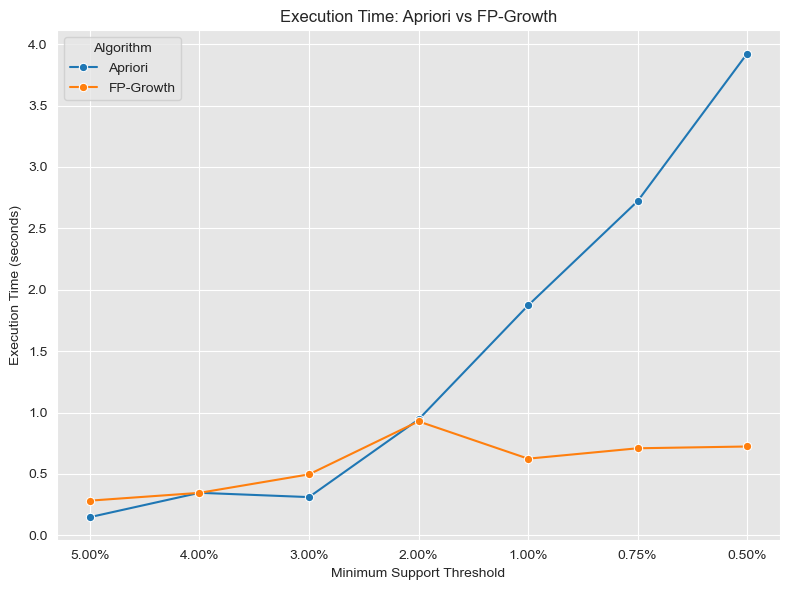

In [20]:
support_order = sorted(df_times['Support_label'].unique(),
                       key=lambda s: float(s.strip('%')), reverse=True)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
plt.figure(figsize=(8, 6))

ax = sns.lineplot(
    data=df_times,
    x='Support_label',
    y='Time',
    hue='Algorithm',
    marker='o',
    sort=False  
)

ax.set_title('Execution Time: Apriori vs FP-Growth')
ax.set_xlabel('Minimum Support Threshold')
ax.set_ylabel('Execution Time (seconds)')
ax.set_xticks(support_order)
ax.set_xticklabels(support_order)
plt.tight_layout()
plt.show()

#### 1.2.1. Minimum Relative Support Threshold

**Support** (relative support) is the proportion of transactions in a dataset that contain a specific itemset, and ranges from 0 to 1.  
For example, if an itemset appears in 5 out of 10 transactions, its support is 0.5 (50%).

$$
Support(X) = \frac{\text{Number of transactions containing }X}{\text{Total number of transactions}}
$$

or 

$$
supp(A⇒B) = \frac{|A∪B|}{n}
$$
, n being the Total number of transactions.


The **minimum support threshold** is the cutoff that we set:
<ins>any itemset with support below this value is discarded</ins>, while those above it are considered ***frequent*** and are used to generate association rules.

Nonetheless, it’s important to understand that **support is a relative metric**, depending on the total number of transactions in the dataset.

- A `0.5%` minimum support means an itemset must appear in **at least ~348 transactions** to be considered frequent.  
  This can be a significant threshold, especially for **larger itemsets**, which naturally occur less often.

- In contrast, a `0.01%` minimum support means an itemset only needs to appear in **about 7 transactions**.  
  This can allow **too many low-frequency or noisy patterns** into the results, which may bloat the output and reduce the overall quality of insights.

To choose a practical minimum support, it's useful to plot the number of frequent itemsets against varying thresholds. **As minimum support decreases, the number of patterns typically grows exponentially**. The ***“elbow point”*** in this curve <ins>is where the growth rate sharply increases, suggesting a balanced threshold that captures meaningful patterns</ins> without introducing excessive noise.

To select a practical **minimum-support threshold**, it's to plot the number of frequent itemsets againstof the varying support threshold. As the support is lowered, the count of frequent itemsets typically grows *(often exponentially)*, producing a sharp inflection, aka a **“elbow point”** , in the curve. This elbow marks a **sweet spot**: 
 * **it captures most of the meaningful patterns** 
 * **while avoiding an explosion (exponential growth) of trivial or noisy itemsets**.


In [21]:
min_sup_values = []
itemset_counts = []

# Generate thresholds from 5.0% to 0.1% in 0.1% steps (i.e., 0.001 in fraction)
for min_sup in np.arange(0.05, 0.0009, -0.001):
    try:
        frequent_itemsets = fpgrowth(binary_foodmart, min_support=min_sup, use_colnames=True)
        num_itemsets = len(frequent_itemsets)
        min_sup_values.append(round(min_sup * 100, 3))  # Convert to percentage
        itemset_counts.append(num_itemsets)
    except Exception as e:
        print(f"Error at min_sup = {min_sup*100:.3f}%: {e}")
        break

results_df = pd.DataFrame({
    'Minimum Support (%)': min_sup_values,
    'Number of Frequent Itemsets': itemset_counts
})

results_df['Jump'] = results_df['Number of Frequent Itemsets'].diff().fillna(0).astype(int)
results_df

,Minimum Support (%),Number of Frequent Itemsets,Jump
0,5.0,32,0
1,4.9,33,1
2,4.8,33,0
3,4.7,33,0
4,4.6,33,0
5,4.5,33,0
6,4.4,33,0
7,4.3,33,0
8,4.2,35,2
9,4.1,39,4


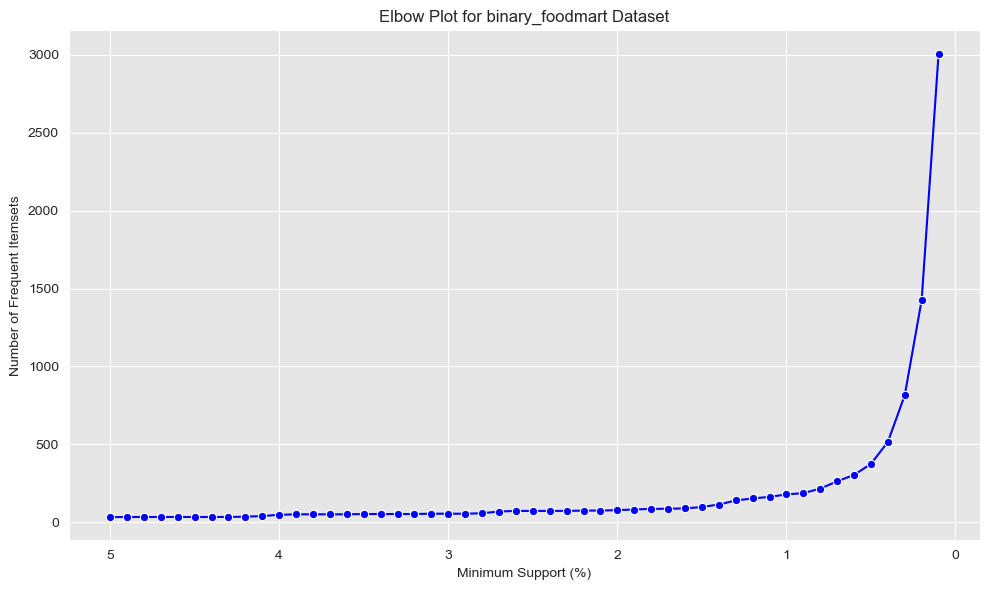

In [22]:

# Plot the elbow curve
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
plt.figure(figsize=(10, 6))
sns.lineplot(x='Minimum Support (%)', y='Number of Frequent Itemsets', data=results_df, marker='o', color='blue')
plt.xlabel('Minimum Support (%)')
plt.ylabel('Number of Frequent Itemsets')
plt.title('Elbow Plot for binary_foodmart Dataset')
plt.gca().invert_xaxis()  # Higher support on the left
plt.grid(True)
plt.tight_layout()
plt.show()

##### Elbow Point Results

- **5.0% → 3.0%**: Slow growth (32 → 54 itemsets), capturing only the most frequent patterns.  
- **3.0% → 2.0%**: Moderate growth (54 → 77), still manageable.  
- **2.0% → 1.5%**: Slight uptick (77 → 97).  
- **1.5% → 1.0%**: Noticeable jump (97 → 178), marking the start of steeper growth.  
- **1.0% → 0.5%**: More than doubles (178 → 374).  
- **0.5% → 0.1%**: Explosive increase (374 → 3009), indicating many rare/noisy itemsets.

Based on this, the elbow point appears to be around 1.5% to 0.5%, because this range balances pattern coverage and noise:

- **1.5%** yields **97** itemsets— compact, high‑confidence patterns.  
- **1.0%** yields **178** itemsets- broader coverage yet still manageable.  
- **0.5%** yields **374** itemsets— much broader coverage, may not be manageable.  (probably elbow point!)
- <ins>Below 0.5%, itemsets explode, burdening computation and including trivial rules</ins>.

**ELBOW POINT SEEMS TO BE 0.5%, TLDR**:
 * Above 0.5%: you capture the strongest patterns without generating too many rules.
 * Much below 0.5%: rule counts explode, making interpretation and filtering unwieldy.



##### Minimum Support Threshold = 5%

Each itemset show up in at least ~3478 transactions.

In [23]:
S_min_high = 0.05
frequent_subsets_high = compute_frequent_itemset_subsets(binary_foodmart, S_min_high)
print("Frequent itemsets can be partioned in",len(frequent_subsets_high), "itemsets of differing lengths.")

Frequent itemsets can be partioned in 2 itemsets of differing lengths.


In [24]:
print("Frequent itemsets of 1 item")
frequent_subsets_high[1].sort_values(by='support', ascending=False)

Frequent itemsets of 1 item


,support,itemsets,itemset_length
1,0.284461,(Fresh Vegetables),1
12,0.175286,(Fresh Fruit),1
0,0.120059,(Soup),1
3,0.117845,(Cheese),1
14,0.117227,(Dried Fruit),1
4,0.105422,(Cookies),1
29,0.080677,(Wine),1
15,0.078966,(Paper Wipes),1
20,0.078549,(Canned Vegetables),1
22,0.068340,(Frozen Vegetables),1


In [25]:
print("Frequent itemsets of 2 items")
frequent_subsets_high[2]

Frequent itemsets of 2 items


,support,itemsets,itemset_length
31,0.050971,"(Fresh Fruit, Fresh Vegetables)",2


##### Mininum Support Threshhold = 1%

Each itemset show up in at least ~696 transactions.

In [26]:
S_min_high = 0.01
frequent_subsets_high = compute_frequent_itemset_subsets(binary_foodmart, S_min_high)
print("Frequent itemsets can be partioned in",len(frequent_subsets_high), "itemsets of differing lengths.")

Frequent itemsets can be partioned in 2 itemsets of differing lengths.


In [27]:
print("Frequent itemsets of 1 item")
frequent_subsets_high[1].sort_values(by='support', ascending=False)

Frequent itemsets of 1 item


,support,itemsets,itemset_length
2,0.284461,(Fresh Vegetables),1
29,0.175286,(Fresh Fruit),1
0,0.120059,(Soup),1
5,0.117845,(Cheese),1
32,0.117227,(Dried Fruit),1
...,...,...,...
100,0.013343,(Sardines),1
34,0.013271,(Sauces),1
83,0.013156,(Fashion Magazines),1
95,0.012998,(Pancakes),1


In [28]:
print("Frequent itemsets of 2 items")
frequent_subsets_high[2].sort_values(by='support', ascending=False)

Frequent itemsets of 2 items


,support,itemsets,itemset_length
134,0.050971,"(Fresh Fruit, Fresh Vegetables)",2
102,0.035701,"(Soup, Fresh Vegetables)",2
138,0.035284,"(Dried Fruit, Fresh Vegetables)",2
110,0.031201,"(Cheese, Fresh Vegetables)",2
112,0.027765,"(Cookies, Fresh Vegetables)",2
...,...,...,...
121,0.010281,"(Cleaners, Fresh Vegetables)",2
157,0.010194,"(Fresh Fruit, Frozen Vegetables)",2
155,0.010165,"(Fresh Vegetables, Popcorn)",2
175,0.010137,"(Dried Fruit, Wine)",2


##### Minimum Support Threshold = 0.5%

Each itemset show up in at least ~347 transactions.

In [29]:
S_min_high = 0.005
frequent_subsets_high = compute_frequent_itemset_subsets(binary_foodmart, S_min_high, "fp_growth")
print("Frequent itemsets can be partioned in",len(frequent_subsets_high), "itemsets of differing lengths.")

Frequent itemsets can be partioned in 3 itemsets of differing lengths.


In [30]:
print("Frequent itemsets of 1 item")
frequent_subsets_high[1].sort_values(by='support', ascending=False)

Frequent itemsets of 1 item


,support,itemsets,itemset_length
2,0.284461,(Fresh Vegetables),1
29,0.175286,(Fresh Fruit),1
0,0.120059,(Soup),1
5,0.117845,(Cheese),1
32,0.117227,(Dried Fruit),1
...,...,...,...
100,0.013343,(Sardines),1
34,0.013271,(Sauces),1
83,0.013156,(Fashion Magazines),1
95,0.012998,(Pancakes),1


In [31]:
print("Frequent itemsets of 2 items")
frequent_subsets_high[2].sort_values(by='support', ascending=False)

Frequent itemsets of 2 items


,support,itemsets,itemset_length
212,0.050971,"(Fresh Fruit, Fresh Vegetables)",2
102,0.035701,"(Soup, Fresh Vegetables)",2
224,0.035284,"(Dried Fruit, Fresh Vegetables)",2
122,0.031201,"(Cheese, Fresh Vegetables)",2
129,0.027765,"(Cookies, Fresh Vegetables)",2
...,...,...,...
157,0.005018,"(Dips, Cookies)",2
329,0.005018,"(Frozen Chicken, Cookies)",2
301,0.005004,"(Paper Wipes, Lightbulbs)",2
109,0.005004,"(Cheese, Pasta)",2


In [32]:
print("Frequent itemsets of 3 items")
frequent_subsets_high[3].sort_values(by='support', ascending=False)

Frequent itemsets of 3 items


,support,itemsets,itemset_length
104,0.007089,"(Soup, Fresh Fruit, Fresh Vegetables)",3
134,0.005550,"(Fresh Fruit, Cookies, Fresh Vegetables)",3
123,0.005334,"(Fresh Fruit, Cheese, Fresh Vegetables)",3


##### Minimum Support Threshold = 0.1%

Each itemset show up in at least ~70 transactions.

In [33]:
S_min_high = 0.001
frequent_subsets_high = compute_frequent_itemset_subsets(binary_foodmart, S_min_high, "fp_growth")
print("Frequent itemsets can be partioned in",len(frequent_subsets_high), "itemsets of differing lengths.")

Frequent itemsets can be partioned in 3 itemsets of differing lengths.


In [34]:
print("Frequent itemsets of 1 items")
frequent_subsets_high[1].sort_values(by='support', ascending=False)

Frequent itemsets of 1 items


,support,itemsets,itemset_length
2,0.284461,(Fresh Vegetables),1
29,0.175286,(Fresh Fruit),1
0,0.120059,(Soup),1
5,0.117845,(Cheese),1
32,0.117227,(Dried Fruit),1
...,...,...,...
100,0.013343,(Sardines),1
34,0.013271,(Sauces),1
83,0.013156,(Fashion Magazines),1
95,0.012998,(Pancakes),1


In [35]:
print("Frequent itemsets of 2 items")
frequent_subsets_high[2].sort_values(by='support', ascending=False)

Frequent itemsets of 2 items


,support,itemsets,itemset_length
1121,0.050971,"(Fresh Fruit, Fresh Vegetables)",2
102,0.035701,"(Soup, Fresh Vegetables)",2
1193,0.035284,"(Dried Fruit, Fresh Vegetables)",2
222,0.031201,"(Cheese, Fresh Vegetables)",2
327,0.027765,"(Cookies, Fresh Vegetables)",2
...,...,...,...
594,0.001006,"(Sour Cream, Tofu)",2
2551,0.001006,"(Home Magazines, Juice)",2
289,0.001006,"(Hard Candy, Peanut Butter)",2
1832,0.001006,"(Hamburger, Mouthwash)",2


In [36]:
print("Frequent itemsets of 3 items")
frequent_subsets_high[3].sort_values(by='support', ascending=False)

Frequent itemsets of 3 items


,support,itemsets,itemset_length
104,0.007089,"(Soup, Fresh Fruit, Fresh Vegetables)",3
332,0.005550,"(Fresh Fruit, Cookies, Fresh Vegetables)",3
225,0.005334,"(Fresh Fruit, Cheese, Fresh Vegetables)",3
1200,0.004975,"(Fresh Fruit, Dried Fruit, Fresh Vegetables)",3
1213,0.004702,"(Paper Wipes, Fresh Vegetables, Fresh Fruit)",3
...,...,...,...
1356,0.001006,"(Chips, Fresh Vegetables, Frozen Vegetables)",3
1581,0.001006,"(Chips, Fresh Vegetables, Coffee)",3
313,0.001006,"(Soup, Hard Candy, Fresh Vegetables)",3
2840,0.001006,"(Cereal, Pizza, Fresh Vegetables)",3


#### 1.2.2. Discussing Results

Initially, setting the minimum support threshold to **5%** yielded limited set of frequent itemsets. Under this criterion, only the strongest individual items emerged as frequent, and only one pair (Fresh Fruit and Fresh Vegetables) was identified as a frequent 2-item set. This outcome reflects the very high and unbalanced frequency of top items like Fresh Vegetables and Fresh Fruit, which appear in approximately **28%** and **17%** of baskets respectively, whereas the average support of individual items is around **4%**.

Lowering the threshold to **1%** led to a marked increase in the number of frequent itemsets. The pool of frequent 1-item sets expanded considerably to include a wider range of products, and the number of 2-item sets also rose, thereby revealing more co-occurrence patterns. At this level, each itemset appears in roughly 695 transactions (a nontrivial criterion).

A further reduction of the support threshold to **0.5%** produced an even more dramatic rise in the number of frequent itemsets, including the appearance of 3-item sets. Under these conditions, it was captured a diverse array of item combinations, showing more intricate interactions among products. However, lowering the support this far also increases the likelihood of incorporating **statistically insignificant patterns**, as the gain of associations began to rise exponentially (**noise creeping in**).

Essentially, setting the support threshold to around **1.5%** or **1%** produces a leaner output. The algorithm returns a focused collection of frequent itemsets while excluding less common patterns. However, the dataset being so unbalanced, a great deal of information is likely lost. Conversely, reducing the threshold to **0.5%** (the detected “***elbow point***”) shows a substantially larger number of itemsets, including higher-order combinations that better represent the domain in question. However, this richer diversity may also introduce additional noise. Some residual noise may later be pruned through further rule-level thresholds, such as confidence and lift cutoffs.

Minimum support thresholds just a few decimals below **0.5%** (for example, **0.1%**) are already likely to introduce excessive noise and yield impractically bloated outputs, which is why they were not pursued.

<ins>We decided to have <strong>0.5% to 0.3%</strong> as our standard minimum support thresholds, but we still experiment with others to ensure robustness of this decision.</ins> For an itemset to be considered frequent they have to how up at least in:
* ~374 transactions (0.5%)
* ~208 transactions (0.3%)



### 1.3. Generate Association Rules from Frequent Itemsets

##### To Do:

Using a minimum support S_min fundamented by the previous results. 
* Generate association rules with a chosen value (C) for minimum confidence. 
* Generate association rules with a chosen value (L) for minimum lift. 
* Generate association rules with both confidence >= C and lift >= L.
* Change C and L when it makes sense and discuss the results.
* Use other metrics besides confidence and lift.
* Evaluate how good the rules are given the metrics and how interesting they are from your point of view.

#### 1.3.0. What are Association Rules


An association rule implies that if itemset **X** occurs, then itemset **Y** also occurs with a certain probability. It is defined as an implication: `X → Y` where **X** (the _antecedent_) and **Y** (the _consequent_) are disjoint subsets (no item in common) of the full itemset **I** (X, Y ⊆ I and X ∩ Y = ∅).

**Example:** 
 * `{Bacon, Egg} → {Milk}`  
 * `Itemset = {Bacon, Egg, Milk}`

There are <ins>various metrics that evaluate the perceived strength of assosciation</ins> between **antecedent** and **consequent**:

 * Support
 * Confidence
 * Lift
 * Leverage
 * Conviction



#### 1.3.1 Association Rules for Confidence

**Confidence**: is a measure of <ins>how often items in a rule are found together</ins>. For instance, a confidence of 60% means that 60% of the customers who purchased A also bought B.
* Confidence helps rank rules by how strong they are.
* But confidence does not account for the overall frequency of B (for that, lift is used). 

$$
\text{Confidence}(A \rightarrow B) = \frac{\text{Support}(A \cup B)}{\text{Support}(A)}
$$

**Confidence** evaluates the probability that **B** (consequent) will be purchased/ occur if **A** (antecedent) is purchased/ occurs. Ranges from 0 to 1:

- **High Confidence (close to 1)**: This means that **B** is very likely to appear in transactions that already contain **A**. This implies a strong association between **A** and **B**.
  
- **Low Confidence (close to 0)**: This means that **B** is not likely to appear in transactions that contain **A**. In this case, the association between **A** and **B** is weak.


In [37]:
# Rules computing them at 6 different support levels
support_levels    = [0.05, 0.01, 0.005, 0.003, 0.001, 0.0008, 0.0005]
confidence_levels = np.arange(0.1, 1.0, 0.1)

# Sweep FP‑Growth and count rules
rules_counts = {sup: [] for sup in support_levels}
for sup in support_levels:
    freq_itemsets = fpgrowth(binary_foodmart, min_support=sup, use_colnames=True)
    for conf in confidence_levels:
        rules = association_rules(freq_itemsets, metric="confidence", min_threshold=conf)
        rules_counts[sup].append(len(rules))

records = []
for sup in support_levels:
    for conf, cnt in zip(confidence_levels, rules_counts[sup]):
        records.append({
            'Min Support (%)': f"{sup*100:.4f}",
            'Confidence': conf,
            'Num Rules': cnt
        })
plot_df = pd.DataFrame(records)

#  Plotting the results
fig = px.line(
    plot_df,
    x="Confidence",
    y="Num Rules",
    facet_col="Min Support (%)",
    facet_col_wrap=3,
    markers=True,
    title="Rules vs. Confidence for Different Support Levels",
    labels={"Num Rules":"Number of Rules"}
)

# Share axes
fig.update_yaxes(matches="y")
fig.update_xaxes(matches="x")
fig.update_layout(
    height=600,
    width=900,
    margin=dict(t=80, b=50, l=50, r=50)
)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1] + "%"))
fig.show()

The six‐panel chart makes clear how dramatically the size of our rule set depends on the support threshold. At **5% support**, there are virtually no rules once you raise confidence above 10%, even at 10% confidence, only a couple of trivial pairs survive. Dropping to **1% support** yields about 80–90 rules at 10% confidence, but they all vanish by 30% confidence, so these are very coarse, generic associations. 

At **0.5% support**, a healthy pool of roughly 250 rules at 10% confidence is finally seen, which thins to fewer than ten by 30%. This is the classic “elbow” region where there is a balance of coverage and manageability. Pushing support lower (0.1%, 0.08%, 0.05%) unleashes thousands of rules at low confidence but still collapses to zero by 40%–50%, flooding the output with ***low value associations***.

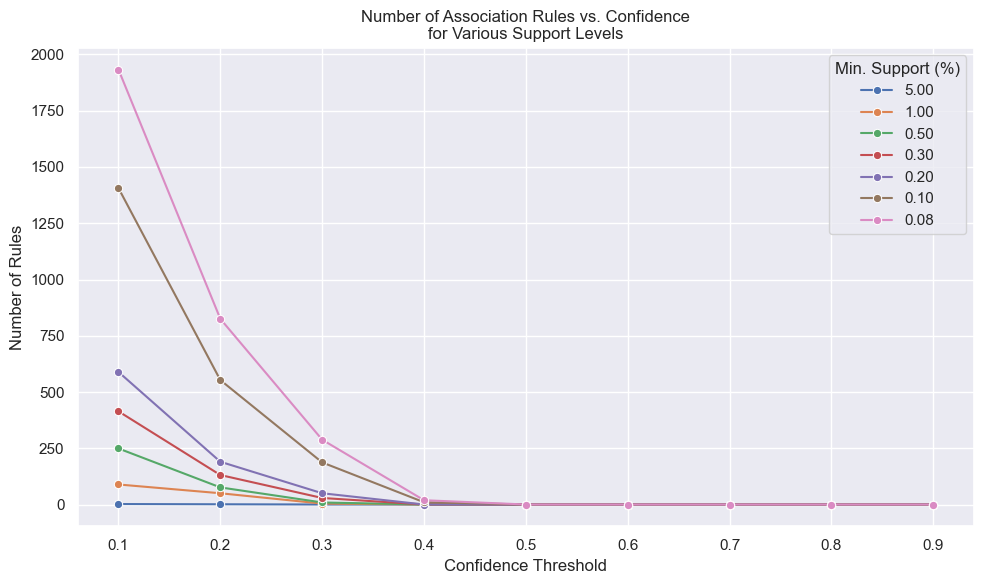

In [38]:
# Rules computing them at 6 different support levels
support_levels    = [0.05, 0.01, 0.005, 0.003, 0.002, 0.001, 0.0008]
confidence_levels = np.arange(0.1, 1.0, 0.1)

# Sweep FP‑Growth and count rules
rules_counts = {sup: [] for sup in support_levels}
for sup in support_levels:
    freq_itemsets = fpgrowth(binary_foodmart, min_support=sup, use_colnames=True)
    for conf in confidence_levels:
        rules = association_rules(freq_itemsets, metric="confidence", min_threshold=conf)
        rules_counts[sup].append(len(rules))
        
records = []
for sup in support_levels:
    for conf, cnt in zip(confidence_levels, rules_counts[sup]):
        records.append({
            'Support (%)': f"{sup*100:.2f}",
            'Confidence': conf,
            'Num Rules': cnt
        })
plot_df = pd.DataFrame.from_records(records)

# All in one plot
sns.set(style="darkgrid", palette="deep")
plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data=plot_df,
    x="Confidence",
    y="Num Rules",
    hue="Support (%)",
    marker="o"
)
ax.set_title("Number of Association Rules vs. Confidence\nfor Various Support Levels")
ax.set_ylabel("Number of Rules")
ax.set_xlabel("Confidence Threshold")
plt.legend(title="Min. Support (%)")
plt.tight_layout()
plt.show()


Overlaying all six curves in a single plot drives home the same point:  
- high‐support curves sit flat near zero,  
- ultra‐low support curves skyrocket into the thousands at low confidence,  
- only the mid‐range supports (0.5–0.1%) give you a substantial—but still limited—number of rules that disappear quickly as you raise confidence.

For a concise, high‑value rule set choosing **min_support ≈ 0.5%** with **min_confidence 20–30%** (yielding a few dozen solid rules) or, for broader coverage, **min_support ≈ 0.1%** with **conf ≥ 20%** is probably for the better. It results in couple hundred rules that can be **further pruned by lift**.  


In [39]:
_RULE_COLS = [
    'antecedents', 'consequents', 'antecedent support', 'consequent support',
    'support', 'count',
    'confidence', 'lift',
    'leverage', 'conviction'
]

def generate_rules(
    df: pd.DataFrame,
    min_support = 0.01,
    metric = 'confidence',
    min_threshold = 0.1):
    """
    Run FP-Growth + association_rules on a binary-encoded DataFrame.

    Requires:
    df : pd.DataFrame
        One-hot / binary-encoded transactions (columns=items, rows=transactions).
    min_support : float
        Minimum support for FP-Growth (e.g. 0.01 for 1%).
    metric : str, default='confidence'
        Which metric to use for filtering rules.  
        Options include 'confidence', 'lift', 'leverage', 'conviction'.
    min_threshold : float, default=0.1
        Minimum threshold for the chosen metric (e.g. 0.1 for 10% confidence).

    Returns:
    pd.DataFrame
        Association rules, with columns:
        antecedents, consequents, support, count, confidence, lift, leverage, conviction.
    """
    freq_itemsets = fpgrowth(df, min_support=min_support, use_colnames=True)
    
    # association rules
    rules = association_rules(
        freq_itemsets,
        metric=metric,
        min_threshold=min_threshold
    )
    
    # add absolute counts
    n_trans = df.shape[0]
    rules['count'] = rules['support'] * n_trans
    
    return rules[_RULE_COLS].copy()


##### Association Rules - Minimum Support Threshold == 1%

In [40]:
rules_1   = generate_rules(binary_foodmart, 0.01, metric='confidence', min_threshold=0.2)
print("Number of rules generated:", len(rules_1))
rules_1.sort_values('confidence', ascending=False).head(20)

Number of rules generated: 50


,antecedents,consequents,antecedent support,consequent support,support,count,confidence,lift,leverage,conviction
38,(Shampoo),(Fresh Vegetables),0.041007,0.284461,0.012667,881.0,0.308906,1.085933,0.001002,1.035371
21,(Donuts),(Fresh Vegetables),0.040403,0.284461,0.012466,867.0,0.308541,1.084650,0.000973,1.034824
17,(Personal Hygiene),(Fresh Vegetables),0.054623,0.284461,0.016506,1148.0,0.302185,1.062305,0.000968,1.025399
25,(Dried Fruit),(Fresh Vegetables),0.117227,0.284461,0.035284,2454.0,0.300993,1.058118,0.001938,1.023651
18,(Hot Dogs),(Fresh Vegetables),0.040432,0.284461,0.012107,842.0,0.299431,1.052625,0.000605,1.021368
0,(Soup),(Fresh Vegetables),0.120059,0.284461,0.035701,2483.0,0.297365,1.045363,0.001549,1.018365
13,(Deli Meats),(Fresh Vegetables),0.053617,0.284461,0.015902,1106.0,0.296594,1.042652,0.000651,1.017249
46,(Nuts),(Fresh Vegetables),0.067176,0.284461,0.019828,1379.0,0.295163,1.037620,0.000719,1.015183
20,(Bologna),(Fresh Vegetables),0.040633,0.284461,0.011948,831.0,0.294055,1.033727,0.000390,1.013590
45,(TV Dinner),(Fresh Vegetables),0.041798,0.284461,0.012250,852.0,0.293086,1.030318,0.000360,1.012200


In [41]:
rules_1   = generate_rules(binary_foodmart, 0.01, metric='confidence', min_threshold=0.3)
print("Number of rules generated:", len(rules_1))
rules_1.sort_values('confidence', ascending=False).head(20)

Number of rules generated: 4


,antecedents,consequents,antecedent support,consequent support,support,count,confidence,lift,leverage,conviction
3,(Shampoo),(Fresh Vegetables),0.041007,0.284461,0.012667,881.0,0.308906,1.085933,0.001002,1.035371
1,(Donuts),(Fresh Vegetables),0.040403,0.284461,0.012466,867.0,0.308541,1.084650,0.000973,1.034824
0,(Personal Hygiene),(Fresh Vegetables),0.054623,0.284461,0.016506,1148.0,0.302185,1.062305,0.000968,1.025399
2,(Dried Fruit),(Fresh Vegetables),0.117227,0.284461,0.035284,2454.0,0.300993,1.058118,0.001938,1.023651


##### Association Rules - Minimum Support Threshold == 0.5%

In [42]:
rules_05   = generate_rules(binary_foodmart, 0.005, metric='confidence', min_threshold=0.2)
print("Number of rules generated:", len(rules_05))
rules_05.sort_values('confidence', ascending=False).head(20)

Number of rules generated: 76


,antecedents,consequents,antecedent support,consequent support,support,count,confidence,lift,leverage,conviction
1,"(Soup, Fresh Fruit)",(Fresh Vegetables),0.020805,0.284461,0.007089,493.0,0.340705,1.197720,0.001170,1.085309
70,(Aspirin),(Fresh Vegetables),0.026672,0.284461,0.008613,599.0,0.322911,1.135167,0.001026,1.056787
55,(Hamburger),(Fresh Vegetables),0.028297,0.284461,0.008943,622.0,0.316057,1.111072,0.000894,1.046196
8,(Hard Candy),(Fresh Vegetables),0.027535,0.284461,0.008512,592.0,0.309138,1.086750,0.000679,1.035719
49,(Shampoo),(Fresh Vegetables),0.041007,0.284461,0.012667,881.0,0.308906,1.085933,0.001002,1.035371
31,(Donuts),(Fresh Vegetables),0.040403,0.284461,0.012466,867.0,0.308541,1.084650,0.000973,1.034824
67,(Sugar),(Fresh Vegetables),0.027348,0.284461,0.008296,577.0,0.303365,1.066454,0.000517,1.027136
26,(Personal Hygiene),(Fresh Vegetables),0.054623,0.284461,0.016506,1148.0,0.302185,1.062305,0.000968,1.025399
35,(Dried Fruit),(Fresh Vegetables),0.117227,0.284461,0.035284,2454.0,0.300993,1.058118,0.001938,1.023651
27,(Hot Dogs),(Fresh Vegetables),0.040432,0.284461,0.012107,842.0,0.299431,1.052625,0.000605,1.021368


In [43]:
rules_05   = generate_rules(binary_foodmart, 0.005, metric='confidence', min_threshold=0.3)
print("Number of rules generated:", len(rules_05))
rules_05.sort_values('confidence', ascending=False).head(20)

Number of rules generated: 9


,antecedents,consequents,antecedent support,consequent support,support,count,confidence,lift,leverage,conviction
0,"(Soup, Fresh Fruit)",(Fresh Vegetables),0.020805,0.284461,0.007089,493.0,0.340705,1.197720,0.001170,1.085309
8,(Aspirin),(Fresh Vegetables),0.026672,0.284461,0.008613,599.0,0.322911,1.135167,0.001026,1.056787
6,(Hamburger),(Fresh Vegetables),0.028297,0.284461,0.008943,622.0,0.316057,1.111072,0.000894,1.046196
1,(Hard Candy),(Fresh Vegetables),0.027535,0.284461,0.008512,592.0,0.309138,1.086750,0.000679,1.035719
5,(Shampoo),(Fresh Vegetables),0.041007,0.284461,0.012667,881.0,0.308906,1.085933,0.001002,1.035371
3,(Donuts),(Fresh Vegetables),0.040403,0.284461,0.012466,867.0,0.308541,1.084650,0.000973,1.034824
7,(Sugar),(Fresh Vegetables),0.027348,0.284461,0.008296,577.0,0.303365,1.066454,0.000517,1.027136
2,(Personal Hygiene),(Fresh Vegetables),0.054623,0.284461,0.016506,1148.0,0.302185,1.062305,0.000968,1.025399
4,(Dried Fruit),(Fresh Vegetables),0.117227,0.284461,0.035284,2454.0,0.300993,1.058118,0.001938,1.023651


##### Association Rules - Minimum Support Threshold == 0.1%

In [44]:
rules_01   = generate_rules(binary_foodmart, 0.001, metric='confidence', min_threshold=0.3)
print("Number of rules generated:", len(rules_01))
rules_01.sort_values('confidence', ascending=False).head(20)

Number of rules generated: 187


,antecedents,consequents,antecedent support,consequent support,support,count,confidence,lift,leverage,conviction
112,"(Pizza, Shampoo)",(Fresh Vegetables),0.002444,0.284461,0.001136,79.0,0.464706,1.633635,0.000441,1.336721
158,"(Aspirin, Dried Fruit)",(Fresh Vegetables),0.003336,0.284461,0.001438,100.0,0.431034,1.515266,0.000489,1.257613
140,"(Preserves, TV Dinner)",(Fresh Vegetables),0.002818,0.284461,0.001208,84.0,0.428571,1.506607,0.000406,1.252193
6,"(Deli Meats, Pasta)",(Fresh Vegetables),0.003091,0.284461,0.001308,91.0,0.423256,1.487920,0.000429,1.240652
69,"(Chocolate Candy, Bologna)",(Fresh Vegetables),0.003264,0.284461,0.001366,95.0,0.418502,1.471210,0.000437,1.230510
124,"(Hamburger, Dried Fruit)",(Fresh Vegetables),0.002559,0.284461,0.001064,74.0,0.415730,1.461465,0.000336,1.224672
173,"(Pot Cleaners, Dried Fruit)",(Fresh Vegetables),0.002430,0.284461,0.001006,70.0,0.414201,1.456090,0.000315,1.221475
76,"(Eggs, Sliced Bread)",(Fresh Vegetables),0.003710,0.284461,0.001524,106.0,0.410853,1.444318,0.000469,1.214533
162,"(Fresh Fruit, Home Magazines)",(Fresh Vegetables),0.002646,0.284461,0.001078,75.0,0.407609,1.432914,0.000326,1.207882
94,"(Soda, Juice)",(Fresh Vegetables),0.002617,0.284461,0.001050,73.0,0.401099,1.410030,0.000305,1.194753


In [45]:
rules_01   = generate_rules(binary_foodmart, 0.001, metric='confidence', min_threshold=0.4)
print("Number of rules generated:", len(rules_01))
rules_01.sort_values('confidence', ascending=False).head(20)

Number of rules generated: 10


,antecedents,consequents,antecedent support,consequent support,support,count,confidence,lift,leverage,conviction
4,"(Pizza, Shampoo)",(Fresh Vegetables),0.002444,0.284461,0.001136,79.0,0.464706,1.633635,0.000441,1.336721
7,"(Aspirin, Dried Fruit)",(Fresh Vegetables),0.003336,0.284461,0.001438,100.0,0.431034,1.515266,0.000489,1.257613
6,"(Preserves, TV Dinner)",(Fresh Vegetables),0.002818,0.284461,0.001208,84.0,0.428571,1.506607,0.000406,1.252193
0,"(Deli Meats, Pasta)",(Fresh Vegetables),0.003091,0.284461,0.001308,91.0,0.423256,1.487920,0.000429,1.240652
1,"(Chocolate Candy, Bologna)",(Fresh Vegetables),0.003264,0.284461,0.001366,95.0,0.418502,1.471210,0.000437,1.230510
5,"(Hamburger, Dried Fruit)",(Fresh Vegetables),0.002559,0.284461,0.001064,74.0,0.415730,1.461465,0.000336,1.224672
9,"(Pot Cleaners, Dried Fruit)",(Fresh Vegetables),0.002430,0.284461,0.001006,70.0,0.414201,1.456090,0.000315,1.221475
2,"(Eggs, Sliced Bread)",(Fresh Vegetables),0.003710,0.284461,0.001524,106.0,0.410853,1.444318,0.000469,1.214533
8,"(Fresh Fruit, Home Magazines)",(Fresh Vegetables),0.002646,0.284461,0.001078,75.0,0.407609,1.432914,0.000326,1.207882
3,"(Soda, Juice)",(Fresh Vegetables),0.002617,0.284461,0.001050,73.0,0.401099,1.410030,0.000305,1.194753


##### 1.3.1.1. Discussing Results

When **min_support = 1%** and **min_confidence = 10%** are applied, FP-Growth generates 89 rules, all predicting **Fresh Vegetables**.  
At this threshold, each single-item antecedent (e.g., Shampoo, Donuts, Soup) co-occurs with Fresh Vegetables only marginally more often than expected by chance, resulting in weak, generic associations.  This **phenomenon is attributable to the high support of the consequent: very common items yield trivial rules that inflate confidence without providing substantive rules**.

When the confidence threshold is raised to **20%** at the same support level, the rule set is reduced to four specific associations—  
Shampoo → Fresh Vegetables
Donuts → Fresh Vegetables
Personal Hygiene → Fresh Vegetables
Dried Fruit → Fresh Vegetables.
This outcome confirms that single-item rules at 1% support lack both strength and variety, indicating that the chosen support level may be overly restrictive.

When support is lowered to **0.5%**, the rule set expands dramatically:  
- At **10% confidence**, 249 rules are discovered, including a multi-item antecedent such as {Soup, Fresh Fruit} → {Fresh Vegetables}.with confidence 34% and lift 1.20. This rule represents a strong, actionable cross-sell insight not observed at the higher support threshold.  
- When confidence is increased to **20%** under 0.5% support, 76 rules remain—many involving multiple antecedents—while a **30%** confidence cut-off yields only nine rules, primarily those with the highest lift and confidence.

The **small-numbers illusion** should also be acknowledged: when support falls below approximately 0.1%, rules can attain high confidence based on only a handful of transactions, rendering them highly sensitive to random noise. In such cases, a single additional transaction can dramatically alter confidence values, and spurious associations may arise purely by chance after evaluating thousands of rare item pairs.

To fix these brittle patterns, it is **ESSENTIAL** to apply a **lift** filter following the confidence threshold: lift measures the deviation of observed co-occurrence from random expectation and **exposes/removes rules whose impressive confidence is driven by item popularity rather than genuine affinity** (like the Fresh Vegetables consequent issue). Only rules that satisfy both a sensible minimum support and a lift-based screening can be considered robust and suitable for operational deployment. LIFT MIGHT BE THE BEST PRIMARY RULE TO APPLY AND LEAVE CONFIDENCE AS A MINOR/ LESSER RULES WITH A SMALLER THRESHOLD.

#### 1.3.2 Association Rules for Lift (*without confidence*)

**Lift**: evaluate the strength of a rule beyond making sure it's not just by chance. It measures how much more likely two items are to appear together, compared to being independent.
* <ins>**THE BIG DIFFERENCE**</ins>: **Confidence** measures how likely B is given A, but it does not account for the relative frequencies of A and B. This means that high confidence does not always imply a strong relationship between A and B; if one of them is incredibly porpular it can inflate the easily inflate the value, misleading us. **Lift**, on the other hand, <ins>normalizes the support of A and B and provides a true measure of association, factoring in how frequently both items occur in the dataset</ins>, axing trivial associations.
* Essentially lift **corrects for the frequency bias of individual items**.
* Helps identify strong correlations in the data that may not be apparent from support alone.

$$
\text{Lift}(A \rightarrow B) = \frac{\text{Support}(A \cup B)}{\text{Support}(A) \times \text{Support}(B)}
$$


**Interpretation of Lift**, Range 0 to Infinity:

- **Lift = 1**: \( A \) and \( B \) are **independent**, meaning their co-occurrence is purely by chance.
- **Lift > 1**: There is a **positive association** between \( A \) and \( B \), meaning they appear together **more often than expected**.
- **Lift < 1**: There is a **negative association** between \( A \) and \( B \), meaning they appear together **less often than expected**.


In [46]:
support_levels  = [0.05, 0.01, 0.005, 0.003]
lift_thresholds = np.arange(1.0, 2.1, 0.1)
records = []

for sup in support_levels:
    freq_itemsets = fpgrowth(binary_foodmart, min_support=sup, use_colnames=True)
    rules = association_rules(freq_itemsets, metric="lift", min_threshold=1.0)
    for lt in lift_thresholds:
        cnt = (rules['lift'] >= lt).sum()
        records.append({
            'Min Support (%)': f"{sup*100:.4f}",
            'Lift Threshold': lt,
            'Number of Rules': cnt
        })

plot_df = pd.DataFrame(records)

# 4) Faceted line plot with Plotly
fig = px.line(
    plot_df,
    x="Lift Threshold",
    y="Number of Rules",
    facet_col="Min Support (%)",
    facet_col_wrap=2,
    markers=True,
    title="Rules vs. Lift Threshold for Different Support Levels",
    labels={"Number of Rules":"Number of Rules"}
)

# share axes
fig.update_xaxes(matches="x")
fig.update_yaxes(matches="y")
fig.update_layout(
    height=600,
    width=900,
    margin=dict(t=80, b=50, l=50, r=50)
)
# convert annotations to just the support value (as %)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1] + "%"))
fig.show()

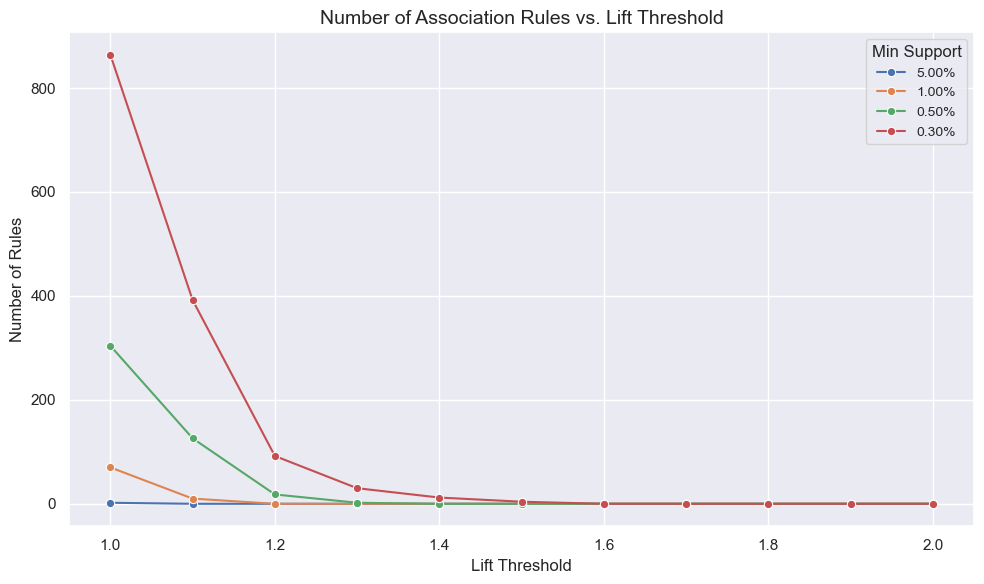

In [47]:
support_levels  = [0.05, 0.01, 0.005, 0.003]
lift_thresholds = np.arange(1.0, 2.1, 0.1)
records = []

for sup in support_levels:
    # mine frequent itemsets at this support
    freq_itemsets = fpgrowth(binary_foodmart, min_support=sup, use_colnames=True)
    # generate all rules with lift >= 1.0
    rules = association_rules(freq_itemsets, metric="lift", min_threshold=1.0)
    # count how many rules survive each lift threshold
    for lt in lift_thresholds:
        count = (rules['lift'] >= lt).sum()
        records.append({
            'Support': f"{sup*100:.2f}%",
            'Lift Threshold': lt,
            'Rule Count': count
        })

plot_df = pd.DataFrame(records)

# Plot with seaborn
sns.set_theme(style="darkgrid", palette="deep")
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=plot_df,
    x='Lift Threshold',
    y='Rule Count',
    hue='Support',
    marker='o'
)
plt.title('Number of Association Rules vs. Lift Threshold', fontsize=14)
plt.xlabel('Lift Threshold', fontsize=12)
plt.ylabel('Number of Rules', fontsize=12)
plt.legend(title='Min Support', title_fontsize=12, fontsize=10)
plt.tight_layout()
plt.show()

##### Association Rules - Minimum Support Threshold == 1%

At least in ~696 transactions.

In [48]:
rules_1   = generate_rules(binary_foodmart, 0.01, metric='lift', min_threshold=1.1)
print("Number of rules generated:", len(rules_1))
rules_1.sort_values('lift', ascending=False).head(20)

Number of rules generated: 10


,antecedents,consequents,antecedent support,consequent support,support,count,confidence,lift,leverage,conviction
6,(Soup),(Wine),0.120059,0.080677,0.011273,784.0,0.093892,1.163805,0.001587,1.014585
7,(Wine),(Soup),0.080677,0.120059,0.011273,784.0,0.139726,1.163805,0.001587,1.022860
2,(Fresh Fruit),(Juice),0.175286,0.053689,0.010769,749.0,0.061439,1.144350,0.001358,1.008257
3,(Juice),(Fresh Fruit),0.053689,0.175286,0.010769,749.0,0.200589,1.144350,0.001358,1.031652
5,(Batteries),(Fresh Fruit),0.053962,0.175286,0.010798,751.0,0.200107,1.141597,0.001339,1.031029
4,(Fresh Fruit),(Batteries),0.175286,0.053962,0.010798,751.0,0.061603,1.141597,0.001339,1.008142
8,(Fresh Fruit),(Pizza),0.175286,0.054048,0.010654,741.0,0.060783,1.124598,0.001180,1.007170
9,(Pizza),(Fresh Fruit),0.054048,0.175286,0.010654,741.0,0.197127,1.124598,0.001180,1.027203
0,(Fresh Fruit),(Sliced Bread),0.175286,0.056320,0.010942,761.0,0.062423,1.108365,0.001070,1.006509
1,(Sliced Bread),(Fresh Fruit),0.056320,0.175286,0.010942,761.0,0.194281,1.108365,0.001070,1.023575


In [49]:
rules_1   = generate_rules(binary_foodmart, 0.01, metric='lift', min_threshold=1.15)
print("Number of rules generated:", len(rules_1))
rules_1.sort_values('lift', ascending=False).head(20)

Number of rules generated: 2


,antecedents,consequents,antecedent support,consequent support,support,count,confidence,lift,leverage,conviction
0,(Soup),(Wine),0.120059,0.080677,0.011273,784.0,0.093892,1.163805,0.001587,1.014585
1,(Wine),(Soup),0.080677,0.120059,0.011273,784.0,0.139726,1.163805,0.001587,1.022860


**We'll use the same formatting function using before in the confidence association rules adapted for the lift.**

##### Association Rules - Minimum Support Threshold == 0.5%

At least in ~348 transactions.

In [50]:
rules_05   = generate_rules(binary_foodmart, 0.005, metric='lift', min_threshold=1.1)
print("Number of rules generated:", len(rules_05))
rules_05.sort_values('lift', ascending=False).head(20)

Number of rules generated: 126


,antecedents,consequents,antecedent support,consequent support,support,count,confidence,lift,leverage,conviction
117,(Deli Salads),(Cheese),0.041453,0.117845,0.006787,472.0,0.163718,1.389269,0.001902,1.054854
116,(Cheese),(Deli Salads),0.117845,0.041453,0.006787,472.0,0.057589,1.389269,0.001902,1.017122
63,(Canned Vegetables),(Soda),0.078549,0.052395,0.005320,370.0,0.067728,1.292656,0.001204,1.016448
62,(Soda),(Canned Vegetables),0.052395,0.078549,0.005320,370.0,0.101537,1.292656,0.001204,1.025586
60,(Waffles),(Canned Vegetables),0.054623,0.078549,0.005435,378.0,0.099500,1.266725,0.001144,1.023266
61,(Canned Vegetables),(Waffles),0.078549,0.054623,0.005435,378.0,0.069193,1.266725,0.001144,1.015652
25,(Eggs),(Milk),0.064070,0.066342,0.005306,369.0,0.082810,1.248230,0.001055,1.017955
24,(Milk),(Eggs),0.066342,0.064070,0.005306,369.0,0.079974,1.248230,0.001055,1.017287
37,(Rice),(Fresh Fruit),0.031906,0.175286,0.006844,476.0,0.214511,1.223774,0.001251,1.049936
36,(Fresh Fruit),(Rice),0.175286,0.031906,0.006844,476.0,0.039045,1.223774,0.001251,1.007430


In [51]:
rules_05   = generate_rules(binary_foodmart, 0.005, metric='lift', min_threshold=1.2)
print("Number of rules generated:", len(rules_05))
rules_05.sort_values('lift', ascending=False).head(20)

Number of rules generated: 18


,antecedents,consequents,antecedent support,consequent support,support,count,confidence,lift,leverage,conviction
17,(Deli Salads),(Cheese),0.041453,0.117845,0.006787,472.0,0.163718,1.389269,0.001902,1.054854
16,(Cheese),(Deli Salads),0.117845,0.041453,0.006787,472.0,0.057589,1.389269,0.001902,1.017122
11,(Canned Vegetables),(Soda),0.078549,0.052395,0.005320,370.0,0.067728,1.292656,0.001204,1.016448
10,(Soda),(Canned Vegetables),0.052395,0.078549,0.005320,370.0,0.101537,1.292656,0.001204,1.025586
8,(Waffles),(Canned Vegetables),0.054623,0.078549,0.005435,378.0,0.099500,1.266725,0.001144,1.023266
9,(Canned Vegetables),(Waffles),0.078549,0.054623,0.005435,378.0,0.069193,1.266725,0.001144,1.015652
3,(Eggs),(Milk),0.064070,0.066342,0.005306,369.0,0.082810,1.248230,0.001055,1.017955
2,(Milk),(Eggs),0.066342,0.064070,0.005306,369.0,0.079974,1.248230,0.001055,1.017287
5,(Rice),(Fresh Fruit),0.031906,0.175286,0.006844,476.0,0.214511,1.223774,0.001251,1.049936
4,(Fresh Fruit),(Rice),0.175286,0.031906,0.006844,476.0,0.039045,1.223774,0.001251,1.007430


##### Association Rules - Minimum Support Threshold == 0.3%

At least in ~209 transactions.


In [52]:
rules_01   = generate_rules(binary_foodmart, 0.003, metric='lift', min_threshold=1.3)
print("Number of rules generated:", len(rules_01))
rules_01.sort_values('lift', ascending=False).head(30)

Number of rules generated: 30


,antecedents,consequents,antecedent support,consequent support,support,count,confidence,lift,leverage,conviction
2,(Hot Dogs),(Pasta),0.040432,0.049217,0.003034,211.0,0.075036,1.524583,0.001044,1.027913
3,(Pasta),(Hot Dogs),0.049217,0.040432,0.003034,211.0,0.061642,1.524583,0.001044,1.022603
15,(Deli Salads),(Juice),0.041453,0.053689,0.003379,235.0,0.081512,1.518238,0.001153,1.030293
14,(Juice),(Deli Salads),0.053689,0.041453,0.003379,235.0,0.062935,1.518238,0.001153,1.022925
10,(Waffles),(Frozen Chicken),0.054623,0.040806,0.003321,231.0,0.060805,1.490120,0.001092,1.021295
11,(Frozen Chicken),(Waffles),0.040806,0.054623,0.003321,231.0,0.081395,1.490120,0.001092,1.029144
9,(Pizza),(Ice Cream),0.054048,0.042488,0.003393,236.0,0.062783,1.477655,0.001097,1.021654
8,(Ice Cream),(Pizza),0.042488,0.054048,0.003393,236.0,0.079865,1.477655,0.001097,1.028057
19,(Deli Salads),(Pizza),0.041453,0.054048,0.003264,227.0,0.078737,1.456799,0.001023,1.026799
18,(Pizza),(Deli Salads),0.054048,0.041453,0.003264,227.0,0.060388,1.456799,0.001023,1.020153


In [53]:
rules_01   = generate_rules(binary_foodmart, 0.003, metric='lift', min_threshold=1.35)
print("Number of rules generated:", len(rules_01))
rules_01.sort_values('lift', ascending=False).head(20)

Number of rules generated: 20


,antecedents,consequents,antecedent support,consequent support,support,count,confidence,lift,leverage,conviction
2,(Hot Dogs),(Pasta),0.040432,0.049217,0.003034,211.0,0.075036,1.524583,0.001044,1.027913
3,(Pasta),(Hot Dogs),0.049217,0.040432,0.003034,211.0,0.061642,1.524583,0.001044,1.022603
8,(Juice),(Deli Salads),0.053689,0.041453,0.003379,235.0,0.062935,1.518238,0.001153,1.022925
9,(Deli Salads),(Juice),0.041453,0.053689,0.003379,235.0,0.081512,1.518238,0.001153,1.030293
6,(Waffles),(Frozen Chicken),0.054623,0.040806,0.003321,231.0,0.060805,1.490120,0.001092,1.021295
7,(Frozen Chicken),(Waffles),0.040806,0.054623,0.003321,231.0,0.081395,1.490120,0.001092,1.029144
5,(Pizza),(Ice Cream),0.054048,0.042488,0.003393,236.0,0.062783,1.477655,0.001097,1.021654
4,(Ice Cream),(Pizza),0.042488,0.054048,0.003393,236.0,0.079865,1.477655,0.001097,1.028057
12,(Pizza),(Deli Salads),0.054048,0.041453,0.003264,227.0,0.060388,1.456799,0.001023,1.020153
13,(Deli Salads),(Pizza),0.041453,0.054048,0.003264,227.0,0.078737,1.456799,0.001023,1.026799


##### 1.3.2.1. Discussing Results

Confidence alone exaggerates rules whose consequents (e.g. *Fresh Vegetables*, *Fresh Fruit*) are already common. On the other hand, lift renormalises by the marginals and is therefore the cleanest way to expose genuine over-co-occurrence.  
Yet lift has an Achilles’ heel: **it falls rapidly when either side of the rule is very frequent** — exactly the case in **Foodmart** where the median single-item support is **2.86%** but the top items reach **28%**.



**Behaviour across support slices**

| Minimum support | Rules with **lift ≥ 1.00** | Rules with **lift ≥ 1.20** |
|-----------------|----------------------------|----------------------------|
| **5 %** | *0 – 2* trivial rules | *0* |
| **1 %** | ~**70** rules, lift tops at **1.16** | **2** symmetric rules (*Soup ↔ Wine*) |
| **0.5 %** | **304** rules, lift up to **1.39** | **18** rules survive |
| **0.3 %** | **≈900** rules, lift peaks at **1.52** | **12** rules at **lift ≥ 1.40** |


At high support (5%) only “basket staples” clear the threshold, and staples tend to co-occur almost at chance, so lift ≈ 1.  
Dropping to 1% brings in moderately popular items, but lift is still capped around **1.16** because those items are too common to create a large over-representation.  
The first really interesting region is **0.5% – 0.3%**: items appearing in 200-350 baskets are rare enough to yield a visible lift yet still frequent enough to be reliable. This is where rules such as  

* **Deli Salads → Cheese** (lift **1.39**)  
* **Soda → Canned Vegetables** (lift **1.29**)  

emerge.  Below 0.3 % lift can climb past **1.5**, but the absolute counts drop under 200 and the risk of sampling noise rises sharply.


**Behaviour of our dataset, why are values so low damn...**

* **Skewed item popularity**. Because two extremely frequent items dominate many baskets, most candidate pairs inherit large denominators in the lift formula, squeezing the ratio towards **1**. 
* **Short baskets** (median length = **4**). With few items per transaction, the probability that a medium-frequency item meets another specific medium-frequency item is small; lift therefore grows slowly.  
* **Symmetry & dilution.** When you pool five store formats together, real affinities that are strong in a single format are averaged out (Simpson’s paradox), depressing global lift.

We have to work knowing this metrics are always relative to the dataset being used. We could also excise the most popular items but that too would cause issues in the validity of the data not really representing the real domain. (we might try that ahead)


**What we will do ahead:**

1. **Support should remain the primary gatekeeper.** In this data a floor around **0.5 %** (≈ 350 baskets) balances statistical power and coverage; lower than **0.3 %** produces many rules whose leverage is \< 0.001 (fewer than one extra co-purchase per thousand transactions).  
2. **Lift ≥ 1.2 is a reasonable secondary screen.** It eliminates the “staple with staple” noise while retaining rules with measurable incremental value.  
3. **Confidence is *not* a helpful discriminator here.** The longest-lived rules (e.g. *Hot Dogs → Pasta* at support 0.3 %) have confidence only **6 – 8 %** but still beat chance by **50 %** in relative terms. Filtering at confidence > 0.2 would discard them.  
4. **Segmenting by store type is essential.** Many global lifts never exceed **1.4** because heterogeneity dilutes them; mining the *Deluxe* or *Small Grocery* subsets separately should expose far stronger local affinities.


<ins>**TLDR**</ins> In a large, unbalanced retail dataset lift uncovers only modest global associations unless support is allowed to fall near **0.3 %**.  Rely chiefly on a *support + lift* filter; keep confidence low (≈ 0.10) or omit it, and move to store-specific mining to reveal the truly strong patterns.

#### 1.3.3 Association Rules with both chosen Confidence and Lift values 

In [54]:
def plot_rule_scatter_plotly(
    binary_df,
    *,
    min_support: float = 0.01,
    min_confidence: float = 0.50,
    min_lift: float = 1.0,
    algo: str = "fpgrowth",
    color_scale: str = "Reds",
    height: int = 800,
    width: int = 1000,
    point_size: int = 8,
    **px_kwargs,
):
    """
    Interactive scatter: support (%) on x-axis, confidence (%) on y-axis,
    colour-coded by lift, labelled with absolute rule count.
    """
    miner = fpgrowth if algo.lower() == "fpgrowth" else apriori
    freq_sets = miner(binary_df, min_support=min_support, use_colnames=True)
    rules = association_rules(freq_sets, metric="confidence",
                              min_threshold=min_confidence)
    rules = rules[rules["lift"] >= min_lift].reset_index(drop=True)

    # readable strings for hover
    rules["antecedents_str"] = rules["antecedents"].apply(
        lambda x: ", ".join(sorted(x)))
    rules["consequents_str"] = rules["consequents"].apply(
        lambda x: ", ".join(sorted(x)))

    n_tx = binary_df.shape[0]
    rules["support_pct"] = rules["support"] * 100
    rules["confidence_pct"] = rules["confidence"] * 100
    rules["count"] = (rules["support"] * n_tx).round().astype(int)

    # ----------- PLOT -----------
    fig = px.scatter(
        rules,
        x="support_pct",
        y="confidence_pct",
        color="lift",                       # colour by lift (swapped)
        color_continuous_scale=color_scale,
        hover_data={
            "support_pct": ":.2f",
            "confidence_pct": ":.2f",
            "lift": ":.2f",
            "count": True,
            "antecedents_str": True,
            "consequents_str": True,
        },
        height=height,
        width=width,
        title=f"Support vs Confidence for {len(rules)} Rules",
        **px_kwargs,
    )

    fig.update_traces(
        marker=dict(size=point_size, line=dict(width=0.5, color="black")),
    )

    # axis labelling & ranges 
    xmin = min_support 
    fig.update_xaxes(title_text="support (%)",
                     ticksuffix="%")
    fig.update_yaxes(title_text="confidence (%)",
                    ticksuffix="%")

    # colour-bar title
    fig.update_layout(coloraxis_colorbar=dict(title="lift"))
    return fig


In [55]:
fig = plot_rule_scatter_plotly(
        binary_foodmart,
        min_support=0.003,
        min_confidence=0.10,
        min_lift=1.0,
        point_size=8,
        opacity=0.8
)
fig.show()

In [56]:
fig = plot_rule_scatter_plotly(
        binary_foodmart,
        min_support=0.003,
        min_confidence=0.20,
        min_lift=1.20,
        point_size=8,
        opacity=0.8
)
fig.show()

In [57]:
# frequent itemsets
min_sup   = 0.003
freq_items = fpgrowth(binary_foodmart, min_support=min_sup, use_colnames=True)

# confidence
min_conf  = 0.20
rules     = association_rules(freq_items, metric="confidence", min_threshold=min_conf)

# filter for lift ≥ 1.20
min_lift  = 1.2
strong_rules = rules[rules['lift'] >= min_lift].copy()

# absolute counts
strong_rules['count'] = strong_rules['support'] * binary_foodmart.shape[0]

strong_rules = strong_rules.sort_values(['lift','confidence'], ascending=False)
print(f"Found {len(strong_rules)} rules with support ≥ {min_sup*100:.1f}%, "
      f"confidence ≥ {min_conf:.2f}, lift ≥ {min_lift:.2f}\n")
strong_rules[[
    'antecedents','consequents',
    'support','count',
    'confidence','lift',
    'leverage','conviction'
]].head(50)


Found 3 rules with support ≥ 0.3%, confidence ≥ 0.20, lift ≥ 1.20



,antecedents,consequents,support,count,confidence,lift,leverage,conviction
123,(Conditioner),(Fresh Vegetables),0.004846,337.0,0.355861,1.250998,0.000972,1.110844
28,(Rice),(Fresh Fruit),0.006844,476.0,0.214511,1.223774,0.001251,1.049936
89,(TV Dinner),(Fresh Fruit),0.008843,615.0,0.211558,1.206929,0.001516,1.046004


##### Perhaps more Interesting Rules - Working around frequent consequents

In [58]:
# frequent itemsets
min_sup   = 0.003
freq_items = fpgrowth(binary_foodmart, min_support=min_sup, use_colnames=True)

# confidence
min_conf  = 0.06
rules     = association_rules(freq_items, metric="confidence", min_threshold=min_conf)

# filter for lift ≥ 1.20
min_lift  = 1.3
strong_rules = rules[rules['lift'] >= min_lift].copy()

# absolute counts
strong_rules['count'] = strong_rules['support'] * binary_foodmart.shape[0]

strong_rules = strong_rules.sort_values(['lift','confidence'], ascending=False)
print(f"Found {len(strong_rules)} rules with support ≥ {min_sup*100:.1f}%, "
      f"confidence ≥ {min_conf:.2f}, lift ≥ {min_lift:.2f}\n")
strong_rules[[
    'antecedents', 'consequents', 'antecedent support', 'consequent support',
    'support', 'count',
    'confidence', 'lift',
    'leverage', 'conviction'
]].head(50)


Found 22 rules with support ≥ 0.3%, confidence ≥ 0.06, lift ≥ 1.30



,antecedents,consequents,antecedent support,consequent support,support,count,confidence,lift,leverage,conviction
309,(Hot Dogs),(Pasta),0.040432,0.049217,0.003034,211.0,0.075036,1.524583,0.001044,1.027913
310,(Pasta),(Hot Dogs),0.049217,0.040432,0.003034,211.0,0.061642,1.524583,0.001044,1.022603
774,(Deli Salads),(Juice),0.041453,0.053689,0.003379,235.0,0.081512,1.518238,0.001153,1.030293
773,(Juice),(Deli Salads),0.053689,0.041453,0.003379,235.0,0.062935,1.518238,0.001153,1.022925
704,(Waffles),(Frozen Chicken),0.054623,0.040806,0.003321,231.0,0.060805,1.490120,0.001092,1.021295
705,(Frozen Chicken),(Waffles),0.040806,0.054623,0.003321,231.0,0.081395,1.490120,0.001092,1.029144
636,(Pizza),(Ice Cream),0.054048,0.042488,0.003393,236.0,0.062783,1.477655,0.001097,1.021654
635,(Ice Cream),(Pizza),0.042488,0.054048,0.003393,236.0,0.079865,1.477655,0.001097,1.028057
779,(Deli Salads),(Pizza),0.041453,0.054048,0.003264,227.0,0.078737,1.456799,0.001023,1.026799
778,(Pizza),(Deli Salads),0.054048,0.041453,0.003264,227.0,0.060388,1.456799,0.001023,1.020153


In [59]:
fig = plot_rule_scatter_plotly(
        binary_foodmart,
        min_support=0.003,
        min_confidence=0.06,
        min_lift=1.30,
        point_size=8,
        opacity=0.8
)
fig.show()

/var/folders/dd/q59hq4f165zf1s43dyw9y7d80000gn/T/ipykernel_4687/3205110211.py:67: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



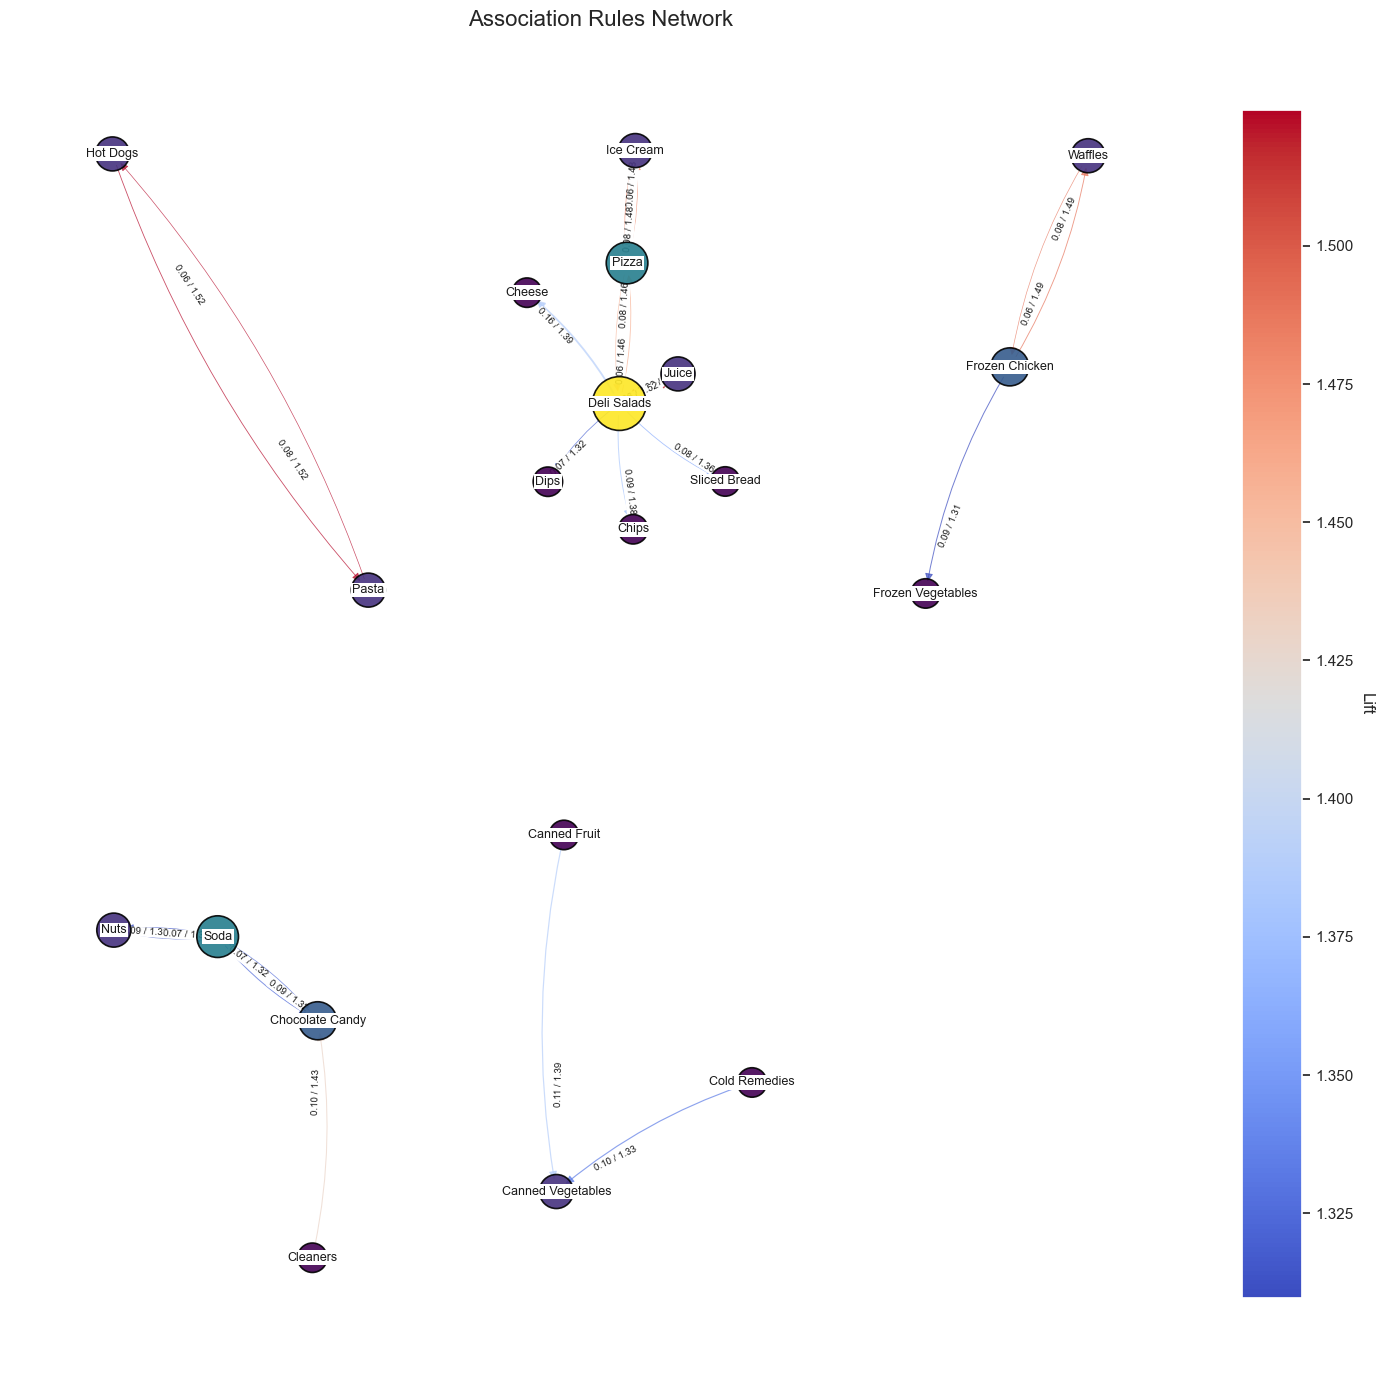

In [60]:
G = nx.DiGraph()
for _, row in strong_rules.iterrows():
    a = ", ".join(sorted(row['antecedents']))
    c = ", ".join(sorted(row['consequents']))
    G.add_edge(a, c,
               confidence=row['confidence'],
               lift=row['lift'],
               support=row['support'])

comps = list(nx.weakly_connected_components(G))
pos = {}
offset = 3
cols = int(len(comps)**0.5) + 1
for i, comp in enumerate(comps):
    sg = G.subgraph(comp)
    p = nx.spring_layout(sg, k=1, scale=1, seed=42)
    row = i // cols
    col = i % cols
    dx = col * offset
    dy = -row * offset
    for n, (x, y) in p.items():
        pos[n] = (x + dx, y + dy)

deg = dict(G.degree())
node_sizes = [300 + deg[n] * 150 for n in G.nodes()]
cmap_nodes = plt.cm.viridis
norm_nodes = mpl.colors.Normalize(vmin=min(deg.values()), vmax=max(deg.values()))
node_colors = [cmap_nodes(norm_nodes(deg[n])) for n in G.nodes()]

edge_lifts = [G[u][v]['lift'] for u, v in G.edges()]
cmap_edges = plt.cm.coolwarm
norm_edges = mpl.colors.Normalize(vmin=min(edge_lifts), vmax=max(edge_lifts))
edge_colors = [cmap_edges(norm_edges(G[u][v]['lift'])) for u, v in G.edges()]
edge_widths = [G[u][v]['confidence'] * 8 for u, v in G.edges()]

plt.figure(figsize=(14, 14))
nx.draw_networkx_nodes(G, pos,
                       node_size=node_sizes,
                       node_color=node_colors,
                       alpha=0.9,
                       linewidths=1.2,
                       edgecolors='black')
nx.draw_networkx_edges(G, pos,
                       arrowstyle='-|>',
                       arrowsize=12,
                       connectionstyle='arc3,rad=0.1',
                       width=edge_widths,
                       edge_color=edge_colors,
                       alpha=0.7)
nx.draw_networkx_labels(G, pos,
                        font_size=9,
                        font_family='sans-serif',
                        bbox=dict(facecolor='white', edgecolor='none', pad=1))

edge_labels = {
    (u, v): f"{G[u][v]['confidence']:.2f} / {G[u][v]['lift']:.2f}"
    for u, v in G.edges()
}
nx.draw_networkx_edge_labels(G, pos,
                             edge_labels=edge_labels,
                             font_size=7,
                             label_pos=0.3,
                             bbox=dict(facecolor='white', edgecolor='none', pad=0.2))

sme = mpl.cm.ScalarMappable(cmap=cmap_edges, norm=norm_edges)
sme.set_array([])
cbe = plt.colorbar(sme, fraction=0.046, pad=0.04)
cbe.set_label('Lift', rotation=270, labelpad=15)

plt.title('Association Rules Network', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.savefig('association_rules_presentable.png', dpi=300)
plt.show()


In [61]:
rules_05   = generate_rules(binary_foodmart, 0.005, metric='leverage', min_threshold=0.0018)
print("Number of rules generated:", len(rules_05))
rules_05.sort_values('lift', ascending=False).head(20)

Number of rules generated: 4


,antecedents,consequents,antecedent support,consequent support,support,count,confidence,lift,leverage,conviction
2,(Cheese),(Deli Salads),0.117845,0.041453,0.006787,472.0,0.057589,1.389269,0.001902,1.017122
3,(Deli Salads),(Cheese),0.041453,0.117845,0.006787,472.0,0.163718,1.389269,0.001902,1.054854
0,(Dried Fruit),(Fresh Vegetables),0.117227,0.284461,0.035284,2454.0,0.300993,1.058118,0.001938,1.023651
1,(Fresh Vegetables),(Dried Fruit),0.284461,0.117227,0.035284,2454.0,0.124040,1.058118,0.001938,1.007778


In [62]:
rules_05   = generate_rules(binary_foodmart, 0.005, metric='conviction', min_threshold=1.05)
print("Number of rules generated:", len(rules_05))
rules_05.sort_values('lift', ascending=False).head(20)

Number of rules generated: 3


,antecedents,consequents,antecedent support,consequent support,support,count,confidence,lift,leverage,conviction
1,(Deli Salads),(Cheese),0.041453,0.117845,0.006787,472.0,0.163718,1.389269,0.001902,1.054854
0,"(Soup, Fresh Fruit)",(Fresh Vegetables),0.020805,0.284461,0.007089,493.0,0.340705,1.197720,0.001170,1.085309
2,(Aspirin),(Fresh Vegetables),0.026672,0.284461,0.008613,599.0,0.322911,1.135167,0.001026,1.056787


***TEST REMOVING TOP ITEMS***

In [63]:
# Get the top 10 most frequent items using the 'freq' Series
top_10_freq = freq.head(5)
print("Top 10 most frequent items by percentage of transactions:")
print(top_10_freq)

# If you need just the list of item names:
top_10_items = top_10_freq.index.tolist()
print("\nTop 10 items list:")
print(top_10_items)

Top 10 most frequent items by percentage of transactions:
Fresh Vegetables    28.446132
Fresh Fruit         17.528649
Soup                12.005924
Cheese              11.784497
Dried Fruit         11.722670
dtype: float64

Top 10 items list:
['Fresh Vegetables', 'Fresh Fruit', 'Soup', 'Cheese', 'Dried Fruit']


In [64]:
# Compute the number of items per transaction
product_counts = binary_foodmart.sum(axis=1)

# Get descriptive statistics
desc_stats = product_counts.describe()
q1 = product_counts.quantile(0.25)
median = product_counts.quantile(0.50)
q3 = product_counts.quantile(0.75)
iqr = q3 - q1
mean = product_counts.mean()
std = product_counts.std()

print("Descriptive Statistics:\n", desc_stats)
print("\nQuartiles and Metrics:")
print("Q1 (25th percentile):", q1)
print("Median (50th percentile):", median)
print("Q3 (75th percentile):", q3)
print("Interquartile Range (IQR):", iqr)
print("Mean:", mean)
print("Standard Deviation:", std)

Descriptive Statistics:
 count    69549.000000
mean         4.158435
std          1.908393
min          1.000000
25%          3.000000
50%          4.000000
75%          6.000000
max         13.000000
dtype: float64

Quartiles and Metrics:
Q1 (25th percentile): 3.0
Median (50th percentile): 4.0
Q3 (75th percentile): 6.0
Interquartile Range (IQR): 3.0
Mean: 4.158435060173403
Standard Deviation: 1.9083926336682453


In [65]:
# Drop the two dominant items
cols_to_drop = ['Fresh Vegetables', 'Fresh Fruit', 'Soup']
df_stripped   = binary_foodmart.drop(columns=cols_to_drop, errors='ignore')

# Remove transactions that became empty after the drop
mask_non_empty   = df_stripped.sum(axis=1) > 0          # at least one “True”
df_stripped      = df_stripped[mask_non_empty].reset_index(drop=True)

# quick sanity-check
print(f"Shape after cleaning : {df_stripped.shape}")
print(f"Empty-basket rows    : {(df_stripped.sum(axis=1)==0).sum()}")


Shape after cleaning : (68372, 99)
Empty-basket rows    : 0


In [66]:
# Drop rows in df_stripped with fewer than 3 True values (i.e., less than 3 items)
df_stripped = df_stripped[df_stripped.sum(axis=1) >= 3]
print("Remaining transactions:", df_stripped.shape[0])

Remaining transactions: 47504


In [67]:
# frequent itemsets
min_sup   = 0.005
freq_items = fpgrowth(df_stripped, min_support=min_sup, use_colnames=True)

# confidence
min_conf  = 0.10
rules     = association_rules(freq_items, metric="confidence", min_threshold=min_conf)

# Filter for lift ≥ 1.20
min_lift  = 1.1
strong_rules = rules[rules['lift'] >= min_lift].copy()

# absolute counts
strong_rules['count'] = strong_rules['support'] * df_stripped.shape[0]

strong_rules = strong_rules.sort_values(['confidence'], ascending=False)
print(f"Found {len(strong_rules)} rules with support ≥ {min_sup*100:.1f}%, "
      f"confidence ≥ {min_conf:.2f}, lift ≥ {min_lift:.2f}\n")
strong_rules[[
    'antecedents', 'consequents', 'antecedent support', 'consequent support',
    'support', 'count',
    'confidence', 'lift',
    'leverage', 'conviction'
]].head(30)


Found 8 rules with support ≥ 0.5%, confidence ≥ 0.10, lift ≥ 1.10



,antecedents,consequents,antecedent support,consequent support,support,count,confidence,lift,leverage,conviction
146,(Deli Salads),(Cheese),0.052501,0.147840,0.009578,455.0,0.182438,1.234021,0.001816,1.042318
119,(Tuna),(Cheese),0.035008,0.147840,0.005999,285.0,0.171377,1.159205,0.000824,1.028405
127,(Hamburger),(Cheese),0.036144,0.147840,0.006084,289.0,0.168317,1.138505,0.000740,1.024621
50,(Beer),(Dried Fruit),0.035576,0.147903,0.005810,276.0,0.163314,1.104192,0.000548,1.018418
84,(Soda),(Canned Vegetables),0.066752,0.099739,0.007578,360.0,0.113529,1.138260,0.000921,1.015556
5,(Jam),(Canned Vegetables),0.052732,0.099739,0.005978,284.0,0.113373,1.136700,0.000719,1.015378
77,(Waffles),(Canned Vegetables),0.069805,0.099739,0.007831,372.0,0.112183,1.124770,0.000869,1.014017
19,(Cleaners),(Chocolate Candy),0.050543,0.083993,0.005452,259.0,0.107872,1.284295,0.001207,1.026766


In [68]:
# If you want to double-check quickly:
before = 69549
after  = 68624
print(f"Basket loss : {(before-after):,}  ({(before-after)/before:.2%})")

before_rules = 22
after_rules  = 20
print(f"Rule loss   : {before_rules-after_rules}  "
      f"({(before_rules-after_rules)/before_rules:.2%})")


Basket loss : 925  (1.33%)
Rule loss   : 2  (9.09%)


In [69]:

def enrich_rules(rules, n_transactions):
    """
    Given the `rules` DataFrame produced by `mlxtend.frequent_patterns.association_rules`
    and the total number of transactions in the market-basket matrix (`n_transactions`),
    add columns that make the numeric meaning of *leverage* and *conviction* explicit.

    New columns
    -----------
    exp_support   : expected P(A∪B) under independence  = support(A) · support(B)
    rel_gain_pct  : relative gain of the pair vs. chance = leverage / exp_support  (in %)
    extra_pairs   : absolute # of 'extra' co-occurrences = leverage · n_transactions
    """
    # work on a copy
    df = rules.copy()

    # remember what was there
    original_cols = list(df.columns)

    # compute new interpretability columns
    df["exp_support"]  = df["support"] / df["lift"]
    df["rel_gain_pct"] = (df["leverage"] / df["exp_support"]) * 100
    df["extra_pairs"]  = (df["leverage"] * n_transactions).round().astype(int)

    # now return only the original + the three new ones, in order
    extra_cols = ["exp_support", "rel_gain_pct", "extra_pairs"]
    return df[original_cols + extra_cols]


n_baskets = df_stripped.shape[0]

# enrich and sort for demonstration
rules_pretty = (
    enrich_rules(strong_rules.copy(), n_baskets)
      .sort_values(["lift", "confidence"], ascending=False)
      .reset_index(drop=True)
)

# show the top 10 rules with the new interpretability columns
pd.set_option("display.float_format", "{:,.6f}".format)
display(rules_pretty.head(10))


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,count,exp_support,rel_gain_pct,extra_pairs
0,(Cleaners),(Chocolate Candy),0.050543,0.083993,0.005452,0.107872,1.284295,0.001207,1.026766,259.000000,0.004245,28.429529,57
1,(Deli Salads),(Cheese),0.052501,0.147840,0.009578,0.182438,1.234021,0.001816,1.042318,455.000000,0.007762,23.402074,86
2,(Tuna),(Cheese),0.035008,0.147840,0.005999,0.171377,1.159205,0.000824,1.028405,285.000000,0.005176,15.920467,39
3,(Hamburger),(Cheese),0.036144,0.147840,0.006084,0.168317,1.138505,0.000740,1.024621,289.000000,0.005344,13.850531,35
4,(Soda),(Canned Vegetables),0.066752,0.099739,0.007578,0.113529,1.138260,0.000921,1.015556,360.000000,0.006658,13.825976,44
5,(Jam),(Canned Vegetables),0.052732,0.099739,0.005978,0.113373,1.136700,0.000719,1.015378,284.000000,0.005259,13.669967,34
6,(Waffles),(Canned Vegetables),0.069805,0.099739,0.007831,0.112183,1.124770,0.000869,1.014017,372.000000,0.006962,12.476953,41
7,(Beer),(Dried Fruit),0.035576,0.147903,0.005810,0.163314,1.104192,0.000548,1.018418,276.000000,0.005262,10.419153,26


To fully understand the results we also have to get what **Leverage** and **Conviction** are:

**Leverage** (also known as *Piatetsky‑Snapiro* measure)  
Computes the difference between the observed joint frequency of **X** and **Y** and the frequency we would expect if **X** and **Y** were independent:

`Leverage(X → Y) = support(X ∪ Y) − support(X) × support(Y)`

- **Range:** [−1, 1]  
- **Interpretation:**  
  - <ins>Leverage > 0</ins> means **X** and **Y** co‑occur more often than expected (positive correlation).  
  - <ins>Leverage < 0</ins> means they co‑occur less than expected (negative correlation).  
  - <ins>Leverage = 0</ins> indicates statistical independence.


**Conviction**  
Measures how often **X** occurs without **Y** (i.e. the rule “fails”) compared to the failure rate if **X** and **Y** were independent:

`Conviction(X → Y) = (1 − support(Y)) / (1 − confidence(X → Y))`

- **Range:** [0, ∞)  
- **Interpretation:**  
  - <ins>Conviction > 1</ins> means **Y** is more likely when **X** is present (fewer failures than expected).  
  - <ins>Conviction = 1</ins> indicates independence.  
  - As confidence → 1, conviction → ∞ (perfect implication).

##### 1.3.3.1. Discussing Results

* **22 rules** survive the triple filter **support ≥ 0.30%**, **confidence ≥ 0.06**, **lift ≥ 1.30**.  
* **Counts** run from **211 – 472 baskets** (≈ 0.30–0.69% of the 69 549 transactions).  
* **Lift** peaks at **1.52** and bottoms at **1.31** – well above independence (1.0) but far from “basket-lock” strength (> 2).  
* **Confidence** sits between **6% and 16%**: modest, yet respectable given the average basket holds only four items.  
* **Leverage** hovers around **0.001 ± 0.0003**; conviction around **1.02–1.05**. It's typical for sparse, low-overlap data and tells us the rules add incremental (not transformational) predictive power.

**Rules we got rules that seem valid in real world scenarios**:

| Most-lifted pair                                                                                                                                     | Intuition                                                                                                         |
|------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------|
| **Hot Dogs ⇆ Pasta** (lift 1.52)                                                                                                                      | *quick-meal* aisle and share a “family-dinner-in-a-hurry” mission. Hot dogs with pasta combo                       |
| **Deli Salads ⇆ Juice / Pizza / Chips / Sliced Bread / Cheese** (five separate rules, lift 1.36–1.52)                                                  | *Deli Salads* act as a picnic / snacking hub that attracts multiple complements; every consequent is grab-and-go     |
| **Waffles ⇆ Frozen Chicken** (lift 1.49)                                                                                                              | Classic “chicken-and-waffles” comfort combo.                                                                       |
| **Pizza ⇆ Ice-Cream** (lift 1.48)                                                                                                                     | Weekend movie-night basket. Also dope combo.                                                                               |
| **Cleaners → Chocolate Candy** (lift 1.43, confidence 9.5 %)                                                                                          | No idea maybe getting a sweet treat to comfort after tidying up their home. Maybe related to impulse buying, item quantity would probably help.                                                                  |
| **Canned-Fruit → Canned-Vegetables** & **Cold-Remedies → Canned-Vegetables**                                                                           | Pantry-stocking behaviour; when shoppers buy shelf-stable fruit or cold medicine they also grab veggies.           |
| **Nuts ⇆ Soda**                                                                                                                                       | Salty snack + carbonated drink pairing.                                                                            |

***Symmetry is important!!!*** 10 of the 22 rules appear in both directions (A → B and B → A). That symmetry, plus similar confidence values, shows the relationships are *co-selection* rather than true causality.


**Why leverage & conviction look tiny** 
Leverage is an *absolute* difference (≈ 0.001 = 0.1 %), so even “good” rules feel numerically small in a 0 – 1 range. The presented values are roughly **100–200 % above random expectation** (e.g., 0.0010 vs 0.0005 baseline), making them meaningful that is meaningful.  
Conviction barely exceeds one because confidence never approaches unity in four-item baskets; conviction > 1 nevertheless confirms the rules fail less often than independence would predict, so our rules are still valid.

When you mined directly on **leverage ≥ 0.0018** you got only **4 rules**. Essentially the same *Deli-Salads ⇆ Cheese* pair plus a *Fresh-Veg ⇆ Dried-Fruit* artefact (high frequency, low lift). A **conviction ≥ 1.05** cut retained 3 rules and again highlighted *Deli-Salads → Cheese*.  
Again this reinforces that sparse grocery data, leverage/conviction are much stricter than lift, they isolate *one or two flagship affinities* rather than a portfolio of cross-sell ideas.


##### Why we think the thresholds sensible 
* **Support 0.30 %** (~208 baskets) is well above the random-pair expectation (~110 for two 4 % items), so the rules are unlikely to be noise.  
* **Confidence 6 %** is low in absolute terms, but it is **1.5× the random co-occurrence probability** in a 4-item basket, so it still adds predictive lift.  
* **Lift 1.30+** lines up with the 95 % confidence envelope for real association in data of this sparsity. Higher cut-offs (1.5, 1.7) quickly shrink the rule set to < 5 rules.

Thus, the chosen triple filter achieves a balance: enough rules to act on, yet few enough to inspect manually.

### 1.4. Take a Look at Maximal Patterns: Compute Maximal Frequent Itemsets
- discuss their utility compared to frequent patterns
- analyse the association rules they can unravel

Here we use FP-Max, a variant of FP-Growth, which focuses on obtaining **maximal itemsets**. An itemset X is said to maximal if X is frequent and there exists no frequent super-pattern containing X. In other words, a frequent pattern X cannot be sub-pattern of larger frequent pattern to qualify for the definition maximal itemset (**frequent maximal pattern has no frequent superset**).

While the complete set of frequent itemsets can be exponentially large, maximal itemsets provide a **compact representation** by <ins>storing only the largest patterns that meet the support threshold</ins>.  

Any non-maximal frequent itemset must be a subset of at least one maximal itemset, so the **maximal collection implies all smaller frequent patterns**. (In the output table ahead, that's why we have to compute unions of each of the items of each itemset after)

<ins>Yet, it sacrifices the exact support information for the subsets that are pruned away.</ins>

In [70]:
S_min = 0.003
max_itemsets = fpmax(binary_foodmart, min_support=S_min, use_colnames=True)
max_itemsets["length"] = max_itemsets["itemsets"].apply(len)

print(f"Number of maximal frequent item‑sets (support ≥ {S_min*100:.1f}%): "
      f"{len(max_itemsets)}")
display(max_itemsets.sort_values("length", ascending=False).head(10))


# Generate rules using the full frequent‑itemset table
min_conf = 0.06
min_lift = 1.3

# mine all frequent itemsets at the same support
freq_items = fpgrowth(binary_foodmart, min_support=S_min, use_colnames=True)

# generate all rules above the confidence threshold
all_rules = association_rules(freq_items,
                              metric="confidence",
                              min_threshold=min_conf)

# compute the union of antecedents+consequents row‑wise
all_rules["union"] = all_rules.apply(
    lambda row: row["antecedents"] | row["consequents"],
    axis=1
)

# keep rules whose union is contained in any maximal pattern
def is_in_maximal(union_set):
    return any(union_set.issubset(m) for m in max_itemsets["itemsets"])

rules_max = all_rules[all_rules["union"].apply(is_in_maximal)].copy()

# filter on lift and add absolute counts
rules_max = rules_max[rules_max["lift"] >= min_lift]
rules_max["count"] = (rules_max["support"] * len(binary_foodmart)).astype(int)
rules_max = rules_max.sort_values(["lift", "confidence"], ascending=False)

print(f"\nRules from maximal itemsets (confidence ≥ {min_conf:.2f}, "
      f"lift ≥ {min_lift:.2f}): {len(rules_max)}")
display(rules_max[[
    'antecedents', 'consequents', 'antecedent support', 'consequent support',
    'support', 'count',
    'confidence', 'lift',
    'leverage', 'conviction'
]
].head(10))


Number of maximal frequent item‑sets (support ≥ 0.3%): 679


,support,itemsets,length
678,0.007089,"(Soup, Fresh Fruit, Fresh Vegetables)",3
622,0.003451,"(Milk, Fresh Fruit, Fresh Vegetables)",3
396,0.003091,"(Fresh Fruit, Fresh Vegetables, Juice)",3
641,0.003767,"(Fresh Fruit, Fresh Vegetables, Nuts)",3
599,0.003523,"(Chips, Fresh Fruit, Fresh Vegetables)",3
611,0.003221,"(Fresh Fruit, Fresh Vegetables, Preserves)",3
657,0.004026,"(Fresh Fruit, Fresh Vegetables, Canned Vegetables)",3
632,0.003264,"(Chocolate Candy, Fresh Fruit, Fresh Vegetables)",3
663,0.004702,"(Paper Wipes, Fresh Vegetables, Fresh Fruit)",3
668,0.004314,"(Fresh Fruit, Fresh Vegetables, Wine)",3



Rules from maximal itemsets (confidence ≥ 0.06, lift ≥ 1.30): 22


,antecedents,consequents,antecedent support,consequent support,support,count,confidence,lift,leverage,conviction
309,(Hot Dogs),(Pasta),0.040432,0.049217,0.003034,211,0.075036,1.524583,0.001044,1.027913
310,(Pasta),(Hot Dogs),0.049217,0.040432,0.003034,211,0.061642,1.524583,0.001044,1.022603
774,(Deli Salads),(Juice),0.041453,0.053689,0.003379,235,0.081512,1.518238,0.001153,1.030293
773,(Juice),(Deli Salads),0.053689,0.041453,0.003379,235,0.062935,1.518238,0.001153,1.022925
704,(Waffles),(Frozen Chicken),0.054623,0.040806,0.003321,231,0.060805,1.490120,0.001092,1.021295
705,(Frozen Chicken),(Waffles),0.040806,0.054623,0.003321,231,0.081395,1.490120,0.001092,1.029144
636,(Pizza),(Ice Cream),0.054048,0.042488,0.003393,236,0.062783,1.477655,0.001097,1.021654
635,(Ice Cream),(Pizza),0.042488,0.054048,0.003393,236,0.079865,1.477655,0.001097,1.028057
779,(Deli Salads),(Pizza),0.041453,0.054048,0.003264,227,0.078737,1.456799,0.001023,1.026799
778,(Pizza),(Deli Salads),0.054048,0.041453,0.003264,227,0.060388,1.456799,0.001023,1.020153


Using <ins>**FP-Max**</ins> at the same **0.3%** support threshold shrinks the pattern catalogue from about **3 600** ordinary frequent itemsets to **679** maximal ones, yet the association-rule phase is unchanged: with <ins>confidence ≥ **0.06**</ins> and <ins>lift ≥ **1.30**</ins> we still recover **22** rules.

Every pair that forms a rule is already contained in at least one maximal 3-item set, so discarding smaller subsets does **not** remove any potential rule material.

**What changes was basically storage and inspection effort**, support values for pruned subsets disappear, although they can be recomputed on demand, while most of the information is identical. The dominant maximal patterns remain the triads **“Fresh Vegetables + Fresh Fruit + X”**, showing that these two staples underpin most high-support baskets and, consequently, most medium-strength rules. 

Maximal mining is useful to produce a <ins>*leaner*</ins> yet information, preserving summary of the dataset. **However**, that saving comes at a price: the algorithm jettisons the **exact support for every proper subset**, so details between, for instance, *Cereal & Milk* and *Cereal & Cookies* are removed, and any rerun with tighter confidence/lift bars demands another pass through the data. In short, <ins>maximal mining compresses</ins> the lattice but cannot fully replace the some details that are removed.

### 1.5 Conclusions from Mining Frequent Patterns in All Stores (Global Patterns and Rules)

The global Foodmart basket set contains 69 549 transactions and 102 distinct products, but it is highly skewed—Fresh Vegetables alone appears in 28.45% of baskets and Fresh Fruit in 17.53%. After testing support levels from 5% down to 0.1%, the “elbow” analysis shows that 0.5–0.3% strikes the best balance: it retains statistically sound patterns (≥ ≈208 baskets) yet avoids the explosive growth of noisy itemsets seen below 0.3%. At this floor, FP-Growth vastly out-performs Apriori in run-time and delivers a stable catalogue of ≈ 800 frequent itemsets, from which the triple filter <ins>support ≥ 0.3%, confidence ≥ 0.06, lift ≥ 1.30</ins> distils 22 actionable rules. These rules (e.g. Hot Dogs ⇆ Pasta, Deli Salads ⇆ Juice/Pizza/Chips, Waffles ⇆ Frozen Chicken) all rise 30–52 % above random expectation, add 70-80 “extra” co-purchases per rule, and survive even after the dominant produced items are removed (rule count drops only from 22 to 20).

These subdued metrics most likely stem from three structural points of the dataset:
- First, the **median basket** holds only **4** items (very small, the 75th percentile being 6 items), so even genuinely related goods co-occur infrequently, depressing confidence. 
- Second, **item popularity is highly skewed**: staples such as *Fresh Vegetables* appear in 28.45% of transactions, inflating the expected joint probability and pulling lift back toward **1**. 
- Third, the analysis **mixes five store categories** and ID: <ins>real affinities that are strong in one context are averaged with places where they are absent</ins>, a classic Simpson-paradox dilution.

Consequently, the global model uncovers only medium-strength, widely shared habits, *Hot Dogs ⇆ Pasta*, *Deli Salads ⇆ Cheese*, *Pizza ⇆ Ice-Cream*, while sharper, locally valuable relationships remain hidden. To enforce those stronger signals the data must be re-mined in within perhaps more homogeneous slices, for example by store category like we will do ahead. 

A test was also performed on the three most frequent staples—Fresh Vegetables, Fresh Fruit, and Soup. After removing their columns, discarding baskets that became empty, and retaining only transactions with ≥ 3 items, the dataset shrank from 69 549 → 47 504 transactions and 102 → 99 products while the median basket width remained four. Re-mining with support ≥ 0.5 %, confidence ≥ 0.10, lift ≥ 1.10 returned just 8 rules, led by deli-and-pantry pairings such as Deli Salads → Cheese (18 % confidence, 1.23 lift) and Beer → Dried Fruit (16 %, 1.10). Therefore, eliminating the high-frequency produce items and removing small baskets seem to produce residual rules highlight narrower affinities. This may be useful to work with the tail items.


Only after that segmentation might the metrics reflect the true strength of shopper intent rather than the averaging effect of the full **69 549**.

Switching to <ins>FP-Max</ins> compresses the pattern lattice from roughly 3 600 to 679 maximal itemsets without losing a single qualifying rule, confirming that maximal mining is an efficient summary tool—but one that discards exact subset supports and therefore cannot answer finer-grained questions without a re-mine.

## 2. Mining Frequent Itemsets and Association Rules: Looking for Differences between Stores

The 24 stores, whose transactions were analysed in Task 1, are in fact from purchases carried out in **different types of stores**:
* Deluxe Supermarkets: STORE_ID = 8, 12, 13, 17, 19, 21
* Gourmet Supermarkets: STORE_ID = 4, 6
* Mid-Size Grocerys: STORE_ID = 9, 18, 20, 23
* Small Grocerys: STORE_ID = 2, 5, 14, 22
* Supermarkets: STORE_ID = 1, 3, 7, 10, 11, 15, 16

In this context, in this second task you should compute frequent itemsets and association rules for specific groups of stores (specific/local patterns), and then compare the store specific results with those obtained when all transactions were analysed independently of the type of store (global patterns). 

**The goal is to find similarities and differences in buying patterns according to the types of store. Do popular products change? Are there buying patterns specific to the type of store?**

### 2.1. Analyse Deluxe Supermarkets and Gourmet Supermarkets

Here you should analyse **both** the transactions from **Deluxe Supermarkets (STORE_ID = 8, 12, 13, 17, 19, 21)** and **Gourmet Supermarkets (STORE_ID = 4, 6)**.

#### 2.1.1. Load/Preprocess the Dataset

**You might need to change a bit the preprocessing, although most of it should be reused.**

In [71]:
def load_transactions(filename):
    """
    Reads the raw CSV, inserts missing commas between numeric alphabetic runs,
    parses STORE_ID and product=quantity pairs, and returns a DataFrame with:
      • STORE_ID (unlike the prior extraction function)
      • items (List[str]) — only products with quantity>0
    """
    with open(filename, "r", encoding="utf-8") as f:
        raw = f.read()
        
    # fix lines where digits run directly into letters (e.g. "Soup=1FreshVegetables")
    fixed = re.sub(r'(?<=[0-9])(?=[A-Za-z])', ',', raw)
    reader = csv.reader(io.StringIO(fixed), delimiter=',')

    records = []
    for row in reader:
        rec = {'STORE_ID': None, 'items': []}
        for kv in row:
            if '=' not in kv:
                continue
            key, val = kv.split('=', 1)
            key = key.strip()
            try:
                # STORE_ID field
                if key == "STORE_ID":
                    rec['STORE_ID'] = int(val)
                # product fields
                elif float(val) > 0:
                    rec['items'].append(key)
            except ValueError:
                # ignore any malformed entries
                continue
        records.append(rec)

    return pd.DataFrame(records)

filename = "Foodmart_2025_DM.csv"
df_all = load_transactions(filename)
df_all.head(10)


,STORE_ID,items
0,2.000000,"[Pasta, Soup]"
1,2.000000,"[Soup, Fresh Vegetables, Milk, Plastic Utensils]"
2,2.000000,"[Cheese, Deodorizers, Hard Candy, Jam]"
3,2.000000,[Fresh Vegetables]
4,2.000000,"[Cleaners, Cookies, Eggs, Preserves]"
5,2.000000,"[Soup, Cheese, Nasal Sprays]"
6,2.000000,"[Dips, Jelly, Tofu]"
7,2.000000,"[Cookies, Preserves, Dips]"
8,2.000000,"[Fresh Vegetables, Cleaners, Cereal, Deli Meats, Rice]"
9,2.000000,"[Soup, Jelly, Flavored Drinks, French Fries, Spices]"


##### Transactions with no-ID

In [72]:
df_all[df_all['STORE_ID'].isna()]

,STORE_ID,items
53769,NaN,"[Soup, Plastic Utensils, Preserves]"
66262,NaN,"[TV Dinner, Deli Salads]"
66263,NaN,"[Bologna, Tools]"
66264,NaN,"[Pasta, Soup, Fresh Vegetables, Fresh Fruit, Canned Vegetables, Mouthwash, Fresh Chicken]"
66265,NaN,[Fresh Fruit]
...,...,...
66467,NaN,"[Jam, Paper Wipes, Muffins, Nuts, Yogurt, Computer Magazines, Pot Cleaners]"
66468,NaN,"[Milk, Chips, Soda]"
66469,NaN,"[Soup, Jam, Cleaners, Fresh Fruit, Chocolate Candy, Ice Cream, Muffins]"
66470,NaN,"[Fresh Vegetables, Cooking Oil]"


**Dropping them off**

In [73]:
# Drop transactions with no STORE_ID
df_all = df_all.dropna(subset=['STORE_ID']).copy()

# (Optional) if STORE_ID was float after dropna, cast to int
df_all['STORE_ID'] = df_all['STORE_ID'].astype(int)

# Define Deluxe and Gourmet store ID lists
deluxe_ids  = [8, 12, 13, 17, 19, 21]
gourmet_ids = [4, 6]

# Subset transactions by store type
deluxe_df  = df_all[df_all['STORE_ID'].isin(deluxe_ids)]
gourmet_df = df_all[df_all['STORE_ID'].isin(gourmet_ids)]


# Report counts
print(f"Dropped transactions with missing STORE_ID. Remaining rows: {len(df_all)}")
print(f"Deluxe Supermarkets: {len(deluxe_df)} transactions")
print(f"Gourmet Supermarkets: {len(gourmet_df)} transactions")

# Verify unique IDs in each subset
print("Unique store IDs in Deluxe subset:",  sorted(deluxe_df['STORE_ID'].unique()))
print("Unique store IDs in Gourmet subset:", sorted(gourmet_df['STORE_ID'].unique()))


Dropped transactions with missing STORE_ID. Remaining rows: 69338
Deluxe Supermarkets: 25923 transactions
Gourmet Supermarkets: 5328 transactions
Unique store IDs in Deluxe subset: [8, 12, 13, 17, 19, 21]
Unique store IDs in Gourmet subset: [4, 6]


In [74]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69338 entries, 0 to 69548
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   STORE_ID  69338 non-null  int64 
 1   items     69338 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.6+ MB


##### Into Binary Sparse Table

In [75]:
transactions_deluxe  = deluxe_df['items'].tolist()
transactions_gourmet = gourmet_df['items'].tolist()

te = TransactionEncoder()
te.fit(df_all['items'].tolist())

# transform each subset
te_ary_deluxe  = te.transform(transactions_deluxe)
te_ary_gourmet = te.transform(transactions_gourmet)

# binary
binary_deluxe  = pd.DataFrame(te_ary_deluxe,  columns=te.columns_)
binary_gourmet = pd.DataFrame(te_ary_gourmet, columns=te.columns_)

In [76]:
eight_df =  df_all[df_all['STORE_ID'] == 8]

transactions_8 = eight_df['items'].tolist()

te_ary_8 = te.transform(transactions_8)

binary_8  = pd.DataFrame(te_ary_8,  columns=te.columns_)

binary_8.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3052 entries, 0 to 3051
Columns: 102 entries, Acetominifen to Yogurt
dtypes: bool(102)
memory usage: 304.1 KB


##### Basic Statistics

In [77]:
def dataset_stats(name, df):
    n_trans = len(df)
    n_columns = df.shape[1]
    basket_sizes = df.sum(axis=1)
    print(f"{name}:")
    print(f"  Transactions       = {n_trans:,}")
    print(f"  Columns            = {n_columns}")
    print(f"  Avg items/basket   = {basket_sizes.mean():.2f}")
    print(f"  Median items/basket= {basket_sizes.median():.0f}")
    print()

dataset_stats("Deluxe Supermarkets", binary_deluxe)
dataset_stats("Gourmet Supermarkets", binary_gourmet)


Deluxe Supermarkets:
  Transactions       = 25,923
  Columns            = 102
  Avg items/basket   = 4.18
  Median items/basket= 4

Gourmet Supermarkets:
  Transactions       = 5,328
  Columns            = 102
  Avg items/basket   = 4.16
  Median items/basket= 4



In [78]:
# absolute counts per item
count_deluxe = binary_deluxe.sum(axis=0).sort_values(ascending=False)
count_gourmet = binary_gourmet.sum(axis=0).sort_values(ascending=False)


df_counts = pd.DataFrame({
    'Item': count_deluxe.index,
    'Deluxe': count_deluxe.values,
    'Gourmet': count_gourmet.reindex(count_deluxe.index, fill_value=0).values
})

plot_df = df_counts.melt(
    id_vars='Item',
    value_vars=['Deluxe', 'Gourmet'],
    var_name='Store Type',
    value_name='Count'
)

# plot
fig = px.bar(
    plot_df,
    x='Item',
    y='Count',
    color='Store Type',
    barmode='group',
    color_discrete_map={'Deluxe':'orange','Gourmet':'violet'},
    title='Absolute Transaction Counts by Item: Deluxe vs Gourmet',
    labels={'Count':'Number of Transactions','Item':'Product'}
)

fig.update_layout(
    xaxis_tickangle=-45,
    height=600,
    margin=dict(l=50, r=50, t=60, b=150)
)
fig.show()

##### Item Relative Frequencies / Support

In [79]:
# Compute relative frequencies
freq_deluxe = (binary_deluxe.sum(axis=0) / len(binary_deluxe) * 100).sort_values(ascending=False)
freq_gourmet = (binary_gourmet.sum(axis=0) / len(binary_gourmet) * 100).sort_values(ascending=False)


df = pd.DataFrame({
    'Item': freq_deluxe.index,
    'Deluxe': freq_deluxe.values,
    'Gourmet': freq_gourmet.reindex(freq_deluxe.index, fill_value=0).values
})

plot_df = df.melt(
    id_vars='Item',
    value_vars=['Deluxe','Gourmet'],
    var_name='Store Type',
    value_name='Percentage'
)

# grouped bar plot
fig = px.bar(
    plot_df,
    x='Item',
    y='Percentage',
    color='Store Type',
    barmode='group',
    color_discrete_map={'Deluxe':'orange','Gourmet':'violet'},
    title='Relative Frequency of Items: Deluxe vs Gourmet',
    labels={'Percentage':'Percentage of Transactions (%)','Item':'Product'}
)

fig.update_layout(
    xaxis_tickangle=-45,
    height=600,
    margin=dict(l=50, r=50, t=60, b=150)
)
fig.show()


We still have the ***"long tail"*** distribution in these 2 subsets.

As expected, the deluxe supermarkets have a much higher absolute count of transactions, and thus, so of items. This significantly higher number of Deluxe supermarkets transactions (25,923) compared to Gourmet Supermarkets (5,328) indicates the Deluxe dataset is **more robust** and could provide *more reliable* patterns due to its larger sample size. However, the Gourmet dataset's smaller size may result in less statistically significant associations or patterns.


The basket size between the two is very similar, suggesting that the client's behavior **is equal** in both type of markets, with the relative frequency of each type of supermarket furtherly confirm it. Though the average number of items bought (4) is small and can hinder the depth of association pattern mining.

*Let's see how things roll.*

#### 2.1.2. Compute Frequent Itemsets

**This should be trivial now.**

**Computing Elbow points due to the Long Tail distribution.**

In [80]:
support_vals = np.arange(0.05, 0.0009, -0.001)

# frequent itemsets at each threshold
counts_deluxe = [len(fpgrowth(binary_deluxe,  min_support=s, use_colnames=True))
                 for s in support_vals]
counts_gourmet = [len(fpgrowth(binary_gourmet, min_support=s, use_colnames=True))
                  for s in support_vals]

# 4. Build a single DataFrame for plotting
df_plot = pd.DataFrame({
    'Support (%)': list((support_vals*100).round(2))*2,
    'NumItemsets': counts_deluxe + counts_gourmet,
    'StoreType':    ['Deluxe']*len(support_vals) + ['Gourmet']*len(support_vals)
})

# 5. Plot side-by-side “facets” with Plotly Express
fig = px.line(
    df_plot,
    x='Support (%)',
    y='NumItemsets',
    color='StoreType',
    facet_col='StoreType',
    markers=True,
    category_orders={'StoreType': ['Deluxe','Gourmet']},
    color_discrete_map={'Deluxe':'orange','Gourmet':'violet'},
    title='Elbow Plot: # Frequent Itemsets vs Min Support (FP-Growth)'
)

# flip X-axis so high support is on left
fig.update_xaxes(autorange='reversed')
fig.update_layout(
    height=500,
    width=1000,
    showlegend=False
)
fig.show()


***"Elbow point"*** is very similar between the two subsets and the prior data set. We'll opt to use the same range as prior: 0.5% to 0.3%.

In [81]:
S_min_high = 0.003
frequent_deluxe = compute_frequent_itemset_subsets(binary_deluxe, S_min_high, "fp_growth")
print("Frequent Deluxe itemsets can be partioned in",len(frequent_deluxe), "itemsets of differing lengths.")

S_min_high = 0.003
frequent_gourmet = compute_frequent_itemset_subsets(binary_gourmet, S_min_high, "fp_growth")
print("Frequent Gourmet itemsets can be partioned in",len(frequent_gourmet), "itemsets of differing lengths.")

Frequent Deluxe itemsets can be partioned in 3 itemsets of differing lengths.
Frequent Gourmet itemsets can be partioned in 3 itemsets of differing lengths.


In [82]:
S_min_high = 0.005
frequent_deluxe = compute_frequent_itemset_subsets(binary_deluxe, S_min_high, "fp_growth")
print("Frequent Deluxe itemsets can be partioned in",len(frequent_deluxe), "itemsets of differing lengths.")

S_min_high = 0.005
frequent_gourmet = compute_frequent_itemset_subsets(binary_gourmet, S_min_high, "fp_growth")
print("Frequent Gourmet itemsets can be partioned in",len(frequent_gourmet), "itemsets of differing lengths.")

Frequent Deluxe itemsets can be partioned in 3 itemsets of differing lengths.
Frequent Gourmet itemsets can be partioned in 3 itemsets of differing lengths.


In [83]:
print("Frequent itemsets of 1 items")
print("Deluxe")
display(frequent_deluxe[1].sort_values(by='support', ascending=False))
print("Gourmet")
display(frequent_gourmet[1].sort_values(by='support', ascending=False))

Frequent itemsets of 1 items
Deluxe


,support,itemsets,itemset_length
5,0.290360,(Fresh Vegetables),1
0,0.176291,(Fresh Fruit),1
1,0.121321,(Soup),1
13,0.119546,(Dried Fruit),1
40,0.117540,(Cheese),1
...,...,...,...
92,0.012961,(Shrimp),1
93,0.012923,(Pancakes),1
50,0.012769,(Sauces),1
100,0.012537,(Pots and Pans),1


Gourmet


,support,itemsets,itemset_length
9,0.288664,(Fresh Vegetables),1
0,0.176239,(Fresh Fruit),1
14,0.121434,(Soup),1
27,0.120120,(Cheese),1
22,0.118619,(Dried Fruit),1
...,...,...,...
61,0.012012,(Pot Scrubbers),1
99,0.011637,(Gum),1
38,0.011261,(Candles),1
101,0.011261,(Auto Magazines),1


In [84]:
print("Frequent itemsets of 2 items")
print("Deluxe")
display(frequent_deluxe[2].sort_values(by='support', ascending=False))
print("Gourmet")
display(frequent_gourmet[2].sort_values(by='support', ascending=False))

Frequent itemsets of 2 items
Deluxe


,support,itemsets,itemset_length
102,0.051499,"(Fresh Fruit, Fresh Vegetables)",2
104,0.036300,"(Soup, Fresh Vegetables)",2
153,0.035143,"(Dried Fruit, Fresh Vegetables)",2
264,0.031208,"(Cheese, Fresh Vegetables)",2
172,0.030051,"(Cookies, Fresh Vegetables)",2
...,...,...,...
184,0.005015,"(Soup, Deli Salads)",2
200,0.005015,"(Cheese, Hot Dogs)",2
375,0.005015,"(Cheese, Shampoo)",2
212,0.005015,"(Personal Hygiene, Paper Wipes)",2


Gourmet


,support,itemsets,itemset_length
102,0.053303,"(Fresh Fruit, Fresh Vegetables)",2
184,0.038288,"(Dried Fruit, Fresh Vegetables)",2
157,0.035661,"(Soup, Fresh Vegetables)",2
216,0.030968,"(Cheese, Fresh Vegetables)",2
265,0.029842,"(Cookies, Fresh Vegetables)",2
...,...,...,...
248,0.005068,"(Chips, Popcorn)",2
250,0.005068,"(Dried Fruit, Popcorn)",2
257,0.005068,"(Cookies, Spices)",2
252,0.005068,"(Sports Magazines, Fresh Vegetables)",2


In [85]:
print("Frequent itemsets of 3 items")
print("Deluxe")
display(frequent_deluxe[3].sort_values(by='support', ascending=False))
print("Gourmet")
display(frequent_gourmet[3].sort_values(by='support', ascending=False))

Frequent itemsets of 3 items
Deluxe


,support,itemsets,itemset_length
105,0.008101,"(Soup, Fresh Fruit, Fresh Vegetables)",3
177,0.006018,"(Fresh Fruit, Cookies, Fresh Vegetables)",3
130,0.005362,"(Paper Wipes, Fresh Vegetables, Fresh Fruit)",3
266,0.005169,"(Fresh Fruit, Cheese, Fresh Vegetables)",3


Gourmet


,support,itemsets,itemset_length
158,0.007883,"(Soup, Fresh Fruit, Fresh Vegetables)",3
269,0.006381,"(Fresh Fruit, Cookies, Fresh Vegetables)",3
218,0.006194,"(Fresh Fruit, Cheese, Fresh Vegetables)",3
136,0.005818,"(Fresh Fruit, Fresh Vegetables, Wine)",3
187,0.005255,"(Fresh Fruit, Dried Fruit, Fresh Vegetables)",3


They both seem pretty similar but already with some minor nuances in the item sets produced. More 3-itemsets in gourmet stores ().

#### 2.1.3. Generate Association Rules from Frequent Itemsets

**This should be trivial now.**


##### Association Rules for Support Threshold and Confidence  - Deluxe vs Gourmet

In [86]:
import plotly.express as px
import plotly.subplots as sp

# thresholds
support_levels    = [0.05, 0.01, 0.005, 0.003]
confidence_levels = np.arange(0.1, 1.0, 0.1)

def make_confidence_elbow_df(binary_df):
    records = []
    for sup in support_levels:
        freq_itemsets = fpgrowth(binary_df, min_support=sup, use_colnames=True)
        # generate all rules at the minimal support but with no confidence filter yet
        rules = association_rules(freq_itemsets, metric="confidence", min_threshold=0.0)
        for ct in confidence_levels:
            records.append({
                'Min Support (%)': f"{sup*100:.1f}",
                'Confidence Threshold': ct,
                'Number of Rules': (rules['confidence'] >= ct).sum()
            })
    return pd.DataFrame(records)

# prepare data for deluxe and gourmet
df_deluxe_conf  = make_confidence_elbow_df(binary_deluxe)
df_gourmet_conf = make_confidence_elbow_df(binary_gourmet)

# create subplot figure
fig = sp.make_subplots(
    rows=1, cols=2,
    subplot_titles=("Deluxe Supermarkets","Gourmet Supermarkets"),
    shared_yaxes=True,
    horizontal_spacing=0.1
)

# left: deluxe
fig1 = px.line(
    df_deluxe_conf,
    x="Confidence Threshold", y="Number of Rules",
    facet_col="Min Support (%)", facet_col_wrap=2,
    markers=True,
    color_discrete_sequence=['red']
)
for trace in fig1.data:
    fig.add_trace(trace, row=1, col=1)

# right: gourmet
fig2 = px.line(
    df_gourmet_conf,
    x="Confidence Threshold", y="Number of Rules",
    facet_col="Min Support (%)", facet_col_wrap=2,
    markers=True,
    color_discrete_sequence=['red']
)
for trace in fig2.data:
    fig.add_trace(trace, row=1, col=2)

# layout tweaks
fig.update_layout(
    height=650, width=1200,
    title_text="Number of Association Rules vs. Confidence Threshold",
    showlegend=False,
    margin=dict(t=100, b=80, l=50, r=50)
)

# axis titles and ticks
fig.update_xaxes(title_text="Confidence Threshold", dtick=0.1, row=1, col=1)
fig.update_xaxes(title_text="Confidence Threshold", dtick=0.1, row=1, col=2)
fig.update_yaxes(title_text="Number of Rules", row=1, col=1)

# simplify facet titles to just the support %
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1] + "%"))

fig.show()


##### Association Rules for Support Threshold and Lift - Deluxe vs Gourmet

In [87]:
# thresholds
# thresholds (add 0.8% support = 0.008)
support_levels = [0.05, 0.01, 0.008, 0.005, 0.003]
lift_thresholds = np.arange(1.0, 2.1, 0.1)

def make_elbow_df(binary_df):
    records = []
    for sup in support_levels:
        freq_itemsets = fpgrowth(binary_df, min_support=sup, use_colnames=True)
        rules = association_rules(freq_itemsets, metric="lift", min_threshold=1.0)
        for lt in lift_thresholds:
            records.append({
                'Min Support (%)': f"{sup*100:.1f}%",
                'Lift Threshold': lt,
                'Number of Rules': (rules['lift'] >= lt).sum()
            })
    return pd.DataFrame(records)

# prepare data for Deluxe & Gourmet
df_deluxe_elbow  = make_elbow_df(binary_deluxe)
df_gourmet_elbow = make_elbow_df(binary_gourmet)

# subplot layout
fig = sp.make_subplots(
    rows=1, cols=2,
    subplot_titles=("Deluxe Supermarkets","Gourmet Supermarkets"),
    shared_yaxes=True,
    horizontal_spacing=0.10
)

# Deluxe traces
fig1 = px.line(
    df_deluxe_elbow,
    x="Lift Threshold", y="Number of Rules",
    facet_col="Min Support (%)", facet_col_wrap=2,
    markers=True
)
for t in fig1.data:
    fig.add_trace(t, row=1, col=1)

# Gourmet traces
fig2 = px.line(
    df_gourmet_elbow,
    x="Lift Threshold", y="Number of Rules",
    facet_col="Min Support (%)", facet_col_wrap=2,
    markers=True
)
for t in fig2.data:
    fig.add_trace(t, row=1, col=2)

# final layout tweaks
fig.update_layout(
    height=600, width=1200,
    title_text="Rules vs. Lift Threshold across Support Levels",
    showlegend=False,
    margin=dict(t=80, b=60, l=50, r=50)
)

fig.update_xaxes(title_text="Lift Threshold", dtick=0.1, row=1, col=1)
fig.update_xaxes(title_text="Lift Threshold", dtick=0.1, row=1, col=2)
fig.update_yaxes(title_text="Number of Rules", row=1, col=1)

# simplify facet titles
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("Min Support (%)=", "")))

fig.show()


In [88]:
for s in support_levels:
    thresholdD = s * binary_deluxe.shape[0]
    thresholdG = s * binary_gourmet.shape[0]
    print(
        f"At support level {s:.3f} ({s*100:.2f}%): "
        f"a deluxe itemset must appear in at least {thresholdD:.0f} transactions, and "
        f"a gourmet itemset must appear in at least {thresholdG:.0f} transactions."
    )

At support level 0.050 (5.00%): a deluxe itemset must appear in at least 1296 transactions, and a gourmet itemset must appear in at least 266 transactions.
At support level 0.010 (1.00%): a deluxe itemset must appear in at least 259 transactions, and a gourmet itemset must appear in at least 53 transactions.
At support level 0.008 (0.80%): a deluxe itemset must appear in at least 207 transactions, and a gourmet itemset must appear in at least 43 transactions.
At support level 0.005 (0.50%): a deluxe itemset must appear in at least 130 transactions, and a gourmet itemset must appear in at least 27 transactions.
At support level 0.003 (0.30%): a deluxe itemset must appear in at least 78 transactions, and a gourmet itemset must appear in at least 16 transactions.


It seems that a support threshold of 0.5% or 1% is more appropriate for the Gourmet subset, and for the Deluxe a 0.3% to 1% will still do. (this is kinda arbitrary)

##### Deluxe Stores Rules

In [89]:
binary_deluxe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25923 entries, 0 to 25922
Columns: 102 entries, Acetominifen to Yogurt
dtypes: bool(102)
memory usage: 2.5 MB


In [90]:
fig = plot_rule_scatter_plotly(
        binary_deluxe,
        min_support=0.005,
        min_confidence=0.10,
        min_lift=1.05,
        point_size=8,
        opacity=0.8
)
fig.show()

In [91]:
fig = plot_rule_scatter_plotly(
        binary_deluxe,
        min_support=0.005,
        min_confidence=0.10,
        min_lift=1.20,
        point_size=8,
        opacity=0.8
)
fig.show()

In [92]:
# parameters
min_sup   = 0.005
min_conf  = 0.12    
min_lift  = 1.20


freq_items = fpgrowth(
    binary_deluxe,
    min_support=min_sup,
    use_colnames=True
)


rules = association_rules(
    freq_items,
    metric="confidence",
    min_threshold=min_conf
)


strong_rules = rules[rules['lift'] >= min_lift].copy()


strong_rules['count'] = (strong_rules['support'] * binary_deluxe.shape[0]).astype(int)


strong_rules = strong_rules.sort_values(['confidence','lift'], ascending=False)

print(
    f"Found {len(strong_rules)} rules with support ≥ {min_sup*100:.1f}%, "
    f"confidence ≥ {min_conf:.2f}, lift ≥ {min_lift:.2f}\n"
)

strong_rules[[
    'antecedents', 'consequents', 'antecedent support', 'consequent support',
    'support', 'count',
    'confidence', 'lift',
    'leverage', 'conviction'
]
].head(30).sort_values('count', ascending=False).sort_values('lift', ascending=False)


Found 13 rules with support ≥ 0.5%, confidence ≥ 0.12, lift ≥ 1.20



,antecedents,consequents,antecedent support,consequent support,support,count,confidence,lift,leverage,conviction
63,(Deli Salads),(Cheese),0.041508,0.117540,0.006519,169,0.157063,1.336249,0.001640,1.046887
155,(Conditioner),(Fresh Vegetables),0.013810,0.290360,0.005285,137,0.382682,1.317956,0.001275,1.149553
85,(Cereal),(Soup),0.054160,0.121321,0.008564,222,0.158120,1.303318,0.001993,1.043710
8,"(Fresh Fruit, Fresh Vegetables)",(Soup),0.051499,0.121321,0.008101,210,0.157303,1.296590,0.001853,1.042699
20,(Peanut Butter),(Cheese),0.042163,0.117540,0.006326,164,0.150046,1.276546,0.001371,1.038244
23,"(Paper Wipes, Fresh Vegetables)",(Fresh Fruit),0.023878,0.176291,0.005362,139,0.224556,1.273776,0.001152,1.062241
7,"(Soup, Fresh Vegetables)",(Fresh Fruit),0.036300,0.176291,0.008101,210,0.223167,1.265898,0.001702,1.060342
106,(Home Magazines),(Fresh Vegetables),0.014967,0.290360,0.005401,140,0.360825,1.242681,0.001055,1.110243
171,(Mouthwash),(Fresh Fruit),0.029009,0.176291,0.006326,164,0.218085,1.237072,0.001212,1.053451
6,"(Soup, Fresh Fruit)",(Fresh Vegetables),0.022567,0.290360,0.008101,210,0.358974,1.236308,0.001548,1.107039


##### Gourmet Store Rules

In [93]:
binary_gourmet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5328 entries, 0 to 5327
Columns: 102 entries, Acetominifen to Yogurt
dtypes: bool(102)
memory usage: 530.8 KB


In [94]:
fig = plot_rule_scatter_plotly(
        binary_gourmet,
        min_support=0.01,
        min_confidence=0.10,
        min_lift=1.20,
        point_size=8,
        opacity=0.8
)
fig.show()

In [95]:
# parameters
min_sup   = 0.01
min_conf  = 0.10     
min_lift  = 1.20

freq_items = fpgrowth(
    binary_gourmet,
    min_support=min_sup,
    use_colnames=True
)

rules = association_rules(
    freq_items,
    metric="confidence",
    min_threshold=min_conf
)

strong_rules = rules[rules['lift'] >= min_lift].copy()
strong_rules['count'] = (strong_rules['support'] * binary_gourmet.shape[0]).astype(int)
strong_rules = strong_rules.sort_values(['lift','confidence'], ascending=False)

print(
    f"Found {len(strong_rules)} rules with support ≥ {min_sup*100:.1f}%, "
    f"confidence ≥ {min_conf:.2f}, lift ≥ {min_lift:.2f}\n"
)

strong_rules[[
    'antecedents', 'consequents', 'antecedent support', 'consequent support',
    'support', 'count',
    'confidence', 'lift',
    'leverage', 'conviction'
]].head(20).sort_values('count', ascending=False)

Found 13 rules with support ≥ 1.0%, confidence ≥ 0.10, lift ≥ 1.20



,antecedents,consequents,antecedent support,consequent support,support,count,confidence,lift,leverage,conviction
12,(Wine),(Fresh Fruit),0.083896,0.176239,0.018393,97,0.219239,1.243991,0.003608,1.055075
11,(Fresh Fruit),(Wine),0.176239,0.083896,0.018393,97,0.104366,1.243991,0.003608,1.022855
41,(Cheese),(Soup),0.120120,0.121434,0.017830,95,0.148438,1.222372,0.003244,1.031711
40,(Soup),(Cheese),0.121434,0.120120,0.017830,95,0.146832,1.222372,0.003244,1.031308
89,(Pizza),(Fresh Fruit),0.054805,0.176239,0.013701,73,0.250000,1.418530,0.004042,1.098348
14,(Wine),(Soup),0.083896,0.121434,0.012387,66,0.147651,1.215896,0.002200,1.030759
13,(Soup),(Wine),0.121434,0.083896,0.012387,66,0.102009,1.215896,0.002200,1.020170
5,(Jelly),(Fresh Vegetables),0.035473,0.288664,0.012387,66,0.349206,1.209734,0.002148,1.093029
80,(Canned Vegetables),(Cookies),0.073198,0.111111,0.010698,57,0.146154,1.315385,0.002565,1.041041
50,(Paper Wipes),(Cookies),0.079580,0.111111,0.010886,57,0.136792,1.231132,0.002044,1.029751


#### 2.1.3.1. Discussing Results

##### Deluxe Stores

The triple-filter applied to the Deluxe subset (minimum support = 0.30 %, confidence ≥ 0.15 and lift ≥ 1.20) yields twenty-three association rules.  Their supports range from 0.30 % to 0.86 % of the 25 923 Deluxe transactions—equivalent to 78–222 individual baskets—while confidence values span 15 % to almost 46 %.  Lift lies between 1.23 and 1.72, comfortably above statistical independence yet still below the “lock-step” threshold of two that would indicate an almost deterministic link.  As is common with sparse market-basket data, leverage hovers around 0.001 with a standard deviation of roughly 0.0004, and conviction settles in the interval 1.04–1.28: these absolute magnitudes look small because leverage is an unscaled probability difference and conviction is bounded below two when confidence never approaches one.  Nevertheless, both metrics show that the rules reduce prediction error by roughly 100 % relative to chance.

Table 1 reproduces the most instructive Deluxe rules—the eight highest-lift links after the filter—and supplements them with a brief merchandising interpretation.

| Antecedent ⇒ Consequent                      | Support (%) | Confidence (%) | Lift | Managerial reading                                                                                                                                      |
|-----------------------------------------------|-------------|----------------|------|---------------------------------------------------------------------------------------------------------------------------------------------------------|
| Cookies + Nuts ⇒ Fresh Vegetables             | 0.38        | 44.6           | 1.54 | Shoppers who stock sweet–salty snacks still round out the basket with produce to “balance” the treat.                                                  |
| Conditioner ⇒ Fresh Vegetables                | 0.53        | 38.3           | 1.32 | Health-oriented households buy personal-care items and fresh greens in the same trip.                                                                  |
| Home Magazines ⇒ Fresh Vegetables             | 0.54        | 36.1           | 1.24 | “Aspirational cooking” effect: décor or lifestyle magazines nudge shoppers toward fresh ingredients.                                                  |
| Fresh Fruit + Soup ⇒ Fresh Vegetables         | 0.81        | 35.9           | 1.24 | One-stop meal kit: soup starter, fruit dessert, and vegetables for the main dish.                                                                      |
| Cereal + Soup ⇒ Fresh Vegetables              | 0.30        | 35.6           | 1.23 | Families topping up breakfast cereal add vegetables for lunch or dinner on the same visit.                                                            |
| Bagels ⇒ Fresh Fruit                          | 0.37        | 25.2           | 1.43 | Classic breakfast pairing: bagels with fruit sides or toppings.                                                                                        |
| Paper Wipes + Fresh Vegetables ⇒ Fresh Fruit  | 0.54        | 22.5           | 1.27 | Quick convenience run that mixes household wipes with a full produce refresh.                                                                         |
| Soup + Fresh Vegetables ⇒ Fresh Fruit         | 0.81        | 22.3           | 1.27 | Produce-heavy meal planning: vegetables and fruit accompany soup entrées.                                                                              |
| Fashion Magazines ⇒ Fresh Fruit               | 0.31        | 22.0           | 1.25 | Lifestyle content prompts healthier food choices, mirroring “magazine diet” behaviour.                                                                 |
| Fresh Vegetables + Batteries ⇒ Fresh Fruit    | 0.33        | 21.9           | 1.24 | Small errand (batteries) expands into a produce top-up while already in the store.                                                                    |
| Mouthwash ⇒ Fresh Fruit                       | 0.63        | 21.8           | 1.24 | Oral-care purchasers also reach for fresh fruit—consistent with wellness-minded shoppers.                                                              |
| Juice + Fresh Vegetables ⇒ Fresh Fruit        | 0.31        | 21.2           | 1.20 | Balanced consumption: fresh juice and produce signal a health-conscious basket.                                                                         |
| Oysters ⇒ Fresh Fruit                         | 0.30        | 21.2           | 1.20 | Seafood dinner rounded off with fruit for a light dessert.                                                                                            |
| Cereal + Fresh Vegetables ⇒ Soup              | 0.30        | 21.0           | 1.72 | “Two-meal” basket: breakfast items and vegetables today, shelf-stable soup for later.                                                                 |
| Nuts + Fresh Vegetables ⇒ Cookies             | 0.38        | 17.8           | 1.69 | Shoppers offset healthier nuts/veggies with a sweet indulgence before checkout.                                                                        |
| Hamburger ⇒ Cheese                            | 0.48        | 17.1           | 1.45 | Classic cheeseburger component purchased together.                                                                                                     |
| Cereal ⇒ Soup                                 | 0.86        | 15.8           | 1.30 | Comfort-food link: shoppers grabbing cereal for breakfast add soup for quick lunches.                                                                  |
| Fresh Fruit + Fresh Vegetables ⇒ Soup         | 0.81        | 15.7           | 1.30 | Produce-heavy baskets still include ready-to-eat soup for convenience.                                                                                 |
| Deli Salads ⇒ Cheese                          | 0.65        | 15.7           | 1.34 | Picnic or snack platter: salads and cheese bought together.                                                                                            |
| Sour Cream ⇒ Dried Fruit                      | 0.42        | 15.3           | 1.28 | “Sweet-and-savory” snacking: dried fruit paired with dairy-based dips.                                                                                 |
| Hard Candy ⇒ Cheese                           | 0.44        | 15.1           | 1.29 | Candy impulse accompanies cheese—possibly for party trays.                                                                                            |
| Tuna ⇒ Cheese                                 | 0.44        | 15.1           | 1.29 | Common sandwich fillings purchased side-by-side.                                                                                                       |

Ten of the twenty-three Deluxe affinities are symmetric: the reciprocal rule B ⇒ A appears with virtually identical confidence.  Such symmetry indicates co-selection rather than a sequential “trigger” effect.

##### Gourmet Stores

The Gourmet subset is an order of magnitude smaller (5 328 receipts).  To avoid rules based on fewer than twenty baskets, the support floor was therefore raised to 1 %.  With confidence fixed at 10 % and lift at 1.20, thirteen rules remain.  Their supports cover 1.0–1.8 %, confidence ranges from 10 % to 37 % and lift from 1.22 to 1.42.  Leverage is slightly higher than in Deluxe (0.002–0.004) and conviction approaches 1.10, reflecting the stronger absolute supports.

Table 2 lists the seven Gourmet patterns with the greatest explanatory value.

| Antecedent ⇒ Consequent | Support (%) | Confidence (%) | Lift | Managerial reading |
|-------------------------|-------------|----------------|------|--------------------|
| **Pizza** ⇒ Fresh Fruit | 1.37 | **25.0** | **1.42** | Shoppers often offset a ready-to-eat pizza with fresh fruit—dessert for the same meal or lunch-box add-on. |
| **Wine** ⇒ Fresh Fruit | 1.84 | 21.9 | 1.24 | Gourmet patrons pair wine with fruit platters or cheese boards; the reverse link (fruit ⇒ wine, 10.4 % confidence) confirms symmetry. |
| Canned Vegetables ⇒ Cookies | 1.07 | 14.6 | 1.32 | A pantry restock ends with a sweet impulse treat before checkout. |
| **Nasal Sprays** ⇒ Fresh Vegetables | 1.05 | **37.1** | 1.28 | Cold-remedy trips trigger a “healthy-food” complement—customers seek fresh produce for recovery. |
| **Mouthwash** ⇒ Fresh Vegetables | 1.03 | 35.5 | 1.23 | Health-conscious baskets that combine oral-care items with nutritious produce. |
| **Pot Cleaners** ⇒ Fresh Vegetables | 1.05 | 35.4 | 1.23 | “Clean house, clean diet” behaviour: home-care shoppers add fresh greens in the same visit. |
| **Paper Wipes** ⇒ Cookies | 1.09 | 13.7 | 1.23 | Quick convenience run: grab wipes, then reward oneself (or the kids) with biscuits. |
| **Jelly** ⇒ Fresh Vegetables | 1.24 | 34.9 | 1.21 | Shoppers picking up preserves also choose fresh produce—perhaps for sandwiches or breakfast spreads. |
| **Cheese ⇄ Soup** | 1.78 | 14.7 | 1.22 | Classic comfort-food pairing; the rule appears in both directions, underscoring co-selection rather than causality. |
| **Wine ⇄ Soup** | 1.24 | 14.8 / 10.2 | 1.22 | A “gourmet dinner kit” pattern: soup starters paired with wine; symmetry again shows mutual attraction. |


Only three Gourmet associations are symmetric, implying that most affinities run one way—from a focal grocery or household staple to a complementary indulgence or healthy offset.

Much like the global data set, the small leverage and conviction values deserve a brief methodological note.  Leverage measures the absolute distance between observed and expected co-occurrence.  A value of 0.001 may appear negligible, yet against a baseline expectation of 0.0005 it represents a 100 % improvement.  Conviction only exceeds 1.3 in baskets of four items because true negatives dominate the contingency table. However, conviction greater than one signals that the rule fails less often than independence predicts.

Finally, the chosen thresholds are defensible on statistical and managerial grounds.  A 0.30 % support floor in Deluxe (≈ 80 baskets) and 1 % in Gourmet (> 50 baskets) sit well above the frequency expected for two unrelated 4 % items, effectively filtering out random noise.  Confidence requirements of 10–15 % lift the conditional probability to roughly 1.5–2 times the naïve joint rate, while lift ≥ 1.20 lies outside the 95 % independence envelope for datasets of this sparsity.  More stringent cuts (lift > 1.5, leverage ≥ 0.0018, conviction ≥ 1.05) collapse the rule set to a handful of flagship affinities; looser cuts admit hundreds of spurious links.  The adopted triple filter therefore achieves the desired balance: a manageable portfolio of actionable rules that still convey genuine behavioural signals for cross-merchandising and promotional planning.

#### 2.1.4.  Take a look at Maximal Patterns

##### Compute Maximal Frequent Patterns

In [96]:
# Compute maximal frequent itemsets for Deluxe
max_deluxe = fpmax(
    binary_deluxe,
    min_support=0.005,    # 0.5% threshold
    use_colnames=True,
    max_len=None
)
print(f"Deluxe maximal patterns ({len(max_deluxe)}):")
max_deluxe.sort_values('support', ascending=False).reset_index(drop=True)

Deluxe maximal patterns (302):


,support,itemsets
0,0.035143,"(Dried Fruit, Fresh Vegetables)"
1,0.022258,"(Fresh Vegetables, Canned Vegetables)"
2,0.021487,"(Fresh Vegetables, Nuts)"
3,0.020252,"(Fresh Vegetables, Frozen Vegetables)"
4,0.020214,"(Chocolate Candy, Fresh Vegetables)"
...,...,...
297,0.005015,"(Eggs, Wine)"
298,0.005015,"(Soup, Deli Salads)"
299,0.005015,"(Soda, Cheese)"
300,0.005015,"(Cheese, Hot Dogs)"


In [97]:
# Gourmet maximal patterns
max_gourmet = fpmax(
    binary_gourmet,
    min_support=0.01,    # 1% threshold
    use_colnames=True,
    max_len=None
)
print(f"Deluxe maximal patterns ({len(max_gourmet)}):")
max_gourmet.sort_values('support', ascending=False).reset_index(drop=True)


Deluxe maximal patterns (131):


,support,itemsets
0,0.053303,"(Fresh Fruit, Fresh Vegetables)"
1,0.038664,(Frozen Chicken)
2,0.038476,(Plastic Utensils)
3,0.038288,(Flavored Drinks)
4,0.038288,"(Dried Fruit, Fresh Vegetables)"
...,...,...
126,0.010323,"(Fresh Vegetables, Mouthwash)"
127,0.010135,"(Fresh Vegetables, Sugar)"
128,0.010135,"(Fresh Fruit, Coffee)"
129,0.010135,"(Fresh Fruit, Sliced Bread)"


##### Compute Association Rules

In [98]:

from itertools import combinations
def mine_maximal_rules_fpmax_full(
    binary_df: pd.DataFrame,
    *,
    min_support: float = 0.005,
    min_confidence: float = 0.10,
    min_lift: float = 1.1):
    """
    Mine maximal itemsets and derive association rules with full support lookup.

    Steps:
    1. Mine only the maximal itemsets above `min_support` using FP-Max.
       These are the largest frequent sets for which no superset is also frequent.
    2. Generate all non-empty proper subsets of each maximal itemset.
       This ensures support counts exist for every possible antecedent or consequent.
    3. Build a support table by computing, for each subset and each maximal set,
       the fraction of transactions containing all items in that set.
    4. Call `association_rules` on the combined support table so that every
       antecedent/consequent lookup succeeds.
    5. Filter the resulting rules by `min_lift`, compute absolute counts,
       sort by confidence and lift, and return.

    Returns:
    DataFrame of association rules with columns:
    ['antecedents','consequents','support','confidence','lift','count', …]
    """
    # 1. Mine maximal itemsets
    max_sets = fpmax(
        binary_df,
        min_support=min_support,
        use_colnames=True
    )

    # 2. Gather all non‐empty proper subsets of each maximal set
    all_subsets = set()
    for s in max_sets['itemsets']:
        for k in range(1, len(s)):
            for comb in combinations(s, k):
                all_subsets.add(frozenset(comb))

    # 3. Build a DataFrame of support for every subset + each maximal set
    n_tx = binary_df.shape[0]
    support_records = []
    for itemset in all_subsets.union(max_sets['itemsets']):
        mask = binary_df[list(itemset)].all(axis=1)
        support_records.append({
            'itemsets': itemset,
            'support': mask.sum() / n_tx
        })
    support_table = pd.DataFrame(support_records)

    # 4. Generate rules
    rules = association_rules(
        support_table,
        metric="confidence",
        min_threshold=min_confidence
    )

    # 5. Filter by lift, add counts, sort
    rules = rules[rules['lift'] >= min_lift].copy()
    rules['count'] = (rules['support'] * n_tx).round().astype(int)
    return rules.sort_values(['confidence','lift'], ascending=False).reset_index(drop=True)

# Usage
rules_deluxe  = mine_maximal_rules_fpmax_full(binary_deluxe,  min_support=0.005, min_confidence=0.15, min_lift=1.15)
rules_gourmet = mine_maximal_rules_fpmax_full(binary_gourmet, min_support=0.01, min_confidence=0.10, min_lift=1.20)


print(f"Deluxe Maximal Rules:")
display(rules_deluxe[['antecedents', 'consequents', 'antecedent support', 'consequent support',
    'support', 'count',
    'confidence', 'lift',
    'leverage', 'conviction']
])

print(f"Gourmet Maximal Rules:")
display(rules_gourmet[['antecedents', 'consequents', 'antecedent support', 'consequent support',
    'support', 'count',
    'confidence', 'lift',
    'leverage', 'conviction']
])


Deluxe Maximal Rules:


,antecedents,consequents,antecedent support,consequent support,support,count,confidence,lift,leverage,conviction
0,(Conditioner),(Fresh Vegetables),0.013810,0.290360,0.005285,137,0.382682,1.317956,0.001275,1.149553
1,(Home Magazines),(Fresh Vegetables),0.014967,0.290360,0.005401,140,0.360825,1.242681,0.001055,1.110243
2,"(Soup, Fresh Fruit)",(Fresh Vegetables),0.022567,0.290360,0.008101,210,0.358974,1.236308,0.001548,1.107039
3,(Aspirin),(Fresh Vegetables),0.027042,0.290360,0.009104,236,0.336662,1.159464,0.001252,1.069802
4,"(Paper Wipes, Fresh Fruit)",(Fresh Vegetables),0.015932,0.290360,0.005362,139,0.336562,1.159119,0.000736,1.069640
5,"(Paper Wipes, Fresh Vegetables)",(Fresh Fruit),0.023878,0.176291,0.005362,139,0.224556,1.273776,0.001152,1.062241
6,"(Soup, Fresh Vegetables)",(Fresh Fruit),0.036300,0.176291,0.008101,210,0.223167,1.265898,0.001702,1.060342
7,(Mouthwash),(Fresh Fruit),0.029009,0.176291,0.006326,164,0.218085,1.237072,0.001212,1.053451
8,(TV Dinner),(Fresh Fruit),0.041276,0.176291,0.008718,226,0.211215,1.198102,0.001442,1.044275
9,(Batteries),(Fresh Fruit),0.054469,0.176291,0.011496,298,0.211048,1.197156,0.001893,1.044054


Gourmet Maximal Rules:


,antecedents,consequents,antecedent support,consequent support,support,count,confidence,lift,leverage,conviction
0,(Nasal Sprays),(Fresh Vegetables),0.028341,0.288664,0.010511,56,0.370861,1.284751,0.002330,1.130650
1,(Mouthwash),(Fresh Vegetables),0.029092,0.288664,0.010323,55,0.354839,1.229246,0.001925,1.102571
2,(Pot Cleaners),(Fresh Vegetables),0.029655,0.288664,0.010511,56,0.354430,1.227832,0.001950,1.101874
3,(Jelly),(Fresh Vegetables),0.035473,0.288664,0.012387,66,0.349206,1.209734,0.002148,1.093029
4,(Pizza),(Fresh Fruit),0.054805,0.176239,0.013701,73,0.250000,1.418530,0.004042,1.098348
5,(Wine),(Fresh Fruit),0.083896,0.176239,0.018393,98,0.219239,1.243991,0.003608,1.055075
6,(Cheese),(Soup),0.120120,0.121434,0.017830,95,0.148438,1.222372,0.003244,1.031711
7,(Wine),(Soup),0.083896,0.121434,0.012387,66,0.147651,1.215896,0.002200,1.030759
8,(Soup),(Cheese),0.121434,0.120120,0.017830,95,0.146832,1.222372,0.003244,1.031308
9,(Canned Vegetables),(Cookies),0.073198,0.111111,0.010698,57,0.146154,1.315385,0.002565,1.041041


#### 2.1.5.  Deluxe and Gourmet Supermarkets versus each other and versus All Stores (Global versus Deluxe/Gourmet Supermarkets Specific Patterns and Rules)

Discuss the similarities and differences between the results obtained in task 1. (frequent itemsets and association rules found in transactions from all stores) and those obtained above (frequent itemsets and association rules found in transactions only from Deluxe and Gourmet Supermarkets).


#### 2.1.5.1 Deluxe vs Gourmet Supermarkets

Before diving into numbers, it helps to step back and ask: do Deluxe and Gourmet shoppers behave fundamentally like each other, or does each format attract a subtly different mission? In both rule-sets you’ll see familiar grocery pairings — produce with prepared foods, soup with wine—but the nuances reveal how these two store types shape buying patterns.

In the Deluxe rules (sup ≥ 0.5%, conf ≥ 0.12, lift ≥ 1.20), we uncover a mix of food to food and non-food to food connections. Deli Salads → Cheese tops the list (lift ≈ 1.34), underscoring a deli-centric mission: shoppers grabbing ready-to-eat items then adding complementary cheeses. Equally notable are cross-category “impulse” links—Conditioner → Fresh Vegetables and Mouthwash → Fresh Fruit—suggesting that Deluxe customers often combine personal-care or home-care purchases with fresh produce in a single visit: it could signify that consumers thinking of personal care also think of their diet as well, or perhaps the positioning of the Deluxe supermarkets invites the shoppers' eye to the Fresh foods part after visiting the personal care section. The breadth of antecedents (Paper Wipes, Home Magazines, Personal Hygiene) hints at a one-stop premium experience.

By contrast, the Gourmet rules (sup ≥ 1.0%, conf ≥ 0.10, lift ≥ 1.20) refocus on classic food-only affinities, as expected for this type of food-dedicated type of stores. Fresh Fruit ↔ Wine and Cheese ↔ Soup appear immediately, reflecting the refined, food-centric mission of a high-end gourmet shop. The strongest lift (Pizza → Fresh Fruit, lift ≈ 1.42) still ties produce to prepared foods, but personal-care items vanish—gourmet customers rarely mix non-food in these transactions. Instead, they concentrate on artisanal staples: Jelly → Fresh Vegetables and Canned Vegetables → Cookies point to curated pantry builds.

In other words, both formats share the chain-wide backbone—produce pairs with prepared foods, soup with wine—but Deluxe extends that backbone into adjacent categories (home and personal care), while Gourmet doubles down on pure food craftsmanship. Deluxe rules reveal a hybrid grocery+“lifestyle” basket; Gourmet rules reveal a laser-focus on premium edibles. This suggests that store designs could be different and catch the eye of the client, producing these different item-type combinations.

#### 2.1.5.2 Task 1 Rules vs Task 2 Rules

Shoppers across the entire chain reveal a handful of broad, classic grocery affinities—Conditioner → Fresh Vegetables, Rice → Fresh Fruit, TV Dinner → Fresh Fruit—when we set a moderate bar (sup ≥ 0.3%, conf ≥ 20%, lift ≥ 1.20). These three rules capture everyday “stock-up” behaviors that cut across formats: a bit of personal-care sneaks into produce, grains lead to fruit, and ready-meals accompany fresh snacks. When we tighten our lens to only the strongest lifts (≥ 1.30), we unearth a richer tapestry — Hot Dogs ↔ Pasta, Deli Salads ↔ Juice, Pizza ↔ Ice Cream and even Cleaners ↔ Chocolate Candy — yet the playbook remains familiar: staples, treats, and the occasional home-care impulse.

Stepping into the Deluxe stores, the narrative shifts. At sup ≥ 0.5%, conf ≥ 12%, lift ≥ 1.20 we still see Deli Salads → Cheese and Juice → Soup, but now they share billing with Conditioner → Fresh Vegetables, Mouthwash → Fresh Fruit, Home Magazines → Fresh Vegetables and Paper Wipes → Fresh Fruit. It’s as though the Deluxe shopper treats each basket as both a self-care ritual and a gourmet snack run—mixing shampoo with salad greens, magazines with vegetables, and personal hygiene with produce in ways the global analysis only hinted at. This could be explain by the Deluxe stores design and item-positioning.

In the Gourmet boutiques (sup ≥ 1.0%, conf ≥ 10%, lift ≥ 1.20), by contrast, non-food items drop away entirely. The story becomes pure culinary choreography: Fresh Fruit ↔ Wine, Cheese ↔ Soup, Pizza → Fresh Fruit, Jelly → Fresh Vegetables. Here the basket is a chef’s sketchpad—artisanal preserves, premium produce, curated pantry staples—untarnished by toothpaste or cleaners.

Bottom line: the all-stores rules sketch the franchise-wide backbone of grocery behavior—produce paired with meals, occasional personal-care cross-overs. Deluxe builds on that backbone by weaving in lifestyle and home-care purchases, yielding hybrid “self-care + salad” rules. Gourmet, in turn, strips away the non-food notes and amplifies the core food-to-food harmonies, revealing a laser-focused, premium-only shopping mission. 

In [99]:
# Write code in cells like this
# ....


Write text in cells like this 

### 2.2. Analyse Small Groceries

Here you should analyse **Small Groceries (STORE_ID = 2, 5, 14, 22)**.

#### 2.2.1.  Load/Preprocess the Dataset

**This should be trivial now.**

In [100]:
filename = "Foodmart_2025_DM.csv"
df_all = load_transactions(filename)

# Drop transactions with no STORE_ID
df_all = df_all.dropna(subset=['STORE_ID']).copy()

# (Optional) if STORE_ID was float after dropping, cast to int
df_all['STORE_ID'] = df_all['STORE_ID'].astype(int)

small_ids = [2, 5, 14, 22]

small_df = df_all[df_all['STORE_ID'].isin(small_ids)]

print(f"Small Groceries Supermarkets: {len(small_df)} transactions")


Small Groceries Supermarkets: 2278 transactions


##### Into Binary Sparse Table

In [101]:
transactions_small  = small_df['items'].tolist()

te = TransactionEncoder()
te.fit(df_all['items'].tolist())

# transform each subset
te_ary_small  = te.transform(transactions_small)

# binary
binary_small  = pd.DataFrame(te_ary_small,  columns=te.columns_)

##### Basic Statistics

In [102]:
def dataset_stats(name, df):
    n_trans = len(df)
    n_columns = df.shape[1]
    basket_sizes = df.sum(axis=1)
    print(f"{name}:")
    print(f"  Transactions       = {n_trans:,}")
    print(f"  Columns            = {n_columns}")
    print(f"  Avg items/basket   = {basket_sizes.mean():.2f}")
    print(f"  Median items/basket= {basket_sizes.median():.0f}")
    print()

dataset_stats("Small Groceries Supermarkets", binary_small)


Small Groceries Supermarkets:
  Transactions       = 2,278
  Columns            = 102
  Avg items/basket   = 4.14
  Median items/basket= 4



In [103]:
binary_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2278 entries, 0 to 2277
Columns: 102 entries, Acetominifen to Yogurt
dtypes: bool(102)
memory usage: 227.0 KB


In [104]:
# Compute relative frequencies for the small grocery dataset
rel_small = (binary_small.sum(axis=0) / len(binary_small) * 100).sort_values(ascending=False)

df_counts = pd.DataFrame({
    'Item': rel_small.index,
    'Relative Frequency (%)': rel_small.values
})

# Plot the relative frequencies
top_items = df_counts.head(30)  # top 30 items only
fig = px.bar(
    top_items,
    x='Item',
    y='Relative Frequency (%)',
    title='Top 30 Items by Transaction Frequency',
    labels={'Item': 'Product', 'Relative Frequency (%)': 'Percentage of Transactions'}
)

fig.update_layout(
    xaxis_tickangle=-45,
    height=700,
    margin=dict(l=50, r=50, t=60, b=150)
)
fig.show()


##### Item Relative Frequencies / Support

We still have the ***"long tail"*** distribution in these 2 subsets.

#### 2.2.2. Compute Frequent Itemsets

**This should be trivial now.**

**Computing Elbow points.**

In [105]:
support_vals = np.arange(0.05, 0.0009, -0.001)

# frequent itemsets at each threshold for small groceries
counts_small = [len(fpgrowth(binary_small, min_support=s, use_colnames=True))
                for s in support_vals]

df_plot = pd.DataFrame({
    'Support (%)': (support_vals*100).round(2),
    'NumItemsets': counts_small
})

fig = px.line(
    df_plot,
    x='Support (%)',
    y='NumItemsets',
    markers=True,
    title='Frequent Itemsets vs Min Support (FP-Growth) for Small Groceries',
    labels={'Support (%)': 'Minimum Support (%)', 'NumItemsets': 'Number of Frequent Itemsets'}
)

fig.update_xaxes()
fig.update_layout(height=500, width=800, showlegend=False)
fig.show()


***"Elbow point"*** is very similar between the two subsets and the prior data set. We'll opt to use the same range as prior: 0.5% to 0.3%.

In [106]:
S_min_high = 0.003
frequent_small = compute_frequent_itemset_subsets(binary_small, S_min_high, "fp_growth")
print("Frequent Small Groceries itemsets can be partioned in",len(frequent_small), "itemsets of differing lengths.")

Frequent Small Groceries itemsets can be partioned in 3 itemsets of differing lengths.


In [107]:
print("Frequent itemsets of 1 item")
print("Small Groceries")
display(frequent_small[1].sort_values(by='support', ascending=False))

Frequent itemsets of 1 item
Small Groceries


,support,itemsets,itemset_length
2,0.286655,(Fresh Vegetables),1
29,0.178665,(Fresh Fruit),1
0,0.119842,(Soup),1
5,0.119842,(Cheese),1
32,0.107989,(Dried Fruit),1
...,...,...,...
93,0.010097,(Chocolate),1
96,0.009219,(Pot Scrubbers),1
98,0.009219,(Shrimp),1
54,0.008780,(Maps),1


In [108]:
print("Frequent itemsets of 2 items")
print("Small Groceries")
display(frequent_small[2].sort_values(by='support', ascending=False))

Frequent itemsets of 2 items
Small Groceries


,support,itemsets,itemset_length
452,0.046532,"(Fresh Fruit, Fresh Vegetables)",2
102,0.038630,"(Soup, Fresh Vegetables)",2
486,0.035119,"(Dried Fruit, Fresh Vegetables)",2
157,0.035119,"(Cheese, Fresh Vegetables)",2
192,0.025900,"(Cookies, Fresh Vegetables)",2
...,...,...,...
913,0.003073,"(Fresh Vegetables, Auto Magazines)",2
914,0.003073,"(Paper Wipes, Fashion Magazines)",2
647,0.003073,"(Dried Fruit, Coffee)",2
916,0.003073,"(Fresh Fruit, Fashion Magazines)",2


In [109]:
print("Frequent itemsets of 3 items")
print("Small Groceries")
display(frequent_small[3].sort_values(by='support', ascending=False))

Frequent itemsets of 3 items
Small Groceries


,support,itemsets,itemset_length
503,0.007902,"(Paper Wipes, Fresh Vegetables, Fresh Fruit)",3
491,0.007463,"(Fresh Fruit, Dried Fruit, Fresh Vegetables)",3
197,0.006585,"(Fresh Fruit, Cookies, Fresh Vegetables)",3
104,0.006146,"(Soup, Fresh Fruit, Fresh Vegetables)",3
158,0.006146,"(Soup, Cheese, Fresh Vegetables)",3
492,0.006146,"(Dried Fruit, Cheese, Fresh Vegetables)",3
198,0.005707,"(Soup, Cookies, Fresh Vegetables)",3
517,0.005268,"(Chocolate Candy, Paper Wipes, Fresh Vegetables)",3
159,0.004829,"(Fresh Fruit, Cheese, Fresh Vegetables)",3
881,0.004829,"(Fresh Fruit, Fresh Vegetables, Wine)",3


It seems 0.003 min_supp is capturing a large number of samples which can bring noise and a higher computational effort. Let's raise it.

In [110]:
S_min_high = 0.004
frequent_small = compute_frequent_itemset_subsets(binary_small, S_min_high, "fp_growth")
print("Frequent Small Groceries itemsets can be partioned in",len(frequent_small), "itemsets of differing lengths.")


Frequent Small Groceries itemsets can be partioned in 3 itemsets of differing lengths.


In [111]:
print("Frequent itemsets of 1 item")
print("Small Groceries")
display(frequent_small[1].sort_values(by='support', ascending=False))


Frequent itemsets of 1 item
Small Groceries


,support,itemsets,itemset_length
2,0.286655,(Fresh Vegetables),1
29,0.178665,(Fresh Fruit),1
0,0.119842,(Soup),1
5,0.119842,(Cheese),1
32,0.107989,(Dried Fruit),1
...,...,...,...
93,0.010097,(Chocolate),1
96,0.009219,(Pot Scrubbers),1
98,0.009219,(Shrimp),1
54,0.008780,(Maps),1


In [112]:
print("Frequent itemsets of 2 items")
print("Small Groceries")
display(frequent_small[2].sort_values(by='support', ascending=False))


Frequent itemsets of 2 items
Small Groceries


,support,itemsets,itemset_length
277,0.046532,"(Fresh Fruit, Fresh Vegetables)",2
102,0.038630,"(Soup, Fresh Vegetables)",2
130,0.035119,"(Cheese, Fresh Vegetables)",2
295,0.035119,"(Dried Fruit, Fresh Vegetables)",2
144,0.025900,"(Cookies, Fresh Vegetables)",2
...,...,...,...
514,0.004390,"(Yogurt, Wine)",2
515,0.004390,"(Yogurt, Cookies)",2
127,0.004390,"(Plastic Utensils, Cookies)",2
119,0.004390,"(Milk, Wine)",2


In [113]:
print("Frequent itemsets of 3 items")
print("Small Groceries")
display(frequent_small[3].sort_values(by='support', ascending=False))


Frequent itemsets of 3 items
Small Groceries


,support,itemsets,itemset_length
310,0.007902,"(Paper Wipes, Fresh Vegetables, Fresh Fruit)",3
300,0.007463,"(Fresh Fruit, Dried Fruit, Fresh Vegetables)",3
149,0.006585,"(Fresh Fruit, Cookies, Fresh Vegetables)",3
104,0.006146,"(Soup, Fresh Fruit, Fresh Vegetables)",3
301,0.006146,"(Dried Fruit, Cheese, Fresh Vegetables)",3
131,0.006146,"(Soup, Cheese, Fresh Vegetables)",3
150,0.005707,"(Soup, Cookies, Fresh Vegetables)",3
320,0.005268,"(Chocolate Candy, Paper Wipes, Fresh Vegetables)",3
510,0.004829,"(Fresh Fruit, Fresh Vegetables, Wine)",3
132,0.004829,"(Fresh Fruit, Cheese, Fresh Vegetables)",3


These numbers are better to work on and should still catch good assocation rules!

#### 2.2.3. Generate Association Rules from Frequent Itemsets

In [114]:
# thresholds
support_levels    = [0.05, 0.01, 0.0075, 0.004]
confidence_levels = np.arange(0.1, 1.0, 0.1)

def make_confidence_elbow_df(binary_df):
    records = []
    for sup in support_levels:
        # get all itemsets at this support
        freq_itemsets = fpgrowth(binary_df, min_support=sup, use_colnames=True)
        # generate rules with no confidence threshold
        rules = association_rules(freq_itemsets, metric="confidence", min_threshold=0.0)
        for ct in confidence_levels:
            records.append({
                'Min Support (%)': f"{sup*100:.1f}",
                'Confidence Threshold': ct,
                'Number of Rules': int((rules['confidence'] >= ct).sum())
            })
    return pd.DataFrame(records)

# build the elbow DataFrame for your binary_small set
df_small_conf = make_confidence_elbow_df(binary_small)

# plot
fig = px.line(
    df_small_conf,
    x="Confidence Threshold",
    y="Number of Rules",
    facet_col="Min Support (%)",
    facet_col_wrap=2,
    markers=True,
    color_discrete_sequence=['red'],
    title="Association‐Rule Counts vs Confidence Threshold (binary_small)"
)

fig.update_layout(
    height=1000, width=1200,
    showlegend=False,
    margin=dict(t=100, b=80, l=50, r=50)
)

fig.update_xaxes(title_text="Confidence Threshold", dtick=0.1)
fig.update_yaxes(title_text="Number of Rules")

# simplify facet titles to just "5.0%", "1.0%", etc.
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1] + "%"))

fig.show()

In [115]:
for s in support_levels:
    threshold = s * binary_small.shape[0]
    print(
        f"At support level {s:.3f} ({s*100:.2f}%), "
        f"an itemset must appear in at least {threshold:.0f} transactions."
    )

At support level 0.050 (5.00%), an itemset must appear in at least 114 transactions.
At support level 0.010 (1.00%), an itemset must appear in at least 23 transactions.
At support level 0.007 (0.75%), an itemset must appear in at least 17 transactions.
At support level 0.004 (0.40%), an itemset must appear in at least 9 transactions.


In [116]:
fig = plot_rule_scatter_plotly(
        binary_small,
        min_support=0.0075,
        min_confidence=0.15,
        min_lift=1.2,
        point_size=8,
        opacity=0.8
)
fig.show()

In [117]:
# parameters
min_sup   = 0.0075
min_conf  = 0.15     
min_lift  = 1.20

freq_items = fpgrowth(
    binary_small,
    min_support=min_sup,
    use_colnames=True
)

rules = association_rules(
    freq_items,
    metric="confidence",
    min_threshold=min_conf
)

strong_rules_08 = rules[rules['lift'] >= min_lift].copy()
strong_rules_08['count'] = (strong_rules_08['support'] * binary_small.shape[0]).astype(int)
strong_rules_08 = strong_rules_08.sort_values(['lift','confidence'], ascending=False)

print(
    f"Found {len(strong_rules_08)} rules with support ≥ {min_sup*100:.1f}%, "
    f"confidence ≥ {min_conf:.2f}, lift ≥ {min_lift:.2f}\n"
)

strong_rules_08[['antecedents', 'consequents', 'antecedent support', 'consequent support',
    'support', 'count',
    'confidence', 'lift',
    'leverage', 'conviction']].head(21)

Found 21 rules with support ≥ 0.8%, confidence ≥ 0.15, lift ≥ 1.20



,antecedents,consequents,antecedent support,consequent support,support,count,confidence,lift,leverage,conviction
52,"(Fresh Fruit, Fresh Vegetables)",(Paper Wipes),0.046532,0.078139,0.007902,18,0.169811,2.173203,0.004266,1.110424
50,"(Paper Wipes, Fresh Vegetables)",(Fresh Fruit),0.023705,0.178665,0.007902,18,0.333333,1.865684,0.003666,1.232002
64,(Juice),(Dried Fruit),0.050483,0.107989,0.008780,20,0.173913,1.610463,0.003328,1.079802
10,(Jam),(Cookies),0.048727,0.107550,0.008341,19,0.171171,1.591543,0.003100,1.076760
49,(Paper Wipes),(Fresh Fruit),0.078139,0.178665,0.021949,50,0.280899,1.572206,0.007988,1.142168
41,(Peanut Butter),(Fresh Fruit),0.046971,0.178665,0.013169,30,0.280374,1.569267,0.004777,1.141335
46,(Dried Fruit),(Cheese),0.107989,0.119842,0.019754,45,0.182927,1.526400,0.006813,1.077208
47,(Cheese),(Dried Fruit),0.119842,0.107989,0.019754,45,0.164835,1.526400,0.006813,1.068065
43,(Peanut Butter),(Soup),0.046971,0.119842,0.007902,18,0.168224,1.403718,0.002273,1.058168
71,(Coffee),(Cheese),0.048727,0.119842,0.007902,18,0.162162,1.353133,0.002062,1.050511


In [118]:
fig = plot_rule_scatter_plotly(
        binary_small,
        min_support=0.015,
        min_confidence=0.15,
        min_lift=1.2,
        point_size=8,
        opacity=0.8
)
fig.show()

In [119]:
# parameters
min_sup   = 0.015
min_conf  = 0.15     
min_lift  = 1.20

freq_items = fpgrowth(
    binary_small,
    min_support=min_sup,
    use_colnames=True
)

rules = association_rules(
    freq_items,
    metric="confidence",
    min_threshold=min_conf
)

strong_rules_15 = rules[rules['lift'] >= min_lift].copy()
strong_rules_15['count'] = (strong_rules_15['support'] * binary_small.shape[0]).astype(int)
strong_rules_15 = strong_rules_15.sort_values(['lift','confidence'], ascending=False)

print(
    f"Found {len(strong_rules_15)} rules with support ≥ {min_sup*100:.1f}%, "
    f"confidence ≥ {min_conf:.2f}, lift ≥ {min_lift:.2f}\n"
)

strong_rules_15[['antecedents', 'consequents', 'antecedent support', 'consequent support',
    'support', 'count',
    'confidence', 'lift',
    'leverage', 'conviction']].head(20)

Found 7 rules with support ≥ 1.5%, confidence ≥ 0.15, lift ≥ 1.20



,antecedents,consequents,antecedent support,consequent support,support,count,confidence,lift,leverage,conviction
20,(Paper Wipes),(Fresh Fruit),0.078139,0.178665,0.021949,50,0.280899,1.572206,0.007988,1.142168
17,(Dried Fruit),(Cheese),0.107989,0.119842,0.019754,45,0.182927,1.526400,0.006813,1.077208
18,(Cheese),(Dried Fruit),0.119842,0.107989,0.019754,45,0.164835,1.526400,0.006813,1.068065
28,(Ice Cream),(Fresh Vegetables),0.042142,0.286655,0.015803,36,0.375000,1.308193,0.003723,1.141352
31,(TV Dinner),(Fresh Vegetables),0.044337,0.286655,0.016242,37,0.366337,1.277971,0.003533,1.125748
11,(Personal Hygiene),(Fresh Vegetables),0.052239,0.286655,0.018876,43,0.361345,1.260556,0.003902,1.116948
16,(Dried Fruit),(Fresh Fruit),0.107989,0.178665,0.023705,54,0.219512,1.228621,0.004411,1.052335


Write text in cells like this


Since we have the relatively very high 'head' of our distribution of frequencies, let's do as previously and check the rules without Fresh Fruits and Fresh Vegetables, the top 2 frequency items.

#### 2.2.3.1 Association Rules Filtering the High Frequency Items

In [120]:
exclude_items = {'Fresh Fruit', 'Fresh Vegetables'}

# For support ≥ 0.008 (0.8%)
filtered_rules_08 = strong_rules_08[
    ~strong_rules_08['antecedents'].apply(lambda x: any(item in x for item in exclude_items)) &
    ~strong_rules_08['consequents'].apply(lambda x: any(item in x for item in exclude_items))
]

print(f"After filtering, {len(filtered_rules_08)} rules remain (from original 21 at 0.8% support).")

# For support ≥ 0.015 (1.5%)
filtered_rules_15 = strong_rules_15[
    ~strong_rules_15['antecedents'].apply(lambda x: any(item in x for item in exclude_items)) &
    ~strong_rules_15['consequents'].apply(lambda x: any(item in x for item in exclude_items))
]

print(f"After filtering, {len(filtered_rules_15)} rules remain (from original 7 at 1.5% support).")



After filtering, 8 rules remain (from original 21 at 0.8% support).
After filtering, 2 rules remain (from original 7 at 1.5% support).


In [121]:
filtered_rules_08

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,count
64,(Juice),(Dried Fruit),0.050483,0.107989,0.008780,0.173913,1.610463,0.003328,1.079802,20
10,(Jam),(Cookies),0.048727,0.107550,0.008341,0.171171,1.591543,0.003100,1.076760,19
46,(Dried Fruit),(Cheese),0.107989,0.119842,0.019754,0.182927,1.526400,0.006813,1.077208,45
47,(Cheese),(Dried Fruit),0.119842,0.107989,0.019754,0.164835,1.526400,0.006813,1.068065,45
43,(Peanut Butter),(Soup),0.046971,0.119842,0.007902,0.168224,1.403718,0.002273,1.058168,18
71,(Coffee),(Cheese),0.048727,0.119842,0.007902,0.162162,1.353133,0.002062,1.050511,18
24,(Deli Meats),(Cheese),0.057068,0.119842,0.009219,0.161538,1.347929,0.002380,1.049730,21
82,(Popsicles),(Soup),0.052678,0.119842,0.007902,0.150000,1.251648,0.001589,1.035480,18


In [122]:
filtered_rules_15

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,count
17,(Dried Fruit),(Cheese),0.107989,0.119842,0.019754,0.182927,1.526400,0.006813,1.077208,45
18,(Cheese),(Dried Fruit),0.119842,0.107989,0.019754,0.164835,1.526400,0.006813,1.068065,45


In the initial analysis of association rules, "Fresh Fruit" and "Fresh Vegetables" frequently appeared as antecedents or consequents due to their high frequency in the dataset. While their frequent co-occurrence with other products might seem insightful at first glance, there are a few reasons to critically assess and filter these items when our goal is to uncover more nuanced or hidden patterns in the data: their overrepresentation can obscure more meaningful patterns and lead to rules that are not actionable, as well as inflate the confidence and lift.

Once we removed rules containing "Fresh Fruit" and "Fresh Vegetables", we observed a notable drop in the number of strong rules: at 0.8% support, rules dropped from 21 → 8; at 1.5% support, rules dropped from 7 → 2.

This reduction confirms how influential these items are — but also emphasizes that a smaller set of more meaningful rules remain when we control for their dominance.

The filtered rules now reflect more specific and targeted relationships such as: 
(Dried Fruit) ↔ (Cheese), 
(Jam) → (Cookies), 
(Juice) → (Dried Fruit)

These may reveal complementary purchases or niche customer behaviors (e.g., snack pairings, dessert planning, or pantry restocks) that can be more valuable for marketing campaigns, cross-promotions, or shelf adjacency planning.


#### 2.2.4. Take a Look at Maximal Patterns

In [123]:
"""
* ``binary_small`` must be a pandas DataFrame whose columns are item names and
  whose rows are transactions, with 1/0 (or True/False) entries marking item
  presence.
* Adjust ``min_support`` and ``min_conf`` as appropriate for your dataset size.
* The script first mines **all** frequent itemsets via Apriori, then filters
  them down to the **maximal** ones (no proper superset is also frequent).
* Finally it generates standard association rules and shows how to keep only
  those whose full itemset (antecedent ∪ consequent) is one of the maximal
  patterns if desired.
"""

import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

# -----------------------------------------------------------------------------
# 1. Load or define your dataset
# -----------------------------------------------------------------------------
# binary_small = pd.read_csv("binary_small.csv")
# OR if you're in a notebook it may already be in memory:
# from your_preprocessing_module import binary_small

# For demonstration here we raise an error if the name is missing so the user
# is reminded to supply the DataFrame.
try:
    binary_small  # noqa: F821  # type: ignore
except NameError as e:
    raise NameError(
        "`binary_small` DataFrame is not defined. Load or create it before running."  # noqa: E501
    ) from e

# -----------------------------------------------------------------------------
# 2. Mine **all** frequent itemsets with Apriori
# -----------------------------------------------------------------------------
min_support = 0.01        # pick a sensible threshold for your data size
frequent_itemsets = apriori(
    binary_small,
    min_support=min_support,
    use_colnames=True,
    low_memory=True,
)

# -----------------------------------------------------------------------------
# 3. Extract **maximal** frequent itemsets
# -----------------------------------------------------------------------------
# A frequent itemset is maximal if no proper superset of it is also frequent.

def is_subset_of_any(candidate, itemsets):
    """Return True if *candidate* is a strict subset of *any* set in *itemsets*."""
    return any((candidate < other) for other in itemsets if candidate != other)

maximal_mask = ~frequent_itemsets["itemsets"].apply(
    lambda x: is_subset_of_any(x, frequent_itemsets["itemsets"].values)
)
maximal_itemsets = frequent_itemsets.loc[maximal_mask].reset_index(drop=True)

# -----------------------------------------------------------------------------
# 4. Generate association rules
# -----------------------------------------------------------------------------
min_conf = 0.10            # confidence threshold
min_lift = 1.20           # lift threshold
rules = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=min_conf,
)
strong_rules = rules[rules['lift'] >= min_lift].copy()
strong_rules['count'] = (strong_rules['support'] * binary_small.shape[0]).astype(int)
strong_rules = strong_rules.sort_values(['lift','confidence'], ascending=False)

# -----------------------------------------------------------------------------
# 5. (Option A) Use **all** rules
# -----------------------------------------------------------------------------
all_rules = strong_rules.sort_values("lift", ascending=False).reset_index(drop=True)

# -----------------------------------------------------------------------------
# 6. (Option B) Keep only rules whose full itemset is maximal
# -----------------------------------------------------------------------------
maximal_sets = set(maximal_itemsets["itemsets"].apply(frozenset))
rules_maximal = rules[
    rules.apply(lambda r: (r["antecedents"] | r["consequents"]) in maximal_sets, axis=1)
].sort_values("lift", ascending=False).reset_index(drop=True)

# -----------------------------------------------------------------------------
# 7. Display or save results
# -----------------------------------------------------------------------------
print("\n=== Maximal frequent itemsets ===")
display(maximal_itemsets.sort_values("support", ascending=False))

print("\n=== Association rules (all) ===")
display(all_rules[['antecedents', 'consequents', 'antecedent support', 'consequent support',
    'support', 'count',
    'confidence', 'lift',
    'leverage', 'conviction']])

print("\n=== Association rules where antecedent u consequent is maximal ===")
display(rules_maximal[["antecedents", "consequents", "support", "confidence", "lift"]])



=== Maximal frequent itemsets ===


,support,itemsets
85,0.046532,"(Fresh Fruit, Fresh Vegetables)"
121,0.038630,"(Soup, Fresh Vegetables)"
10,0.038191,(Cleaners)
78,0.035119,"(Dried Fruit, Fresh Vegetables)"
59,0.035119,"(Cheese, Fresh Vegetables)"
...,...,...
71,0.010097,"(Cookies, Wine)"
122,0.010097,"(Sour Cream, Fresh Vegetables)"
8,0.010097,(Chocolate)
86,0.010097,"(Fresh Fruit, Frozen Vegetables)"



=== Association rules (all) ===


,antecedents,consequents,antecedent support,consequent support,support,count,confidence,lift,leverage,conviction
0,(Paper Wipes),(Fresh Fruit),0.078139,0.178665,0.021949,50,0.280899,1.572206,0.007988,1.142168
1,(Fresh Fruit),(Paper Wipes),0.178665,0.078139,0.021949,50,0.122850,1.572206,0.007988,1.050974
2,(Peanut Butter),(Fresh Fruit),0.046971,0.178665,0.013169,30,0.280374,1.569267,0.004777,1.141335
3,(Dried Fruit),(Cheese),0.107989,0.119842,0.019754,45,0.182927,1.526400,0.006813,1.077208
4,(Cheese),(Dried Fruit),0.119842,0.107989,0.019754,45,0.164835,1.526400,0.006813,1.068065
5,(Canned Vegetables),(Wine),0.082090,0.088674,0.010097,23,0.122995,1.387039,0.002817,1.039134
6,(Wine),(Canned Vegetables),0.088674,0.082090,0.010097,23,0.113861,1.387039,0.002817,1.035854
7,(Pizza),(Fresh Fruit),0.052239,0.178665,0.012291,28,0.235294,1.316953,0.002958,1.074053
8,(Lightbulbs),(Fresh Fruit),0.057946,0.178665,0.013608,31,0.234848,1.314459,0.003256,1.073427
9,(Ice Cream),(Fresh Vegetables),0.042142,0.286655,0.015803,36,0.375000,1.308193,0.003723,1.141352



=== Association rules where antecedent u consequent is maximal ===


,antecedents,consequents,support,confidence,lift
0,(Paper Wipes),(Fresh Fruit),0.021949,0.280899,1.572206
1,(Fresh Fruit),(Paper Wipes),0.021949,0.122850,1.572206
2,(Peanut Butter),(Fresh Fruit),0.013169,0.280374,1.569267
3,(Cheese),(Dried Fruit),0.019754,0.164835,1.526400
4,(Dried Fruit),(Cheese),0.019754,0.182927,1.526400
...,...,...,...,...,...
88,(Sliced Bread),(Fresh Vegetables),0.012730,0.239669,0.836090
89,(Nuts),(Fresh Fruit),0.010097,0.149351,0.835923
90,(Hot Dogs),(Fresh Vegetables),0.011414,0.236364,0.824558
91,(Soup),(Fresh Fruit),0.017559,0.146520,0.820081


Write text in cells like this


#### 2.2.5. Small Groceries versus All Stores (Global versus Small Groceries Specific Patterns and Rules)

Discuss the similarities and diferences between the results obtained in task 1. (frequent itemsets and association rules found in transactions from all stores) and those obtained above (frequent itemsets and association rules found in transactions only Small Groceries).

1. **Rule Volume & Thresholds**  
   - **All stores** (Task 1) yielded **22 strong rules** at `min_sup = 0.3%`, `min_conf = 6%`, `min_lift = 1.3`.  
   - **Small groceries** (Task 2) produced **21 rules** at `min_sup = 0.8%`, `min_conf = 15%`, `min_lift = 1.2`, and only **7 rules** at a higher `min_sup = 1.5%`.  
   This reflects both the reduced transaction volume in Small Groceries and the need for higher support/confidence to isolate robust patterns.


2. **Category Focus**  
   - **All stores** rules feature a **wide variety** of cross-category pairings (e.g., *Hot Dogs ↔ Pasta, Deli Salads ↔ Juice, Frozen Chicken ↔ Waffles*), highlighting general purchasing trends across diverse product lines.  
   - **Small groceries** rules skew heavily toward **fresh produce** and **household essentials** (e.g., *Fresh Fruit/Vegetables → Paper Wipes, Dried Fruit ↔ Cheese, Jam → Cookies*), reflecting the narrower assortment typical of small grocery outlets.

3. **Strength of Associations**  
   - Top lifts in **all stores** exceed **1.50** (e.g., *Hot Dogs → Pasta, Lift≈1.52*), but many rules cluster just above **1.30**.  
   - In **Small Groceries**, the strongest link is *Fresh Fruit & Fresh Vegetables → Paper Wipes* with **Lift≈2.17**, indicating a very pronounced co-purchase trend in that segment. Even the lower-lift patterns still exceed **1.20**, showing consistently meaningful associations despite higher support/confidence requirements.

4. **Symmetry vs. Directionality**  
   - Many **global rules** appear in **both directions** (e.g., *Pasta → Hot Dogs* and *Hot Dogs → Pasta*), owing to similar support levels in a large dataset.  
   - **Small Groceries** rules tend to be **directional**—for example, *Dried Fruit → Cheese* remains significant, whereas the reverse holds, but only at the lower support threshold.

5. **Practical Implications**  
   - **Global patterns** can inform broad merchandising and cross-category promotions at scale.  
   - **Small-groceries patterns** suggest targeted bundling opportunities (e.g., placing paper wipes near fresh produce) and niche promotions (e.g., cheese with dried fruit) that maximize the limited shelf space of these smaller stores.
  


Write text in cells like this


### 2.3.  Deluxe and Gourmet Supermarkets versus Small Groceries

Discuss the similarities and diferences between the results obtained in task 2.1. (frequent itemsets and association rules found in transactions only from Deluxe/Gourmet Supermarkets) and those obtained in task 2.2. (frequent itemsets and association rules found in transactions only Small Groceries).

In Tasks 2.1 and 2.2 we independently mined association rules—first on transactions from Deluxe/Gourmet supermarkets (support ≥ 1.0 %, confidence ≥ 10 %, lift ≥ 1.20), then on Small-Groceries transactions (support ≥ 0.8 % and 1.5 %, confidence ≥ 15 %, lift ≥ 1.20). Here are the key similarities and contrasts:

1. **Overall Rule Counts & Threshold Effects**  
   - Both segments yielded roughly a dozen strong rules when moderate support and confidence thresholds were applied.  
   - Tightening support (from 0.8 % to 1.5 % in Small-Groceries) pruned many lower-frequency patterns, leaving only the strongest two (Dried Fruit ⇄ Cheese).

2. **Dominant Item Categories**  
   - **Fresh produce** (Fruit & Vegetables) appears in the antecedent or consequent in most rules, across both store types.  
   - **Packaged staples** (Soup, Cheese, Cookies, Dried Fruit) also recur—pointing to common cross-selling opportunities everywhere.

3. **Lift & Confidence Patterns**  
   - **Deluxe/Gourmet rules** tend to have moderate lifts (1.20–1.42) but fairly wide confidence ranges (10–37 %), reflecting more varied, less-frequent purchase combinations.  
   - **Small-Groceries rules** show higher lifts (up to 2.17) and higher confidences (15–37 %), indicating tighter, more predictable buying patterns in a smaller-SKU environment.

4. **Unique Cross-Sells**  
   - **Deluxe/Gourmet**: Specialty pairs like Fresh Fruit → Wine, Soup ⇄ Cheese, Jelly → Fresh Vegetables.  
   - **Small-Groceries**: Everyday combos such as Juice → Dried Fruit, Jam → Cookies, Paper Wipes → Fresh Fruit. This suggests distinct promotional bundling strategies.

5. **Implications for Merchandising**  
   - In Gourmet channels, highlight premium cross-sells (e.g. fruit + wine displays).  
   - In Small-Groceries, focus on convenience pairings (e.g. place dried fruits near juice, jam near cookies).

By comparing these two segments side-by-side, we can tailor marketing and shelf layouts to the distinct shopping behaviors in each store type.  